## Download Packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import datetime
import math
from tqdm.notebook import tqdm
from bisect import bisect_left, bisect_right

## Load dfs

We load in the dfs from  "all_transactions_final_final.csv"


In [2]:
# ------------------------------------------------------
# 1. ADJUST HERE 
# ------------------------------------------------------
# Adjust the filename and parse_dates as needed
PROCESSED_DATA_FOLDER = "../../data_untracked/raw/abnormal_returns/crsp/"

df = pd.read_csv(
    f"{PROCESSED_DATA_FOLDER}/all_transactions_final_final.csv",
    parse_dates=["TRANS_DATE"],
    low_memory=False
)

print("Initial Data Shape:", df.shape)
display(df.head(10))
print()

Initial Data Shape: (3171001, 47)


TRANS_SK      ACCESSION_NUMBER                            SECURITY_TITLE  \
0   2712880  0001181431-12-021750  Common Stock, par value $0.001 per share   
1   2814539  0001140361-12-019790  Common Stock, par value $0.001 per share   
2   2792629  0001140361-12-019786  Common Stock, par value $0.001 per share   
3   2413548  0001209191-13-000536                              Common Stock   
4   2288923  0001209191-14-010802  Common Stock, par value $0.001 per share   
5   2394113  0001209191-13-005716                              Common Stock   
6   2513989  0001209191-13-023224                              Common Stock   
7   2491165  0001209191-13-021600                              Common Stock   
8   2494039  0001181431-13-017973  Common Stock, par value $0.001 per share   
9   2404758  0001209191-13-009848                              Common Stock   

  TRANS_DATE DEEMED_EXECUTION_DATE TRANS_CODE EQUITY_SWAP_INVOLVED  \
0 2012-04-02                   NaN          S                    0   
1 2012-04-02                   NaN          P                    0   
2 2012-04-02                   NaN          P                    0   
3 2012-12-31                   NaN          S                    0   
4 2014-02-13                   NaN          P                    0   
5 2013-01-31                   NaN          S                    0   
6 2013-04-30                   NaN          S                    0   
7 2013-04-15                   NaN          S                    0   
8 2013-03-18                   NaN          J                    0   
9 2013-02-15                   NaN          S                    0   

  TRANS_TIMELINESS  TRANS_SHARES  TRANS_PRICEPERSHARE  ... expected_ret  \
0              NaN     4375833.0                19.00  ...          NaN   
1              NaN         500.0                19.00  ...          NaN   
2              NaN        1250.0                19.00  ...          NaN   
3              NaN        6198.0                32.26  ...     0.025951   
4              NaN        2500.0                35.50  ...     0.045591   
5              NaN        6198.0                36.07  ...    -0.031006   
6              NaN        6198.0                37.60  ...    -0.001177   
7              NaN        6198.0                38.13  ...    -0.050320   
8              NaN      500000.0                38.25  ...    -0.021537   
9              NaN        2000.0                38.44  ...    -0.025431   

   abnormal_ret CAR_5_before CAR_5_after  CAR_30_before CAR_30_after  \
0           NaN          NaN         NaN            NaN          NaN   
1           NaN          NaN         NaN            NaN          NaN   
2           NaN          NaN         NaN            NaN          NaN   
3      0.002348     0.026987    0.054558            NaN     0.413317   
4      0.000005     0.002861   -0.001790       0.078698    -0.002513   
5      0.018613     0.095626    0.093584       0.429582     0.631410   
6      0.003830     0.022692    0.022266       0.208511     0.100786   
7      0.012579     0.057619    0.036534       0.320967     0.126677   
8      0.013547     0.096107    0.073812       0.614235     0.304827   
9      0.024138     0.124917    0.134902       0.493787     0.624826   

  CAR_60_before  CAR_60_after CAR_120_before CAR_120_after  
0           NaN           NaN            NaN           NaN  
1           NaN           NaN            NaN           NaN  
2           NaN           NaN            NaN           NaN  
3           NaN      1.023549            NaN      1.659151  
4      0.200667     -0.088025       0.283658     -0.332968  
5           NaN      1.053233            NaN      1.345395  
6      0.655853      0.174232       1.659151      0.300648  
7      0.939448      0.211988            NaN      0.343857  
8      1.093423      0.407476            NaN      0.553663  
9           NaN      0.923091            NaN      1.118272  

[10 rows x 47 columns]

## Anomaly Score Calculation for Insider Transactions  
*(with Sell Sign‐Adjustment, Peer Isolation, and Local Distribution Statistics)*

In our analysis, we flag insider transactions that stand out both in terms of their abnormal returns and the sparsity of similar trades in a short time window. The idea is to capture two key dimensions:

1. **Abnormal Return Deviation (Local Score):**  
   How much does the trade’s effective abnormal return deviate from the local peer group?

2. **Isolation:**  
   How many comparable trades (peers) are missing in the local window? Fewer peers can indicate a thinly traded or unusual period.

### 1. Effective CAR  
- **Effective CAR** is our starting point.  
  - For **buy transactions**, we use the raw CAR as-is.  
  - For **sell transactions**, because a raw CAR is typically negative (indicating a decline in price), we flip its sign (i.e. effective_CAR = –CAR) so that a sell transaction that avoids a large loss (a very negative CAR) becomes a positive effective return.  
  This ensures that higher effective CAR always signals a “better‐informed” trade—whether it’s buying (profiting) or selling (avoiding loss).

### 2. Local Peer Group Statistics  
For each CAR window (e.g., 30, 60, 120 days), we construct a local distribution using the **effective CAR** values from trades in the same company (excluding the trade’s own insider). From this distribution we calculate:
- **n_local:** The number of reference trades in the window.
- **local_mean:** The mean of the effective CARs in the local distribution.
- **local_std:** The sample standard deviation (ddof = 1) of the effective CARs.
- **n_local_unq:** The number of unique effective CAR values in that window.

### 3. Local Score (Abnormal Return Deviation)  
We compare the effective CAR of the trade to its local distribution:
- If **n_local ≥ MIN_TRADES** (e.g. 30), we compute a **z‑score**:
  $$
  \text{local\_score} = \frac{\text{effective\_CAR} - \text{local\_mean}}{\text{local\_std}}
  $$
- If **MIN_REF ≤ n_local < MIN_TRADES** (e.g., between 7 and 30), we use a **t‑score**:
  $$
  \text{local\_score} = \frac{\text{effective\_CAR} - \text{local\_mean}}{\text{local\_std} / \sqrt{n_{\text{local}}}}
  $$
- If **n_local < MIN_REF** (i.e. too few peers), we set the local_score to 0 (reflecting that the deviation cannot be reliably computed).

### 4. Isolation Metric  
Even if the local score isn’t extreme, an unusually thin local market might be a red flag. We compute:
- **Raw Isolation:**  
  $$
  \text{isolation\_raw} = \max(0, \text{MIN\_TRADES} - n_{\text{local}})
  $$
  This measures the shortfall in the number of reference trades.
- **Isolation z-score:**  
  For each company, we standardize the isolation_raw values (i.e. compute a z‑score across trades), then clamp negative values to 0. This produces **isolation_z** which “kicks in” when there are few peers.

### 5. Final Anomaly Score  
We combine the two components into a single anomaly metric:
$$
\text{anomaly\_score} = (1 + \text{local\_score}) \times (1 + \text{isolation\_z}) \times \text{effective\_CAR}
$$
This multiplicative formula ensures that:
- A high **local_score** (indicating that the trade’s effective CAR is much higher than its peers) and/or
- A high **isolation_z** (indicating that the trade was executed in a very thin market)
  
will result in a higher anomaly score. Note that the addition of 1 in each multiplier avoids zeroing out the product, while preserving the sign of the effective CAR.

### Why Combine These Metrics?  
- **Local Score:** Captures how extreme the trade's return is relative to a robust set of peers.  
- **Isolation Metric:** Serves as a proxy for data sparsity. In periods with few peer trades, even a moderate deviation may be more meaningful.
- **Effective CAR Adjustment:** By flipping the sign for sell transactions, we normalize the interpretation so that a higher anomaly score (regardless of buy or sell) consistently flags more anomalous behavior.

*This approach is inspired by methods in unsupervised anomaly detection and insider trading surveillance, where combining effect size with measures of rarity or isolation yields a more robust signal of suspicious activity.*

---

*Note: Trades from companies with insufficient overall trading activity (e.g., fewer than 12 trades per year or fewer than 3 unique insiders) are filtered out to ensure the reliability of these metrics.*


    """
    For each trade in df, compute the following for each CAR window:
    
      1. effective_CAR:
         - For sell transactions (TRANS_ACQUIRED_DISP_CD == "D", after upper-casing and stripping),
           effective_CAR = - raw CAR.
         - For buy transactions, effective_CAR = raw CAR.
      
      2. local_score:
         - Build a local distribution (from peers in the same company, excluding the same insider)
           using the effective CAR values.
         - If the number of reference trades (n_ref) is ≥ MIN_TRADES, compute a z‑score:
             (effective_CAR - mean) / std.
         - If MIN_REF ≤ n_ref < MIN_TRADES, compute a t‑score:
             (effective_CAR - mean) / (std / sqrt(n_ref)).
         - If n_ref < MIN_REF, set local_score to 0.
      
      3. n_local: Count of reference trades.
      
      4. local_mean and local_std:
         - The mean and standard deviation (ddof=1) of the effective CAR values in the local window.
      
      5. n_local_unq:
         - The number of unique effective CAR values in the local window.
      
      6. isolation_raw:
         - Defined as max(0, MIN_TRADES - n_local).
      
      7. isolation_z:
         - Within each company, standardize the isolation_raw values and then clamp negatives to 0.
      
      8. anomaly_score:
         - Final anomaly score = (1 + local_score) * (1 + isolation_z) * effective_CAR.
         - (For sell trades, effective_CAR is already flipped.)
         
      9. Sigmoid transformation:
         - local_score_sig = sigmoid(local_score)
         - isolation_z_sig = sigmoid(isolation_z)
         - anomaly_score_sig = (1 + local_score_sig) * (1 + isolation_z_sig) * effective_CAR
         
    Required columns in df:
      - ISSUERTRADINGSYMBOL, RPTOWNERNAME, TRANS_DATE, TRANS_ACQUIRED_DISP_CD,
        and each CAR column.
    """

### Incorporating a Sigmoid Transformation

In addition to the raw z‐scores/t‐scores for `local_score` and the standardized `isolation_z`, we can **squash** these values into the $[0,1]$ range using a **sigmoid** function. This helps avoid unbounded explosions in the anomaly score and can make the scores easier to interpret. For a real number $x$, the sigmoid is:

$$
\text{sigmoid}(x) \;=\; \sigma(x) \;=\; \frac{1}{1 + e^{-x}}.
$$

1. **Sigmoid for Local Score**  
   Instead of directly using $\text{local\_score}$, we define  
   $$
   \text{local\_score\_sig} \;=\; \sigma(\text{local\_score}) \;\in\; (0,1).
   $$
   - Large positive $\text{local\_score}$ (far above the local mean) approaches $1$.  
   - Large negative $\text{local\_score}$ (far below the local mean) approaches $0$.  
   - $\text{local\_score} = 0$ maps to $0.5$.

2. **Sigmoid for Isolation**  
   Similarly, we can transform the standardized isolation metric:  
   $$
   \text{isolation\_z\_sig} \;=\; \sigma(\text{isolation\_z}).
   $$
   - If $\text{isolation\_z}$ is large (few peer trades), $\text{isolation\_z\_sig}$ is near $1$.  
   - If $\text{isolation\_z}$ is $0$ or negative (meaning plenty of peer trades), $\text{isolation\_z\_sig}$ is around $0.5$ or lower.

3. **Final Sigmoid‐Based Anomaly Score**  
   We then replace the raw terms $(1 + \text{local\_score})$ and $(1 + \text{isolation\_z})$ in our anomaly formula with their sigmoid‐transformed counterparts. For example:
 $$
   \text{anomaly\_score\_sig} \;=\; \Bigl(1 + \text{local\_score\_sig}\Bigr) \;\times\; \Bigl(1 + \text{isolation\_z\_sig}\Bigr) \;\times\; \text{effective\_CAR}.
   $$ 

   or, if you prefer to avoid the “$+1$” offsets after sigmoiding (since the range is already $(0,1)$), you might define another variant, for instance:

   $$
   \text{anomaly\_score\_sig\_alt} \;=\; \text{local\_score\_sig} \;\times\; \text{isolation\_z\_sig} \;\times\; \text{effective\_CAR}.
   $$

   
    
**Why Use Sigmoid?**  
- **Bounds Extremes:** It compresses very large or very negative z‐scores into \([0,1]\), preventing huge blowups in the anomaly score.  
- **Interpretability:** Values near \(1\) indicate “high suspicion,” near \(0\) indicate “low suspicion,” and near \(0.5\) indicate “neutral” or “no strong deviation.”  
- **Handles Outliers Gracefully:** Instead of letting extreme outliers dominate, sigmoid ensures diminishing returns for increasingly large values.

**Caveats:**  
- Many values might cluster around $0.5$ if your raw metric is often near $0$.  
- If you have a large fraction of transactions with minimal or no reference data (leading to local_score = 0), they may all map to $\sigma(0) = 0.5$.  
- Consider scaling or shifting your raw local_score/isolation_z (e.g., $\alpha \times x$) to control how quickly the sigmoid saturates.

By combining a sigmoid transformation with our **effective_CAR** approach (where sells are sign‐flipped), we keep the overall anomaly score in a more stable numerical range, while still reflecting both **relative profitability** (or loss‐avoidance) and **isolation** among peer trades.

In [4]:
# Parameters
MIN_TRADES = 30   # Number of reference trades needed for z-score
MIN_REF = 7       # If the reference sample is fewer than this, set the score to 0

# Expansion scenarios for each CAR window
expansion_scenarios = {
    "CAR_30_after": [
        (0.75, 0.5),   # ±0.75 months behind, +0.5 months ahead
        (1.5, 0.5),
        (1.6, 0.5)
    ],
    "CAR_60_after": [
        (1, 0.5),     # ±1 month behind, +0.5 months ahead
        (1.5, 1),
        (1.5, 1.5)
    ],
    "CAR_120_after": [
        (1, 0.5),     # ±1 month behind, +0.5 months ahead
        (1.5, 1),
        (3, 2)
    ],
}

def compute_local_scores_and_isolation(df, car_cols=["CAR_30_after", "CAR_60_after", "CAR_120_after"]):
    """
    For each trade in df, compute the following for each CAR window:
    
      1. effective_CAR:
         - For sell transactions (TRANS_ACQUIRED_DISP_CD == "D", after upper-casing and stripping),
           effective_CAR = - raw CAR.
         - For buy transactions, effective_CAR = raw CAR.
      
      2. local_score:
         - Build a local distribution (from peers in the same company, excluding the same insider)
           using the effective CAR values.
         - If the number of reference trades (n_ref) is ≥ MIN_TRADES, compute a z‑score:
             (effective_CAR - mean) / std.
         - If MIN_REF ≤ n_ref < MIN_TRADES, compute a t‑score:
             (effective_CAR - mean) / (std / sqrt(n_ref)).
         - If n_ref < MIN_REF, set local_score to 0.
      
      3. n_local: Count of reference trades.
      
      4. local_mean and local_std:
         - The mean and standard deviation (ddof=1) of the effective CAR values in the local window.
      
      5. n_local_unq:
         - The number of unique effective CAR values in the local window.
      
      6. isolation_raw:
         - Defined as max(0, MIN_TRADES - n_local).
      
      7. isolation_z:
         - Within each company, standardize the isolation_raw values and then clamp negatives to 0.
      
      8. anomaly_score:
         - Final anomaly score = (1 + local_score) * (1 + isolation_z) * effective_CAR.
         - (For sell trades, effective_CAR is already flipped.)
         
      9. Sigmoid transformation:
         - local_score_sig = sigmoid(local_score)
         - isolation_z_sig = sigmoid(isolation_z)
         - anomaly_score_sig = (1 + local_score_sig) * (1 + isolation_z_sig) * effective_CAR
         
    Required columns in df:
      - ISSUERTRADINGSYMBOL, RPTOWNERNAME_;, TRANS_DATE, TRANS_ACQUIRED_DISP_CD,
        and each CAR column.
    """
    df = df.copy()
    df.sort_values(["ISSUERTRADINGSYMBOL", "TRANS_DATE"], inplace=True)
    
    # 1. Pre-compute effective CAR for each CAR column.
    for c in car_cols:
        eff_col = f"effective_{c}"
        if "TRANS_ACQUIRED_DISP_CD" in df.columns:
            df[eff_col] = np.where(df["TRANS_ACQUIRED_DISP_CD"].str.upper().str.strip() == "D", -df[c], df[c])
        else:
            df[eff_col] = df[c]
    
    # Prepare new columns for each CAR measure.
    for c in car_cols:
        window_length = c.split("_")[1]  # e.g., "30", "60", "120"
        df[f"local_score_{window_length}"] = np.nan
        df[f"n_local_{window_length}"] = np.nan
        df[f"isolation_raw_{window_length}"] = np.nan
        df[f"local_mean_{window_length}"] = np.nan
        df[f"local_std_{window_length}"] = np.nan
        df[f"n_local_unq_{window_length}"] = np.nan

    # Group by company
    grouped = df.groupby("ISSUERTRADINGSYMBOL")
    
    for company, comp_df in tqdm(grouped, desc="Processing companies", total=len(grouped)):
        comp_df = comp_df.reset_index()  # preserve original indices
        date_array = comp_df["TRANS_DATE"].values
        
        for i, row in tqdm(comp_df.iterrows(), desc=f"Trades in {company}", leave=False, total=len(comp_df)):
            insider = row["RPTOWNERNAME_;"]
            date_T = row["TRANS_DATE"]
            orig_idx = row["index"]
            
            for c in car_cols:
                eff_col = f"effective_{c}"
                car_value = row.get(eff_col, None)
                if pd.isna(car_value):
                    continue
                
                window_length = c.split("_")[1]
                local_score_col = f"local_score_{window_length}"
                count_col = f"n_local_{window_length}"
                isolation_raw_col = f"isolation_raw_{window_length}"
                local_mean_col = f"local_mean_{window_length}"
                local_std_col = f"local_std_{window_length}"
                n_local_unq_col = f"n_local_unq_{window_length}"
                
                local_distribution = []
                # Try each expansion scenario
                for (months_behind, months_ahead) in expansion_scenarios.get(c, []):
                    behind_days = int(months_behind * 30)
                    ahead_days  = int(months_ahead * 30)
                    start_date = date_T - pd.Timedelta(days=behind_days)
                    end_date = date_T + pd.Timedelta(days=ahead_days)
                    
                    left_idx = bisect_left(date_array, start_date)
                    right_idx = bisect_right(date_array, end_date)
                    
                    window_slice = comp_df.iloc[left_idx:right_idx]
                    window_slice = window_slice[window_slice["RPTOWNERNAME_;"] != insider]
                    dist_values = window_slice[eff_col].dropna().to_numpy()
                    
                    if len(dist_values) >= 1:
                        local_distribution = dist_values
                        if len(dist_values) >= MIN_TRADES:
                            break  # use this expansion if enough samples are found
                
                n_ref = len(local_distribution)
                df.loc[orig_idx, count_col] = n_ref
                
                # Store local distribution stats if available.
                if n_ref >= MIN_REF:
                    mean_val = np.mean(local_distribution)
                    std_val = np.std(local_distribution, ddof=1)
                    n_unq = len(np.unique(local_distribution))
                    df.loc[orig_idx, local_mean_col] = mean_val
                    df.loc[orig_idx, local_std_col] = std_val
                    df.loc[orig_idx, n_local_unq_col] = n_unq
                else:
                    df.loc[orig_idx, local_mean_col] = np.nan
                    df.loc[orig_idx, local_std_col] = np.nan
                    df.loc[orig_idx, n_local_unq_col] = 0
                
                # Compute local score (z-score/t-score) using effective CAR:
                if n_ref < MIN_REF:
                    score_val = 0  # not enough data; set score to 0.
                else:
                    if std_val > 0:
                        if n_ref >= MIN_TRADES:
                            score_val = (car_value - mean_val) / std_val
                        else:
                            score_val = (car_value - mean_val) / (std_val / math.sqrt(n_ref))
                    else:
                        score_val = np.nan
                df.loc[orig_idx, local_score_col] = score_val
                
                # Compute raw isolation: how many trades are missing to reach MIN_TRADES.
                isolation_raw = max(0, MIN_TRADES - n_ref)
                df.loc[orig_idx, isolation_raw_col] = isolation_raw
    
    # Compute isolation z-score within each company for each CAR window.
    for c in car_cols:
        window_length = c.split("_")[1]
        isolation_raw_col = f"isolation_raw_{window_length}"
        isolation_z_col = f"isolation_z_{window_length}"
        df[isolation_z_col] = np.nan
        
        for company, comp_df in df.groupby("ISSUERTRADINGSYMBOL"):
            raw_vals = comp_df[isolation_raw_col]
            if raw_vals.std(ddof=1) > 0:
                z_vals = (raw_vals - raw_vals.mean()) / raw_vals.std(ddof=1)
                # Clamp negative isolation z-scores to 0.
                z_vals = z_vals.clip(lower=0)
            else:
                z_vals = 0
            df.loc[comp_df.index, isolation_z_col] = z_vals
    
    # Compute the anomaly score for each CAR window:
    # anomaly_score = (1 + local_score) * (1 + isolation_z) * effective_CAR
    for c in car_cols:
        window_length = c.split("_")[1]
        local_score_col = f"local_score_{window_length}"
        isolation_z_col = f"isolation_z_{window_length}"
        anomaly_score_col = f"anomaly_score_{window_length}"
        eff_col = f"effective_{c}"
        df[anomaly_score_col] = (1 + df[local_score_col].fillna(0)) * (1 + df[isolation_z_col].fillna(0)) * df[eff_col]
    
    # Now, add sigmoid-transformed columns.
    # For each CAR window, compute:
    #   - local_score_sig: sigmoid(local_score)
    #   - isolation_z_sig: sigmoid(isolation_z)
    #   - anomaly_score_sig: (1 + local_score_sig) * (1 + isolation_z_sig) * effective_CAR
    for c in car_cols:
        window_length = c.split("_")[1]
        local_score_col = f"local_score_{window_length}"
        isolation_z_col = f"isolation_z_{window_length}"
        anomaly_score_col = f"anomaly_score_{window_length}"
        local_score_sig_col = f"local_score_{window_length}_sig"
        isolation_z_sig_col = f"isolation_z_{window_length}_sig"
        anomaly_score_sig_col = f"anomaly_score_{window_length}_sig"
        eff_col = f"effective_{c}"
        
        # Apply the logistic (sigmoid) transformation: 1/(1+exp(-x))
        df[local_score_sig_col] = 1 / (1 + np.exp(-df[local_score_col].fillna(0)))
        df[isolation_z_sig_col] = 1 / (1 + np.exp(-df[isolation_z_col].fillna(0)))
        
        # Compute the anomaly score using the sigmoid-transformed scores.
        df[anomaly_score_sig_col] = (1 + df[local_score_sig_col]) * (1 + df[isolation_z_sig_col]) * df[eff_col]
    
    return df

# Example usage:
# Assume df_all is your complete DataFrame with the required columns.
df_result = compute_local_scores_and_isolation(df, ["CAR_30_after", "CAR_60_after", "CAR_120_after"])

# Now, df_result contains (for each CAR window, e.g. "30"):
#   - effective_CAR_30_after: effective CAR (flipped for sell trades)
#   - local_score_30: computed z-/t-score (with sample sizes < MIN_REF set to 0)
#   - n_local_30: number of reference trades found
#   - local_mean_30: mean effective CAR of the local distribution
#   - local_std_30: standard deviation of the local distribution
#   - n_local_unq_30: number of unique effective CAR values in the local distribution
#   - isolation_raw_30: max(0, MIN_TRADES - n_local_30)
#   - isolation_z_30: isolation z-score (clamped to ≥0) computed within each company
#   - anomaly_score_30: final anomaly score = (1 + local_score_30) * (1 + isolation_z_30) * effective_CAR_30_after
#   - local_score_30_sig: sigmoid-transformed local_score_30
#   - isolation_z_30_sig: sigmoid-transformed isolation_z_30
#   - anomaly_score_30_sig: final anomaly score computed from the sigmoided values.


Processing companies:   0%|          | 0/11331 [00:00<?, ?it/s]

Trades in A:   0%|          | 0/633 [00:00<?, ?it/s]

Trades in AA:   0%|          | 0/497 [00:00<?, ?it/s]

Trades in AABA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AABC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in AAC:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in AACC:   0%|          | 0/624 [00:00<?, ?it/s]

Trades in AACE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AACQ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AAI:   0%|          | 0/481 [00:00<?, ?it/s]

Trades in AAIC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AAII:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AAL:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in AAMC:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in AAME:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in AAN:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in AANB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AAOI:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in AAON:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in AAP:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in AAPC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in AAPL:   0%|          | 0/2117 [00:00<?, ?it/s]

Trades in AAT:   0%|          | 0/339 [00:00<?, ?it/s]

Trades in AATC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in AATI:   0%|          | 0/479 [00:00<?, ?it/s]

Trades in AATK:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AAVL:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in AAWW:   0%|          | 0/631 [00:00<?, ?it/s]

Trades in AAXN:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in AB:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in ABAT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ABAX:   0%|          | 0/1318 [00:00<?, ?it/s]

Trades in ABBC:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in ABBI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ABBV:   0%|          | 0/502 [00:00<?, ?it/s]

Trades in ABC:   0%|          | 0/447 [00:00<?, ?it/s]

Trades in ABCB:   0%|          | 0/373 [00:00<?, ?it/s]

Trades in ABCD:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in ABCL:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in ABCO:   0%|          | 0/732 [00:00<?, ?it/s]

Trades in ABCW:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in ABD:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in ABDC:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in ABE:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in ABEO:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in ABFS:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in ABG:   0%|          | 0/520 [00:00<?, ?it/s]

Trades in ABGI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ABH:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in ABI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ABII:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ABIO:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in ABIX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ABK:   0%|          | 0/774 [00:00<?, ?it/s]

Trades in ABL:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ABM:   0%|          | 0/1649 [00:00<?, ?it/s]

Trades in ABMD:   0%|          | 0/721 [00:00<?, ?it/s]

Trades in ABNB:   0%|          | 0/255 [00:00<?, ?it/s]

Trades in ABNJ:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ABOS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ABP:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in ABPI:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ABR:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in ABS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ABSI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ABT:   0%|          | 0/3874 [00:00<?, ?it/s]

Trades in ABTL:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in ABTX:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in ABUS:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in ABVA:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in ABVT:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in ABXA:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in AC:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in ACA:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in ACAD:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in ACAM:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ACAP:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in ACAS:   0%|          | 0/772 [00:00<?, ?it/s]

Trades in ACAT:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in ACBA:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in ACBI:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in ACC:   0%|          | 0/492 [00:00<?, ?it/s]

Trades in ACCD:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ACCL:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in ACCO:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in ACE:   0%|          | 0/511 [00:00<?, ?it/s]

Trades in ACEC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ACEL:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in ACER:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ACET:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in ACF:   0%|          | 0/475 [00:00<?, ?it/s]

Trades in ACFC:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in ACFN:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in ACG:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in ACGL:   0%|          | 0/1096 [00:00<?, ?it/s]

Trades in ACHC:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in ACHN:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in ACHR:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ACHV:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in ACI:   0%|          | 0/390 [00:00<?, ?it/s]

Trades in ACIA:   0%|          | 0/653 [00:00<?, ?it/s]

Trades in ACIW:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in ACLI:   0%|          | 0/460 [00:00<?, ?it/s]

Trades in ACLS:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in ACM:   0%|          | 0/3442 [00:00<?, ?it/s]

Trades in ACME:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in ACMP:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ACMR:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in ACN:   0%|          | 0/1564 [00:00<?, ?it/s]

Trades in ACNB:   0%|          | 0/744 [00:00<?, ?it/s]

Trades in ACNb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ACO:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in ACOM:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in ACOR:   0%|          | 0/1982 [00:00<?, ?it/s]

Trades in ACP:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ACPW:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in ACR:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ACRE:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in ACRS:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in ACRX:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in ACS:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in ACSF:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in ACT:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in ACTA:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ACTG:   0%|          | 0/1053 [00:00<?, ?it/s]

Trades in ACTI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ACTL:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in ACTU:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in ACTV:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in ACU:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in ACUR:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in ACUS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ACV:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in ACVA:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in ACW:   0%|          | 0/729 [00:00<?, ?it/s]

Trades in ACXM:   0%|          | 0/670 [00:00<?, ?it/s]

Trades in ACXP:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ACY:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in AD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ADAM:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in ADAP:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in ADAT:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in ADBE:   0%|          | 0/1252 [00:00<?, ?it/s]

Trades in ADBL:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in ADC:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in ADCT:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ADEP:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in ADES:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in ADEX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ADG:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in ADGE:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in ADGF:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in ADGI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ADI:   0%|          | 0/974 [00:00<?, ?it/s]

Trades in ADIC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ADIL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ADK:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in ADL:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ADLR:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in ADLS:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in ADM:   0%|          | 0/1374 [00:00<?, ?it/s]

Trades in ADMA:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in ADMP:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in ADMS:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in ADNC:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in ADNT:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ADOC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ADOM:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in ADP:   0%|          | 0/1260 [00:00<?, ?it/s]

Trades in ADPI:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in ADPT:   0%|          | 0/1059 [00:00<?, ?it/s]

Trades in ADRO:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in ADRX:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in ADS:   0%|          | 0/366 [00:00<?, ?it/s]

Trades in ADSK:   0%|          | 0/2141 [00:00<?, ?it/s]

Trades in ADST:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ADSW:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in ADSX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in ADT:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in ADTN:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in ADTX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ADUS:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in ADV:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ADVM:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in ADVNB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ADVS:   0%|          | 0/1822 [00:00<?, ?it/s]

Trades in ADX:   0%|          | 0/404 [00:00<?, ?it/s]

Trades in ADXS:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in ADY:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in ADZA:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in AE:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in AEA:   0%|          | 0/1920 [00:00<?, ?it/s]

Trades in AEAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AEC:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in AEE:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in AEF:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in AEGN:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in AEGR:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in AEHR:   0%|          | 0/859 [00:00<?, ?it/s]

Trades in AEI:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AEIS:   0%|          | 0/5968 [00:00<?, ?it/s]

Trades in AEL:   0%|          | 0/391 [00:00<?, ?it/s]

Trades in AEMD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in AEN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AEO:   0%|          | 0/376 [00:00<?, ?it/s]

Trades in AEOS:   0%|          | 0/1360 [00:00<?, ?it/s]

Trades in AEP:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in AEPI:   0%|          | 0/1009 [00:00<?, ?it/s]

Trades in AER:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in AERG:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in AERI:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in AERO:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in AERT:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in AERTA:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in AES:   0%|          | 0/623 [00:00<?, ?it/s]

Trades in AESE:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in AET:   0%|          | 0/1079 [00:00<?, ?it/s]

Trades in AETH:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in AETI:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in AEVA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AEY:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in AEYE:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in AEZ:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in AF:   0%|          | 0/1441 [00:00<?, ?it/s]

Trades in AFAM:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in AFB:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in AFBI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in AFCB:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in AFCE:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in AFCG:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AFCO:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in AFFM:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in AFFX:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in AFFY:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in AFG:   0%|          | 0/1588 [00:00<?, ?it/s]

Trades in AFH:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in AFI:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in AFIB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in AFIN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AFL:   0%|          | 0/921 [00:00<?, ?it/s]

Trades in AFN:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in AFOP:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in AFR:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in AFRM:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in AFSI:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in AFT:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in AG:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in AGAM:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in AGBA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AGC:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in AGCB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AGCO:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in AGD:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in AGE:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in AGEN:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in AGFS:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in AGFY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AGI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AGII:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in AGIL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AGIO:   0%|          | 0/521 [00:00<?, ?it/s]

Trades in AGIX:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in AGL:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in AGLE:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in AGM:   0%|          | 0/728 [00:00<?, ?it/s]

Trades in AGN:   0%|          | 0/401 [00:00<?, ?it/s]

Trades in AGNC:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in AGO:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in AGP:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in AGR:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in AGRX:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in AGS:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in AGT:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in AGTC:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in AGTI:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in AGX:   0%|          | 0/962 [00:00<?, ?it/s]

Trades in AGYS:   0%|          | 0/904 [00:00<?, ?it/s]

Trades in AH:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in AHC:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in AHCI:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in AHCO:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in AHD:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AHG:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in AHGP:   0%|          | 0/1314 [00:00<?, ?it/s]

Trades in AHH:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in AHII:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in AHL:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in AHM:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in AHN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AHP:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in AHPA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AHPI:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in AHR:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in AHS:   0%|          | 0/491 [00:00<?, ?it/s]

Trades in AHT:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in AI:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in AIC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in AID:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AIF:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in AIG:   0%|          | 0/918 [00:00<?, ?it/s]

Trades in AIH:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in AII:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in AIII:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AIKI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AIM:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in AIMC:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in AIMT:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in AIN:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in AINC:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in AINN:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in AINV:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in AIO:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in AIP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AIPC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in AIPT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AIQ:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in AIR:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in AIRC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in AIRG:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in AIRI:   0%|          | 0/1018 [00:00<?, ?it/s]

Trades in AIRM:   0%|          | 0/789 [00:00<?, ?it/s]

Trades in AIRN:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in AIRS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in AIRT:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in AIRV:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in AIS:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AIT:   0%|          | 0/1258 [00:00<?, ?it/s]

Trades in AIV:   0%|          | 0/1001 [00:00<?, ?it/s]

Trades in AIX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in AIXD:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in AIZ:   0%|          | 0/492 [00:00<?, ?it/s]

Trades in AJG:   0%|          | 0/638 [00:00<?, ?it/s]

Trades in AJRD:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in AJX:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in AKA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AKAM:   0%|          | 0/925 [00:00<?, ?it/s]

Trades in AKAO:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in AKBA:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in AKCA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in AKER:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in AKN:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in AKNS:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in AKP:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AKR:   0%|          | 0/998 [00:00<?, ?it/s]

Trades in AKRO:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in AKRX:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in AKS:   0%|          | 0/640 [00:00<?, ?it/s]

Trades in AKSY:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in AKTS:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in AKUS:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in AKYA:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AL:   0%|          | 0/355 [00:00<?, ?it/s]

Trades in ALAB:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ALAN:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in ALB:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in ALBO:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ALBY:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ALC:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in ALCO:   0%|          | 0/834 [00:00<?, ?it/s]

Trades in ALCS:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ALD:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in ALDA:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in ALDR:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in ALDW:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ALDX:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in ALE:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in ALEC:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in ALEX:   0%|          | 0/434 [00:00<?, ?it/s]

Trades in ALFA:   0%|          | 0/1061 [00:00<?, ?it/s]

Trades in ALG:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in ALGM:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in ALGN:   0%|          | 0/1550 [00:00<?, ?it/s]

Trades in ALGS:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ALGT:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in ALHC:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in ALIM:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in ALIT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ALJ:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in ALJJ:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ALK:   0%|          | 0/720 [00:00<?, ?it/s]

Trades in ALKS:   0%|          | 0/997 [00:00<?, ?it/s]

Trades in ALKT:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in ALL:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in ALLB:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in ALLE:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in ALLI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ALLK:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in ALLO:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in ALLT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ALLY:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in ALN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ALNA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ALNC:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in ALNY:   0%|          | 0/973 [00:00<?, ?it/s]

Trades in ALO:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in ALOG:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in ALOT:   0%|          | 0/460 [00:00<?, ?it/s]

Trades in ALOY:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in ALPN:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ALPP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ALQA:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in ALR:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in ALRM:   0%|          | 0/513 [00:00<?, ?it/s]

Trades in ALRN:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in ALRS:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ALSC:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ALSE:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ALSK:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in ALSN:   0%|          | 0/525 [00:00<?, ?it/s]

Trades in ALT:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in ALTA:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in ALTE:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ALTG:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in ALTH:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in ALTI:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in ALTM:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ALTO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ALTR:   0%|          | 0/1439 [00:00<?, ?it/s]

Trades in ALTU:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in ALTV:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ALV:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in ALVR:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in ALX:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in ALXA:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in ALXN:   0%|          | 0/1430 [00:00<?, ?it/s]

Trades in ALXO:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in ALY:   0%|          | 0/732 [00:00<?, ?it/s]

Trades in ALZN:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in AM:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in AMAB:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in AMAC:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in AMAG:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in AMAL:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in AMAT:   0%|          | 0/395 [00:00<?, ?it/s]

Trades in AMB:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in AMBA:   0%|          | 0/685 [00:00<?, ?it/s]

Trades in AMBC:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in AMBI:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in AMBK:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in AMBR:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in AMBT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in AMC:   0%|          | 0/588 [00:00<?, ?it/s]

Trades in AMCC:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in AMCE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AMCF:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in AMCI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AMCO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in AMCP:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in AMCR:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in AMCX:   0%|          | 0/521 [00:00<?, ?it/s]

Trades in AMD:   0%|          | 0/1082 [00:00<?, ?it/s]

Trades in AMDA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in AME:   0%|          | 0/1442 [00:00<?, ?it/s]

Trades in AMED:   0%|          | 0/522 [00:00<?, ?it/s]

Trades in AMEH:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in AMEN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in AMFI:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in AMG:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in AMGI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AMGN:   0%|          | 0/799 [00:00<?, ?it/s]

Trades in AMGP:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in AMH:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in AMHC:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in AMIC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in AMID:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in AMIE:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in AMIN:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in AMIS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in AMK:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in AMKR:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in AML:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AMLN:   0%|          | 0/793 [00:00<?, ?it/s]

Trades in AMM:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in AMMA:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AMMD:   0%|          | 0/380 [00:00<?, ?it/s]

Trades in AMN:   0%|          | 0/623 [00:00<?, ?it/s]

Trades in AMNB:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in AMOT:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in AMP:   0%|          | 0/494 [00:00<?, ?it/s]

Trades in AMPE:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AMPG:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in AMPH:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in AMPL:   0%|          | 0/1391 [00:00<?, ?it/s]

Trades in AMPX:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in AMPY:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in AMR:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in AMRB:   0%|          | 0/545 [00:00<?, ?it/s]

Trades in AMRC:   0%|          | 0/699 [00:00<?, ?it/s]

Trades in AMRE:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in AMRH:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in AMRI:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in AMRK:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in AMRN:   0%|          | 0/294 [00:00<?, ?it/s]

Trades in AMRS:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in AMRX:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in AMS:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in AMSC:   0%|          | 0/1165 [00:00<?, ?it/s]

Trades in AMSF:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in AMSG:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in AMST:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in AMSWA:   0%|          | 0/523 [00:00<?, ?it/s]

Trades in AMT:   0%|          | 0/1187 [00:00<?, ?it/s]

Trades in AMTB:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in AMTC:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in AMTD:   0%|          | 0/1554 [00:00<?, ?it/s]

Trades in AMTG:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in AMTI:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in AMTX:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in AMTY:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in AMV:   0%|          | 0/815 [00:00<?, ?it/s]

Trades in AMW:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AMWD:   0%|          | 0/1185 [00:00<?, ?it/s]

Trades in AMWL:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in AMY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AMZG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AMZN:   0%|          | 0/4430 [00:00<?, ?it/s]

Trades in AN:   0%|          | 0/2516 [00:00<?, ?it/s]

Trades in ANAB:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in ANAC:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in ANAD:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in ANAT:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ANCB:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in ANCC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ANCI:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ANCX:   0%|          | 0/557 [00:00<?, ?it/s]

Trades in ANDA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ANDE:   0%|          | 0/2672 [00:00<?, ?it/s]

Trades in ANDS:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in ANDV:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in ANDW:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in ANDX:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in ANE:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ANEB:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ANEN:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in ANET:   0%|          | 0/2968 [00:00<?, ?it/s]

Trades in ANF:   0%|          | 0/4204 [00:00<?, ?it/s]

Trades in ANGI:   0%|          | 0/802 [00:00<?, ?it/s]

Trades in ANGN:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in ANGO:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in ANH:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ANIK:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in ANIP:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in ANIX:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in ANL:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in ANLY:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in ANN:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in ANNB:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in ANNX:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ANPI:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in ANR:   0%|          | 0/970 [00:00<?, ?it/s]

Trades in ANS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ANSR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ANSS:   0%|          | 0/571 [00:00<?, ?it/s]

Trades in ANST:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in ANSV:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ANSW:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ANT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ANTF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ANTH:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in ANTM:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in ANTP:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in ANV:   0%|          | 0/566 [00:00<?, ?it/s]

Trades in ANVS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ANW:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ANX:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in ANY:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in AOB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in AOBC:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in AOC:   0%|          | 0/1674 [00:00<?, ?it/s]

Trades in AOD:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in AOG:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in AOI:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in AOL:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in AOMR:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in AON:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in AONE:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in AOS:   0%|          | 0/1843 [00:00<?, ?it/s]

Trades in AOSL:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in AOUT:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in AP:   0%|          | 0/6008 [00:00<?, ?it/s]

Trades in APA:   0%|          | 0/1936 [00:00<?, ?it/s]

Trades in APAB:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in APAC:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in APAGF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in APAM:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in APAT:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in APB:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in APC:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in APCC:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in APD:   0%|          | 0/513 [00:00<?, ?it/s]

Trades in APDN:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in APEI:   0%|          | 0/491 [00:00<?, ?it/s]

Trades in APEN:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in APEX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in APF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in APFC:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in APFH:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in APG:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in APH:   0%|          | 0/542 [00:00<?, ?it/s]

Trades in APHB:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in API:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in APIC:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in APII:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in APKT:   0%|          | 0/3588 [00:00<?, ?it/s]

Trades in APL:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in APLE:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in APLP:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in APLS:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in APLT:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in APLX:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in APN:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in APO:   0%|          | 0/855 [00:00<?, ?it/s]

Trades in APOG:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in APOL:   0%|          | 0/507 [00:00<?, ?it/s]

Trades in APP:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in APPA:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in APPB:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in APPF:   0%|          | 0/475 [00:00<?, ?it/s]

Trades in APPH:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in APPN:   0%|          | 0/1098 [00:00<?, ?it/s]

Trades in APPS:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in APPX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in APPY:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in APR:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in APRE:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in APRI:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in APRN:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in APRO:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in APSG:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in APT:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in APTI:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in APTM:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in APTO:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in APTS:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in APTV:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in APTX:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in APU:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in APVO:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in APWR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in APX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in APY:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in APYX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AQ:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in AQB:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in AQMS:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in AQNT:   0%|          | 0/668 [00:00<?, ?it/s]

Trades in AQQ:   0%|          | 0/546 [00:00<?, ?it/s]

Trades in AQR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AQST:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in AQUA:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in AQXP:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in AR:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in ARA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ARAV:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ARAY:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in ARB:   0%|          | 0/609 [00:00<?, ?it/s]

Trades in ARBA:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in ARBX:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in ARC:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in ARCB:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ARCC:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in ARCH:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in ARCI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in ARCL:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ARCP:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in ARCT:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in ARCW:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in ARCX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ARD:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ARDC:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in ARDI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in ARDM:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ARDNA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ARDS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ARDX:   0%|          | 0/384 [00:00<?, ?it/s]

Trades in ARE:   0%|          | 0/555 [00:00<?, ?it/s]

Trades in AREC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in ARES:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in AREX:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in ARG:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in ARGN:   0%|          | 0/449 [00:00<?, ?it/s]

Trades in ARGO:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ARGS:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in ARHS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ARI:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ARIA:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in ARII:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in ARIS:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in ARJ:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in ARK:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ARKO:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ARKR:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in ARL:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in ARLO:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in ARLP:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in ARLZ:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in ARM:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in ARMF:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ARMK:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in ARMP:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ARNA:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in ARNC:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in ARO:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in AROC:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in AROW:   0%|          | 0/1436 [00:00<?, ?it/s]

Trades in ARP:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ARPI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ARPO:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in ARQL:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in ARQT:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in ARR:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in ARRO:   0%|          | 0/296 [00:00<?, ?it/s]

Trades in ARRS:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in ARRY:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in ARS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in ARSD:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in ARST:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in ART:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ARTC:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in ARTE:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ARTG:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in ARTL:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in ARTNA:   0%|          | 0/759 [00:00<?, ?it/s]

Trades in ARTW:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in ARTX:   0%|          | 0/320 [00:00<?, ?it/s]

Trades in ARUN:   0%|          | 0/929 [00:00<?, ?it/s]

Trades in ARVN:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in ARW:   0%|          | 0/2719 [00:00<?, ?it/s]

Trades in ARWA:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in ARWR:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in ARX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ARXT:   0%|          | 0/712 [00:00<?, ?it/s]

Trades in ARXX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ARYA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ARYB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ARYD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ARYE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ARYX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ASA:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ASAN:   0%|          | 0/396 [00:00<?, ?it/s]

Trades in ASAQ:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in ASB:   0%|          | 0/932 [00:00<?, ?it/s]

Trades in ASBB:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ASBC:   0%|          | 0/1655 [00:00<?, ?it/s]

Trades in ASBI:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in ASCA:   0%|          | 0/821 [00:00<?, ?it/s]

Trades in ASCMA:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in ASD:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in ASEI:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in ASF:   0%|          | 0/1734 [00:00<?, ?it/s]

Trades in ASFI:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in ASFN:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ASG:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ASGI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ASGN:   0%|          | 0/785 [00:00<?, ?it/s]

Trades in ASGR:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in ASH:   0%|          | 0/1320 [00:00<?, ?it/s]

Trades in ASHW:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in ASI:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in ASIA:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in ASIX:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in ASLE:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in ASMB:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in ASN:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in ASNA:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in ASNS:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ASO:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in ASP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ASPM:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in ASPN:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in ASPS:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in ASPU:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in ASPX:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in ASRT:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ASRV:   0%|          | 0/793 [00:00<?, ?it/s]

Trades in AST:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in ASTC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ASTE:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in ASTI:   0%|          | 0/901 [00:00<?, ?it/s]

Trades in ASTM:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ASTR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ASTS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ASTX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ASUR:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in ASV:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ASVI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ASXC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ASY:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ASYS:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in ASYT:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in AT:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in ATA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ATAC:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in ATAI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ATAX:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in ATB:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in ATBC:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ATC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ATCO:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in ATCX:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in ATEA:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in ATEC:   0%|          | 0/332 [00:00<?, ?it/s]

Trades in ATEN:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in ATER:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ATEX:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in ATG:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in ATGE:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in ATGN:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in ATH:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in ATHA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ATHL:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ATHN:   0%|          | 0/3244 [00:00<?, ?it/s]

Trades in ATHR:   0%|          | 0/2713 [00:00<?, ?it/s]

Trades in ATHX:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in ATI:   0%|          | 0/1574 [00:00<?, ?it/s]

Trades in ATIP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ATK:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in ATKR:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ATLC:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ATLO:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in ATLS:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in ATMI:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in ATML:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in ATMR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ATN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ATNF:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ATNI:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in ATNM:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in ATNX:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in ATNY:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in ATO:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in ATOM:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in ATOS:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ATPG:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in ATPL:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in ATR:   0%|          | 0/1996 [00:00<?, ?it/s]

Trades in ATRA:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in ATRC:   0%|          | 0/558 [00:00<?, ?it/s]

Trades in ATRI:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in ATRM:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in ATRN:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in ATRO:   0%|          | 0/1309 [00:00<?, ?it/s]

Trades in ATRS:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in ATSC:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in ATSG:   0%|          | 0/710 [00:00<?, ?it/s]

Trades in ATSI:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ATSN:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ATU:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in ATUS:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in ATVI:   0%|          | 0/588 [00:00<?, ?it/s]

Trades in ATW:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in ATX:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in ATXI:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in ATXS:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AUB:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in AUBN:   0%|          | 0/815 [00:00<?, ?it/s]

Trades in AUD:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in AUDC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AUGT:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in AUGX:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in AUID:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in AUMA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AUMN:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in AUPH:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in AURA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AUS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AUSA:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in AUTH:   0%|          | 0/988 [00:00<?, ?it/s]

Trades in AUTO:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in AUVI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in AUXL:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in AV:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in AVA:   0%|          | 0/490 [00:00<?, ?it/s]

Trades in AVAH:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AVAN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AVAV:   0%|          | 0/1333 [00:00<?, ?it/s]

Trades in AVB:   0%|          | 0/756 [00:00<?, ?it/s]

Trades in AVCA:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in AVCI:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in AVCO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in AVCT:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in AVD:   0%|          | 0/274 [00:00<?, ?it/s]

Trades in AVDL:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in AVDR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AVEO:   0%|          | 0/489 [00:00<?, ?it/s]

Trades in AVG:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in AVGN:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in AVGO:   0%|          | 0/1373 [00:00<?, ?it/s]

Trades in AVGR:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in AVHI:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in AVID:   0%|          | 0/736 [00:00<?, ?it/s]

Trades in AVII:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in AVIR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AVIV:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in AVK:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in AVLR:   0%|          | 0/548 [00:00<?, ?it/s]

Trades in AVM:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in AVN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AVNC:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in AVNR:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in AVNS:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in AVNT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in AVNU:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in AVNW:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in AVNX:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in AVO:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in AVP:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in AVPT:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in AVR:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in AVRO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in AVRX:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in AVSR:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in AVT:   0%|          | 0/643 [00:00<?, ?it/s]

Trades in AVTE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AVTR:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in AVTX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in AVX:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in AVXL:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in AVXS:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in AVY:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in AVYA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in AVZA:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in AW:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in AWAY:   0%|          | 0/823 [00:00<?, ?it/s]

Trades in AWBC:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in AWF:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in AWGI:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in AWH:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in AWI:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in AWK:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in AWP:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in AWR:   0%|          | 0/1443 [00:00<?, ?it/s]

Trades in AWRE:   0%|          | 0/489 [00:00<?, ?it/s]

Trades in AWSM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AWX:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in AX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in AXAS:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in AXB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in AXC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in AXDX:   0%|          | 0/280 [00:00<?, ?it/s]

Trades in AXE:   0%|          | 0/2323 [00:00<?, ?it/s]

Trades in AXG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AXGN:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in AXGT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in AXK:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in AXL:   0%|          | 0/626 [00:00<?, ?it/s]

Trades in AXLA:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in AXLL:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in AXN:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in AXNX:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in AXO:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in AXON:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in AXP:   0%|          | 0/794 [00:00<?, ?it/s]

Trades in AXR:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in AXS:   0%|          | 0/513 [00:00<?, ?it/s]

Trades in AXSM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in AXTA:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in AXTI:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in AXYS:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in AYA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in AYE:   0%|          | 0/1245 [00:00<?, ?it/s]

Trades in AYI:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in AYLA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in AYN:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in AYR:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in AYRO:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in AYTU:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in AYX:   0%|          | 0/1060 [00:00<?, ?it/s]

Trades in AZEK:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in AZL:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in AZO:   0%|          | 0/3173 [00:00<?, ?it/s]

Trades in AZPN:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in AZR:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in AZRX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in AZUR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in AZYO:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in AZZ:   0%|          | 0/306 [00:00<?, ?it/s]

Trades in Agen:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Alco:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in Arow:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in Arro:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in B:   0%|          | 0/1062 [00:00<?, ?it/s]

Trades in BA:   0%|          | 0/459 [00:00<?, ?it/s]

Trades in BABY:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in BAC:   0%|          | 0/981 [00:00<?, ?it/s]

Trades in BAF:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BAFN:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in BAGL:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in BAGR:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in BAH:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in BALT:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BALY:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in BAMM:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in BANC:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in BAND:   0%|          | 0/539 [00:00<?, ?it/s]

Trades in BANF:   0%|          | 0/807 [00:00<?, ?it/s]

Trades in BANR:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in BANX:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in BARE:   0%|          | 0/2203 [00:00<?, ?it/s]

Trades in BARI:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in BARK:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BAS:   0%|          | 0/720 [00:00<?, ?it/s]

Trades in BASE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BASI:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in BATL:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BATRA:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BATS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BAX:   0%|          | 0/485 [00:00<?, ?it/s]

Trades in BAXS:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BAYN:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BB:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in BBA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BBAI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BBBB:   0%|          | 0/1057 [00:00<?, ?it/s]

Trades in BBBY:   0%|          | 0/1415 [00:00<?, ?it/s]

Trades in BBCN:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BBCP:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in BBDC:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in BBEP:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in BBF:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BBG:   0%|          | 0/2402 [00:00<?, ?it/s]

Trades in BBGI:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in BBI:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in BBIO:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in BBK:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in BBLG:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BBLU:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in BBN:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in BBND:   0%|          | 0/598 [00:00<?, ?it/s]

Trades in BBNK:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in BBOX:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in BBQ:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BBRG:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in BBSI:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in BBT:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in BBW:   0%|          | 0/397 [00:00<?, ?it/s]

Trades in BBWI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BBX:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in BBY:   0%|          | 0/1474 [00:00<?, ?it/s]

Trades in BC:   0%|          | 0/283 [00:00<?, ?it/s]

Trades in BCAB:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in BCAR:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in BCAT:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in BCBP:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in BCC:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in BCDA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BCEI:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in BCEL:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in BCF:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in BCGI:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in BCL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BCLI:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in BCML:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BCO:   0%|          | 0/711 [00:00<?, ?it/s]

Trades in BCON:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in BCOR:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in BCOV:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in BCOW:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in BCP:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in BCPC:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in BCR:   0%|          | 0/1442 [00:00<?, ?it/s]

Trades in BCRH:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in BCRX:   0%|          | 0/387 [00:00<?, ?it/s]

Trades in BCSB:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in BCSF:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in BCSI:   0%|          | 0/640 [00:00<?, ?it/s]

Trades in BCT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BCTF:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in BCTG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BCV:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in BCX:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in BCYC:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in BCYP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BDAY:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in BDBD:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in BDC:   0%|          | 0/1410 [00:00<?, ?it/s]

Trades in BDCO:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in BDCV:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in BDE:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in BDF:   0%|          | 0/563 [00:00<?, ?it/s]

Trades in BDGE:   0%|          | 0/920 [00:00<?, ?it/s]

Trades in BDJ:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in BDK:   0%|          | 0/680 [00:00<?, ?it/s]

Trades in BDL:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in BDMS:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in BDN:   0%|          | 0/384 [00:00<?, ?it/s]

Trades in BDOG:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BDR:   0%|          | 0/376 [00:00<?, ?it/s]

Trades in BDSI:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in BDSX:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in BDT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BDTX:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in BDV:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BDX:   0%|          | 0/608 [00:00<?, ?it/s]

Trades in BDY:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in BE:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in BEAM:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in BEAS:   0%|          | 0/1139 [00:00<?, ?it/s]

Trades in BEAT:   0%|          | 0/360 [00:00<?, ?it/s]

Trades in BEAV:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in BEBE:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in BEC:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in BECN:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in BED:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BEE:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in BEEM:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BELFB:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in BELM:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in BEN:   0%|          | 0/965 [00:00<?, ?it/s]

Trades in BEO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BER:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in BERK:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in BERY:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in BEST:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BETR:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in BEXP:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in BEZ:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in BFAM:   0%|          | 0/753 [00:00<?, ?it/s]

Trades in BFBC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in BFC:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in BFD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BFED:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in BFF:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BFI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BFIN:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in BFK:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in BFNB:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in BFO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BFRM:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BFS:   0%|          | 0/576 [00:00<?, ?it/s]

Trades in BFSB:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in BFST:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in BFT:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in BFY:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BFZ:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in BG:   0%|          | 0/633 [00:00<?, ?it/s]

Trades in BGB:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in BGC:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in BGCP:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in BGFV:   0%|          | 0/1160 [00:00<?, ?it/s]

Trades in BGG:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in BGH:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in BGIO:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in BGMD:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in BGNE:   0%|          | 0/1111 [00:00<?, ?it/s]

Trades in BGP:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in BGR:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in BGS:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in BGSF:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in BGT:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in BGX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BGY:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in BH:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in BHAC:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BHB:   0%|          | 0/816 [00:00<?, ?it/s]

Trades in BHBC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BHBK:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in BHC:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in BHD:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BHE:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in BHF:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BHG:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in BHGE:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in BHI:   0%|          | 0/391 [00:00<?, ?it/s]

Trades in BHIL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BHIP:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in BHK:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BHL:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in BHLB:   0%|          | 0/569 [00:00<?, ?it/s]

Trades in BHR:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BHRT:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in BHS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in BHSE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BHTG:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in BHV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BHVN:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in BHY:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BI:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in BID:   0%|          | 0/1547 [00:00<?, ?it/s]

Trades in BIDZ:   0%|          | 0/358 [00:00<?, ?it/s]

Trades in BIE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BIF:   0%|          | 0/1260 [00:00<?, ?it/s]

Trades in BIG:   0%|          | 0/771 [00:00<?, ?it/s]

Trades in BIGC:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in BIGZ:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in BIIB:   0%|          | 0/1649 [00:00<?, ?it/s]

Trades in BILL:   0%|          | 0/1252 [00:00<?, ?it/s]

Trades in BIND:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BIOA:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in BIOC:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in BIOD:   0%|          | 0/842 [00:00<?, ?it/s]

Trades in BIOF:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in BIOL:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in BIOP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BIOS:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in BIOV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BIRD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BIRT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BIT:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BITI:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in BITS:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in BIVI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BIVN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BIVV:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BIW:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BJ:   0%|          | 0/811 [00:00<?, ?it/s]

Trades in BJCT:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BJGP:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in BJRI:   0%|          | 0/562 [00:00<?, ?it/s]

Trades in BJS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in BJZ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BK:   0%|          | 0/2674 [00:00<?, ?it/s]

Trades in BKBK:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in BKC:   0%|          | 0/520 [00:00<?, ?it/s]

Trades in BKCC:   0%|          | 0/1065 [00:00<?, ?it/s]

Trades in BKD:   0%|          | 0/957 [00:00<?, ?it/s]

Trades in BKE:   0%|          | 0/749 [00:00<?, ?it/s]

Trades in BKEP:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in BKF:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BKFS:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in BKH:   0%|          | 0/1217 [00:00<?, ?it/s]

Trades in BKHM:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in BKI:   0%|          | 0/940 [00:00<?, ?it/s]

Trades in BKJ:   0%|          | 0/552 [00:00<?, ?it/s]

Trades in BKK:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in BKKT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BKMU:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in BKN:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BKNG:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in BKOR:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in BKR:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in BKRS:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in BKS:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in BKSC:   0%|          | 0/1281 [00:00<?, ?it/s]

Trades in BKT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BKTI:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in BKU:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in BKUNA:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in BKW:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BKYF:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in BKYI:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in BL:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in BLBD:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in BLBX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BLC:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in BLCM:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in BLD:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in BLDE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BLDR:   0%|          | 0/1298 [00:00<?, ?it/s]

Trades in BLE:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in BLFS:   0%|          | 0/509 [00:00<?, ?it/s]

Trades in BLFY:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in BLG:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BLH:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BLI:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in BLIN:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in BLJ:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BLK:   0%|          | 0/4299 [00:00<?, ?it/s]

Trades in BLKB:   0%|          | 0/678 [00:00<?, ?it/s]

Trades in BLL:   0%|          | 0/3908 [00:00<?, ?it/s]

Trades in BLMN:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in BLMT:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in BLN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BLND:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BLNK:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in BLOG:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in BLOX:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in BLPH:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in BLS:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in BLSA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BLSW:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BLT:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in BLTI:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in BLU:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BLUD:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in BLUE:   0%|          | 0/1182 [00:00<?, ?it/s]

Trades in BLVD:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BLW:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in BMBL:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in BMC:   0%|          | 0/547 [00:00<?, ?it/s]

Trades in BMCH:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in BME:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BMEA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BMET:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in BMEZ:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BMHC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BMI:   0%|          | 0/684 [00:00<?, ?it/s]

Trades in BMM:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BMR:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in BMRA:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in BMRC:   0%|          | 0/1092 [00:00<?, ?it/s]

Trades in BMRG:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in BMRN:   0%|          | 0/2365 [00:00<?, ?it/s]

Trades in BMS:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in BMT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BMTC:   0%|          | 0/704 [00:00<?, ?it/s]

Trades in BMTI:   0%|          | 0/871 [00:00<?, ?it/s]

Trades in BMTX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BMY:   0%|          | 0/1062 [00:00<?, ?it/s]

Trades in BN:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BNA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BNCC:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in BNCL:   0%|          | 0/1198 [00:00<?, ?it/s]

Trades in BNCN:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in BNE:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in BNED:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in BNFT:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in BNGO:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BNHN:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in BNHNA:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in BNI:   0%|          | 0/619 [00:00<?, ?it/s]

Trades in BNJ:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BNK:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in BNL:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in BNNY:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in BNP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BNT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BNTC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BNV:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in BNVI:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in BNX:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in BNY:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in BOBE:   0%|          | 0/444 [00:00<?, ?it/s]

Trades in BOBJ:   0%|          | 0/802 [00:00<?, ?it/s]

Trades in BOCH:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in BODY:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in BOE:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BOFI:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in BOFL:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in BOH:   0%|          | 0/376 [00:00<?, ?it/s]

Trades in BOI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BOJA:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in BOKF:   0%|          | 0/779 [00:00<?, ?it/s]

Trades in BOL:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in BOLD:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in BOLT:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in BOMN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in BONE:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in BONT:   0%|          | 0/713 [00:00<?, ?it/s]

Trades in BOO:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in BOOM:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in BOOT:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in BORD:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in BORL:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BOTA:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BOTJ:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in BOW:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BOX:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in BOXL:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in BOY:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BPA:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BPAX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in BPFH:   0%|          | 0/815 [00:00<?, ?it/s]

Trades in BPG:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BPHX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BPI:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in BPK:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in BPL:   0%|          | 0/529 [00:00<?, ?it/s]

Trades in BPMC:   0%|          | 0/410 [00:00<?, ?it/s]

Trades in BPMP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BPMX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BPOP:   0%|          | 0/759 [00:00<?, ?it/s]

Trades in BPP:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BPR:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BPS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BPSG:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in BPTH:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BPUR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BPW:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BPYU:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in BPZ:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in BQH:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in BQI:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in BQR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BQY:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BR:   0%|          | 0/752 [00:00<?, ?it/s]

Trades in BRBI:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BRBR:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BRBS:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in BRC:   0%|          | 0/1401 [00:00<?, ?it/s]

Trades in BRCD:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in BRCM:   0%|          | 0/855 [00:00<?, ?it/s]

Trades in BRD:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BRDG:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BRDR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BRDS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BRE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BREW:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in BRG:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in BRID:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in BRKL:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in BRKR:   0%|          | 0/950 [00:00<?, ?it/s]

Trades in BRKS:   0%|          | 0/444 [00:00<?, ?it/s]

Trades in BRL:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in BRLC:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in BRLI:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in BRLT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BRMK:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in BRN:   0%|          | 0/793 [00:00<?, ?it/s]

Trades in BRNC:   0%|          | 0/994 [00:00<?, ?it/s]

Trades in BRO:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in BROS:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BRP:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in BRPA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BRPM:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in BRQS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BRR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BRS:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in BRSP:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BRSS:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in BRT:   0%|          | 0/1184 [00:00<?, ?it/s]

Trades in BRTX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BRW:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in BRX:   0%|          | 0/825 [00:00<?, ?it/s]

Trades in BRY:   0%|          | 0/1510 [00:00<?, ?it/s]

Trades in BRZE:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in BRo:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BSBK:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in BSC:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in BSD:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BSE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BSET:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in BSF:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in BSFC:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BSFT:   0%|          | 0/277 [00:00<?, ?it/s]

Trades in BSG:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in BSGM:   0%|          | 0/358 [00:00<?, ?it/s]

Trades in BSIG:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in BSL:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in BSM:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in BSMD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BSML:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in BSN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BSP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in BSPM:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BSQR:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in BSRR:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in BST:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in BSTC:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in BSTE:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in BSTG:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BSTZ:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in BSVN:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in BSX:   0%|          | 0/2126 [00:00<?, ?it/s]

Trades in BSXT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in BSY:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in BTA:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in BTAI:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in BTC:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in BTCY:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BTF:   0%|          | 0/413 [00:00<?, ?it/s]

Trades in BTFG:   0%|          | 0/585 [00:00<?, ?it/s]

Trades in BTH:   0%|          | 0/1800 [00:00<?, ?it/s]

Trades in BTHS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BTIM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in BTJ:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in BTN:   0%|          | 0/1236 [00:00<?, ?it/s]

Trades in BTNB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BTO:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in BTRS:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in BTRX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in BTT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in BTTR:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in BTTX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BTU:   0%|          | 0/1528 [00:00<?, ?it/s]

Trades in BTUI:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in BTX:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in BTZ:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in BUCA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BUCY:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in BUD:   0%|          | 0/619 [00:00<?, ?it/s]

Trades in BUF:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in BUFF:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in BUI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in BULK:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BUN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BUR:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BURG:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in BURL:   0%|          | 0/642 [00:00<?, ?it/s]

Trades in BUS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BUSE:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in BV:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in BVA:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in BVC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in BVF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BVH:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in BVS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in BVSN:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in BVX:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in BW:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in BWA:   0%|          | 0/377 [00:00<?, ?it/s]

Trades in BWB:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in BWC:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in BWEN:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in BWFG:   0%|          | 0/382 [00:00<?, ?it/s]

Trades in BWG:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BWINA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BWINB:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in BWLD:   0%|          | 0/1070 [00:00<?, ?it/s]

Trades in BWMN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in BWNG:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in BWP:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in BWS:   0%|          | 0/961 [00:00<?, ?it/s]

Trades in BWTR:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in BWXT:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in BWY:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in BX:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in BXC:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in BXG:   0%|          | 0/508 [00:00<?, ?it/s]

Trades in BXL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in BXLT:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in BXMT:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in BXMX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in BXP:   0%|          | 0/1241 [00:00<?, ?it/s]

Trades in BXRX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in BXS:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in BXSL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in BXXX:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in BY:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in BYBI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BYBK:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in BYD:   0%|          | 0/819 [00:00<?, ?it/s]

Trades in BYFC:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in BYI:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in BYLK:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in BYM:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in BYND:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in BYRN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in BZ:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in BZA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in BZC:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in BZF:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in BZH:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in BZI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in BZM:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in BZP:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in Bll:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in Blud:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in Boch:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Bone:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in Bro:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in C:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in CA:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in CAA:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in CAAS:   0%|          | 0/2106 [00:00<?, ?it/s]

Trades in CAB:   0%|          | 0/534 [00:00<?, ?it/s]

Trades in CABA:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CABG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CABL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CABO:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in CAC:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in CACB:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in CACC:   0%|          | 0/3022 [00:00<?, ?it/s]

Trades in CACG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CACH:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in CACI:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in CACQ:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CACS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CADA:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in CADC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CADL:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CADT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CADX:   0%|          | 0/481 [00:00<?, ?it/s]

Trades in CAE:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in CAEI:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in CAFD:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in CAFI:   0%|          | 0/451 [00:00<?, ?it/s]

Trades in CAFN:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in CAG:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in CAGC:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in CAH:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in CAI:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in CAK:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in CAKE:   0%|          | 0/899 [00:00<?, ?it/s]

Trades in CAL:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in CALA:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in CALB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in CALC:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in CALD:   0%|          | 0/892 [00:00<?, ?it/s]

Trades in CALL:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in CALM:   0%|          | 0/490 [00:00<?, ?it/s]

Trades in CALP:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in CALX:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in CAM:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in CAMB:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CAMD:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in CAMP:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in CANE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CANI:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in CANO:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in CAO:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CAP:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in CAPA:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in CAPB:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in CAPE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CAPL:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in CAPN:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in CAPR:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CAPS:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in CAR:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in CARA:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in CARB:   0%|          | 0/1397 [00:00<?, ?it/s]

Trades in CARE:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in CARG:   0%|          | 0/2412 [00:00<?, ?it/s]

Trades in CARN:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CARO:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in CARR:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CARS:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CART:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in CARV:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in CAS:   0%|          | 0/442 [00:00<?, ?it/s]

Trades in CASA:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in CASB:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in CASC:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CASH:   0%|          | 0/487 [00:00<?, ?it/s]

Trades in CASI:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in CASM:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in CASS:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in CAST:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in CASY:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in CAT:   0%|          | 0/436 [00:00<?, ?it/s]

Trades in CATB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CATC:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CATM:   0%|          | 0/829 [00:00<?, ?it/s]

Trades in CATO:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CATS:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in CATT:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in CATY:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in CAU:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CAV:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CAVM:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in CAW:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in CAZA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CB:   0%|          | 0/1258 [00:00<?, ?it/s]

Trades in CBA:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CBAK:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in CBAN:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in CBAT:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CBAY:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in CBB:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in CBBO:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in CBC:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in CBCF:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CBE:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in CBEY:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in CBF:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CBFV:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CBG:   0%|          | 0/1212 [00:00<?, ?it/s]

Trades in CBH:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in CBHI:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in CBI:   0%|          | 0/473 [00:00<?, ?it/s]

Trades in CBIN:   0%|          | 0/826 [00:00<?, ?it/s]

Trades in CBIO:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in CBIZ:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in CBK:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in CBKN:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in CBL:   0%|          | 0/1016 [00:00<?, ?it/s]

Trades in CBLI:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in CBLK:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in CBM:   0%|          | 0/622 [00:00<?, ?it/s]

Trades in CBMD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CBMG:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in CBMX:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CBNJ:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in CBNK:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in CBOE:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in CBON:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in CBOU:   0%|          | 0/604 [00:00<?, ?it/s]

Trades in CBPO:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CBPX:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CBR:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in CBRE:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CBRL:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in CBRX:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CBSH:   0%|          | 0/1049 [00:00<?, ?it/s]

Trades in CBSO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CBSS:   0%|          | 0/469 [00:00<?, ?it/s]

Trades in CBST:   0%|          | 0/536 [00:00<?, ?it/s]

Trades in CBT:   0%|          | 0/1429 [00:00<?, ?it/s]

Trades in CBTE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CBTX:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in CBU:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in CBUK:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in CBYL:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CBZ:   0%|          | 0/861 [00:00<?, ?it/s]

Trades in CC:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in CCA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in CCAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CCAP:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in CCB:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in CCBD:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CCBG:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in CCBI:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CCBL:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in CCBN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CCBP:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in CCC:   0%|          | 0/521 [00:00<?, ?it/s]

Trades in CCCC:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in CCCG:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CCCR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CCD:   0%|          | 0/3273 [00:00<?, ?it/s]

Trades in CCE:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in CCEL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CCF:   0%|          | 0/889 [00:00<?, ?it/s]

Trades in CCFH:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in CCG:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in CCGM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CCI:   0%|          | 0/1148 [00:00<?, ?it/s]

Trades in CCIX:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in CCK:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in CCL:   0%|          | 0/2411 [00:00<?, ?it/s]

Trades in CCLP:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CCME:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in CCMP:   0%|          | 0/1075 [00:00<?, ?it/s]

Trades in CCN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CCNC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CCNE:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in CCNI:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in CCO:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CCOI:   0%|          | 0/965 [00:00<?, ?it/s]

Trades in CCOW:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in CCP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CCR:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in CCRN:   0%|          | 0/246 [00:00<?, ?it/s]

Trades in CCRT:   0%|          | 0/584 [00:00<?, ?it/s]

Trades in CCS:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in CCT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CCU:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CCUR:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in CCXI:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in CCXX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CDAK:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CDAY:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in CDCY:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in CDE:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in CDEV:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in CDI:   0%|          | 0/484 [00:00<?, ?it/s]

Trades in CDIC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CDII:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in CDK:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CDL:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CDLX:   0%|          | 0/1190 [00:00<?, ?it/s]

Trades in CDMO:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CDMS:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in CDNA:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in CDNS:   0%|          | 0/1019 [00:00<?, ?it/s]

Trades in CDOR:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in CDR:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in CDRE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CDS:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in CDTI:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in CDTX:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in CDV:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in CDW:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in CDWC:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in CDXC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in CDXS:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in CDY:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in CDZI:   0%|          | 0/382 [00:00<?, ?it/s]

Trades in CE:   0%|          | 0/825 [00:00<?, ?it/s]

Trades in CEB:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CEBK:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CEC:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in CECE:   0%|          | 0/937 [00:00<?, ?it/s]

Trades in CECO:   0%|          | 0/495 [00:00<?, ?it/s]

Trades in CEDC:   0%|          | 0/547 [00:00<?, ?it/s]

Trades in CEE:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in CEG:   0%|          | 0/544 [00:00<?, ?it/s]

Trades in CEGE:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CEI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CEIX:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CELC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CELG:   0%|          | 0/280 [00:00<?, ?it/s]

Trades in CELH:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in CELL:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in CELP:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CEMI:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in CEMP:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in CEN:   0%|          | 0/904 [00:00<?, ?it/s]

Trades in CENF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CENH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CENT:   0%|          | 0/642 [00:00<?, ?it/s]

Trades in CENX:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in CEP:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in CEPH:   0%|          | 0/574 [00:00<?, ?it/s]

Trades in CEQP:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in CERC:   0%|          | 0/523 [00:00<?, ?it/s]

Trades in CERE:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in CERN:   0%|          | 0/1430 [00:00<?, ?it/s]

Trades in CERP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CERS:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in CERT:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in CERU:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in CESI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CESV:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CET:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in CETV:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in CETX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in CEU:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CEV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CEVA:   0%|          | 0/678 [00:00<?, ?it/s]

Trades in CEY:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CF:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in CFAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CFB:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in CFBI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CFBK:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in CFC:   0%|          | 0/478 [00:00<?, ?it/s]

Trades in CFCB:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CFCP:   0%|          | 0/484 [00:00<?, ?it/s]

Trades in CFD:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CFFA:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CFFC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in CFFI:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in CFFN:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in CFG:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in CFHI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CFI:   0%|          | 0/850 [00:00<?, ?it/s]

Trades in CFII:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CFL:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in CFLT:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in CFMS:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in CFN:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in CFNB:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in CFNL:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in CFP:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in CFR:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in CFRX:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in CFS:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in CFSG:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CFW:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in CFX:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in CG:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in CGA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in CGBD:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CGC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CGEM:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in CGI:   0%|          | 0/803 [00:00<?, ?it/s]

Trades in CGIX:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in CGN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CGNT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CGNX:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in CGO:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in CGPI:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in CGRB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CGRN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CGRO:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CGS:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CGTK:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CGTX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CGX:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CH:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in CHAP:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in CHB:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in CHBT:   0%|          | 0/531 [00:00<?, ?it/s]

Trades in CHC:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in CHCI:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in CHCO:   0%|          | 0/494 [00:00<?, ?it/s]

Trades in CHCT:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CHD:   0%|          | 0/994 [00:00<?, ?it/s]

Trades in CHDN:   0%|          | 0/462 [00:00<?, ?it/s]

Trades in CHDX:   0%|          | 0/885 [00:00<?, ?it/s]

Trades in CHE:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in CHEF:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in CHEV:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in CHFC:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in CHFN:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in CHFS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CHG:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in CHGG:   0%|          | 0/375 [00:00<?, ?it/s]

Trades in CHGS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CHH:   0%|          | 0/547 [00:00<?, ?it/s]

Trades in CHI:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CHIC:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in CHIP:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in CHIR:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CHK:   0%|          | 0/1505 [00:00<?, ?it/s]

Trades in CHKE:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in CHKM:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CHKR:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CHLN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CHM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CHMA:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CHMG:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in CHMI:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in CHMP:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in CHMT:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in CHN:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in CHNG:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CHNL:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in CHNR:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CHP:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in CHPT:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in CHRA:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in CHRD:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in CHRK:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in CHRS:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in CHRW:   0%|          | 0/649 [00:00<?, ?it/s]

Trades in CHRZ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CHS:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in CHSI:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in CHSP:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in CHTP:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in CHTR:   0%|          | 0/644 [00:00<?, ?it/s]

Trades in CHTT:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in CHUBA:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CHUX:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in CHUY:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in CHW:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in CHWA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CHWY:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in CHX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CHY:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in CHYR:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in CHZ:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CI:   0%|          | 0/821 [00:00<?, ?it/s]

Trades in CIA:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in CIDM:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in CIE:   0%|          | 0/354 [00:00<?, ?it/s]

Trades in CIEN:   0%|          | 0/2832 [00:00<?, ?it/s]

Trades in CIFC:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CIGI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in CIGX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CII:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in CIK:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in CIL:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CIM:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in CIN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in CINF:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in CINR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CIO:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in CION:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CIPH:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CIR:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in CISN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CIT:   0%|          | 0/1254 [00:00<?, ?it/s]

Trades in CITP:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in CITZ:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in CIVB:   0%|          | 0/326 [00:00<?, ?it/s]

Trades in CIVI:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in CIX:   0%|          | 0/499 [00:00<?, ?it/s]

Trades in CIZ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CIZN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in CIk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CJ:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CJBK:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CJES:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CJJD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CKCM:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in CKEC:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in CKFR:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in CKH:   0%|          | 0/868 [00:00<?, ?it/s]

Trades in CKNN:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CKP:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CKPT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CKR:   0%|          | 0/1016 [00:00<?, ?it/s]

Trades in CKSW:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CKX:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in CKXE:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in CL:   0%|          | 0/1486 [00:00<?, ?it/s]

Trades in CLA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CLAR:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CLAY:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in CLB:   0%|          | 0/1513 [00:00<?, ?it/s]

Trades in CLBH:   0%|          | 0/582 [00:00<?, ?it/s]

Trades in CLBK:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in CLBS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in CLC:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in CLCD:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in CLCT:   0%|          | 0/617 [00:00<?, ?it/s]

Trades in CLD:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CLDA:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in CLDB:   0%|          | 0/627 [00:00<?, ?it/s]

Trades in CLDN:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in CLDR:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in CLDT:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in CLDX:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in CLE:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in CLEC:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in CLF:   0%|          | 0/803 [00:00<?, ?it/s]

Trades in CLFC:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CLFD:   0%|          | 0/430 [00:00<?, ?it/s]

Trades in CLGX:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in CLH:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in CLHB:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CLI:   0%|          | 0/550 [00:00<?, ?it/s]

Trades in CLIR:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in CLK:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CLM:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in CLMS:   0%|          | 0/3456 [00:00<?, ?it/s]

Trades in CLMT:   0%|          | 0/951 [00:00<?, ?it/s]

Trades in CLN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in CLNC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CLNE:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in CLNN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CLNS:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in CLNT:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in CLNY:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in CLOV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CLP:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in CLPR:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CLPT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CLR:   0%|          | 0/629 [00:00<?, ?it/s]

Trades in CLRB:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in CLRK:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CLRO:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in CLRT:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in CLRX:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in CLSD:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in CLSK:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in CLSN:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in CLTX:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CLU:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CLUB:   0%|          | 0/797 [00:00<?, ?it/s]

Trades in CLVR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CLVS:   0%|          | 0/478 [00:00<?, ?it/s]

Trades in CLVT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in CLW:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in CLWR:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in CLX:   0%|          | 0/643 [00:00<?, ?it/s]

Trades in CLXT:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in CLZR:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in CMA:   0%|          | 0/865 [00:00<?, ?it/s]

Trades in CMAX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CMBC:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CMBM:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in CMC:   0%|          | 0/1140 [00:00<?, ?it/s]

Trades in CMCO:   0%|          | 0/485 [00:00<?, ?it/s]

Trades in CMCSA:   0%|          | 0/792 [00:00<?, ?it/s]

Trades in CMCT:   0%|          | 0/831 [00:00<?, ?it/s]

Trades in CMD:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in CME:   0%|          | 0/972 [00:00<?, ?it/s]

Trades in CMED:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CMFB:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in CMFN:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in CMFO:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in CMG:   0%|          | 0/784 [00:00<?, ?it/s]

Trades in CMGI:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in CMI:   0%|          | 0/627 [00:00<?, ?it/s]

Trades in CMK:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in CMKG:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in CML:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in CMLP:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in CMLS:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in CMM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CMMB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CMN:   0%|          | 0/903 [00:00<?, ?it/s]

Trades in CMO:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CMOS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CMP:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in CMPI:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in CMPR:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in CMPX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CMQ:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CMRG:   0%|          | 0/655 [00:00<?, ?it/s]

Trades in CMRO:   0%|          | 0/503 [00:00<?, ?it/s]

Trades in CMRX:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CMS:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in CMSB:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in CMSS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CMT:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in CMTG:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CMTL:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in CMTY:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in CMU:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CMVT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in CMX:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CNA:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in CNAC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CNAF:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in CNAM:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CNAT:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in CNB:   0%|          | 0/504 [00:00<?, ?it/s]

Trades in CNBC:   0%|          | 0/603 [00:00<?, ?it/s]

Trades in CNBKA:   0%|          | 0/2088 [00:00<?, ?it/s]

Trades in CNC:   0%|          | 0/603 [00:00<?, ?it/s]

Trades in CNCE:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in CNCP:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CNCT:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in CNDO:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in CNDT:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in CNET:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CNF:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in CNFL:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CNFR:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in CNGL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CNIT:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in CNK:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in CNL:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in CNLG:   0%|          | 0/1042 [00:00<?, ?it/s]

Trades in CNMD:   0%|          | 0/822 [00:00<?, ?it/s]

Trades in CNN:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in CNNB:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in CNNE:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in CNNX:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CNO:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in CNOB:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in CNP:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in CNQR:   0%|          | 0/788 [00:00<?, ?it/s]

Trades in CNR:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in CNS:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in CNSI:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CNSL:   0%|          | 0/576 [00:00<?, ?it/s]

Trades in CNSP:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CNST:   0%|          | 0/449 [00:00<?, ?it/s]

Trades in CNTA:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in CNTX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CNTY:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in CNU:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in CNVO:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in CNVR:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in CNVY:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CNW:   0%|          | 0/908 [00:00<?, ?it/s]

Trades in CNX:   0%|          | 0/740 [00:00<?, ?it/s]

Trades in CNXC:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CNXM:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CNXN:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in CNXR:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in CNXS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CNXT:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CNY:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in CNYD:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in COA:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in COB:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in COBH:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in COBK:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in COBR:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in COBZ:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in COCO:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in COCP:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CODA:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in CODE:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in CODI:   0%|          | 0/912 [00:00<?, ?it/s]

Trades in CODX:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in COE:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in COF:   0%|          | 0/13265 [00:00<?, ?it/s]

Trades in COFS:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in COG:   0%|          | 0/686 [00:00<?, ?it/s]

Trades in COGO:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in COGT:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in COH:   0%|          | 0/434 [00:00<?, ?it/s]

Trades in COHN:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in COHR:   0%|          | 0/492 [00:00<?, ?it/s]

Trades in COHT:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in COHU:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in COI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in COIN:   0%|          | 0/937 [00:00<?, ?it/s]

Trades in COKE:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in COL:   0%|          | 0/2870 [00:00<?, ?it/s]

Trades in COLB:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in COLD:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in COLE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in COLL:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in COLM:   0%|          | 0/1962 [00:00<?, ?it/s]

Trades in COLY:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in COMM:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in COMP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in COMS:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in COMV:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in CONE:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CONM:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CONN:   0%|          | 0/1039 [00:00<?, ?it/s]

Trades in CONR:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in COO:   0%|          | 0/1412 [00:00<?, ?it/s]

Trades in COOK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in COOL:   0%|          | 0/469 [00:00<?, ?it/s]

Trades in COOP:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in COP:   0%|          | 0/425 [00:00<?, ?it/s]

Trades in COR:   0%|          | 0/529 [00:00<?, ?it/s]

Trades in CORE:   0%|          | 0/1444 [00:00<?, ?it/s]

Trades in CORI:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in CORN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CORR:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in CORS:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in CORT:   0%|          | 0/1056 [00:00<?, ?it/s]

Trades in COSI:   0%|          | 0/770 [00:00<?, ?it/s]

Trades in COST:   0%|          | 0/666 [00:00<?, ?it/s]

Trades in COT:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in COTV:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in COTY:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in COUP:   0%|          | 0/1507 [00:00<?, ?it/s]

Trades in COUR:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in COV:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in COVR:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in COVS:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in COWN:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in COY:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in COYN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in CP:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in CPAH:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in CPB:   0%|          | 0/2842 [00:00<?, ?it/s]

Trades in CPBC:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in CPBK:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in CPBR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CPBY:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in CPC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CPCI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CPD:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in CPE:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in CPER:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CPEX:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in CPF:   0%|          | 0/866 [00:00<?, ?it/s]

Trades in CPGI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CPGX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CPHC:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in CPHD:   0%|          | 0/522 [00:00<?, ?it/s]

Trades in CPHL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CPI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CPII:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in CPIX:   0%|          | 0/1484 [00:00<?, ?it/s]

Trades in CPK:   0%|          | 0/881 [00:00<?, ?it/s]

Trades in CPKI:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in CPLA:   0%|          | 0/709 [00:00<?, ?it/s]

Trades in CPLG:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in CPN:   0%|          | 0/610 [00:00<?, ?it/s]

Trades in CPNG:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in CPNO:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in CPO:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in CPPL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CPRI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in CPRT:   0%|          | 0/1262 [00:00<?, ?it/s]

Trades in CPRX:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in CPS:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in CPSH:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in CPSI:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in CPSL:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in CPSS:   0%|          | 0/658 [00:00<?, ?it/s]

Trades in CPST:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in CPT:   0%|          | 0/1005 [00:00<?, ?it/s]

Trades in CPTA:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in CPTH:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CPTS:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in CPWM:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in CPWR:   0%|          | 0/676 [00:00<?, ?it/s]

Trades in CPX:   0%|          | 0/378 [00:00<?, ?it/s]

Trades in CPXX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in CPY:   0%|          | 0/1071 [00:00<?, ?it/s]

Trades in CPZ:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in CQB:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in CQH:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CQP:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in CR:   0%|          | 0/813 [00:00<?, ?it/s]

Trades in CRA:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in CRAI:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in CRAY:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in CRB:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CRBC:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in CRBP:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in CRBU:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CRC:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in CRCM:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in CRCT:   0%|          | 0/339 [00:00<?, ?it/s]

Trades in CRDC:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in CRDF:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CRDN:   0%|          | 0/462 [00:00<?, ?it/s]

Trades in CRDS:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in CRE:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in CRED:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in CREE:   0%|          | 0/900 [00:00<?, ?it/s]

Trades in CREG:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in CREL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CREX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in CRF:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CRFN:   0%|          | 0/578 [00:00<?, ?it/s]

Trades in CRFT:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CRGI:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CRGN:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in CRHM:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CRI:   0%|          | 0/547 [00:00<?, ?it/s]

Trades in CRIS:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in CRK:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in CRKN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CRL:   0%|          | 0/7299 [00:00<?, ?it/s]

Trades in CRLTS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CRM:   0%|          | 0/30745 [00:00<?, ?it/s]

Trades in CRMB:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in CRMD:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in CRME:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CRMH:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in CRMT:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in CRN:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in CRNC:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in CRNS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CRNX:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in CRON:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CROX:   0%|          | 0/1511 [00:00<?, ?it/s]

Trades in CRR:   0%|          | 0/358 [00:00<?, ?it/s]

Trades in CRRB:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in CRRC:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in CRRS:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in CRS:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in CRSA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CRSP:   0%|          | 0/560 [00:00<?, ?it/s]

Trades in CRSR:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in CRT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CRTD:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in CRTN:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in CRTO:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in CRTP:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CRTX:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in CRUD:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CRUS:   0%|          | 0/778 [00:00<?, ?it/s]

Trades in CRV:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in CRVL:   0%|          | 0/3052 [00:00<?, ?it/s]

Trades in CRVP:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in CRVS:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in CRWD:   0%|          | 0/1447 [00:00<?, ?it/s]

Trades in CRWN:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in CRWS:   0%|          | 0/355 [00:00<?, ?it/s]

Trades in CRXT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CRXX:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in CRY:   0%|          | 0/887 [00:00<?, ?it/s]

Trades in CRYO:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in CRYP:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in CRZ:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in CRZO:   0%|          | 0/841 [00:00<?, ?it/s]

Trades in CSA:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in CSAR:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in CSBC:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in CSBK:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in CSBR:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in CSC:   0%|          | 0/2947 [00:00<?, ?it/s]

Trades in CSCD:   0%|          | 0/1495 [00:00<?, ?it/s]

Trades in CSCO:   0%|          | 0/1311 [00:00<?, ?it/s]

Trades in CSCX:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in CSE:   0%|          | 0/1553 [00:00<?, ?it/s]

Trades in CSFL:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in CSFS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in CSG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CSGP:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in CSGS:   0%|          | 0/595 [00:00<?, ?it/s]

Trades in CSH:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in CSHB:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CSI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CSII:   0%|          | 0/545 [00:00<?, ?it/s]

Trades in CSK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in CSKI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CSL:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in CSLR:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in CSLT:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in CSNT:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in CSOD:   0%|          | 0/1170 [00:00<?, ?it/s]

Trades in CSP:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CSPI:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in CSPR:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CSQ:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in CSR:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in CSRA:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in CSS:   0%|          | 0/812 [00:00<?, ?it/s]

Trades in CSSE:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in CST:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in CSTL:   0%|          | 0/1178 [00:00<?, ?it/s]

Trades in CSTR:   0%|          | 0/948 [00:00<?, ?it/s]

Trades in CSU:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in CSV:   0%|          | 0/654 [00:00<?, ?it/s]

Trades in CSWC:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in CSWI:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in CSX:   0%|          | 0/348 [00:00<?, ?it/s]

Trades in CT:   0%|          | 0/606 [00:00<?, ?it/s]

Trades in CTAC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CTAS:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in CTB:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in CTBI:   0%|          | 0/1766 [00:00<?, ?it/s]

Trades in CTCI:   0%|          | 0/593 [00:00<?, ?it/s]

Trades in CTCM:   0%|          | 0/798 [00:00<?, ?it/s]

Trades in CTCO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CTCT:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in CTE:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in CTEC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CTEK:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CTF:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CTFO:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in CTG:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in CTGX:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in CTHR:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in CTIB:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in CTIC:   0%|          | 0/751 [00:00<?, ?it/s]

Trades in CTKB:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CTL:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in CTLM:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in CTLP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in CTLT:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in CTMX:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in CTO:   0%|          | 0/720 [00:00<?, ?it/s]

Trades in CTOS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CTP:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in CTR:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in CTRA:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in CTRE:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in CTRL:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in CTRN:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in CTRV:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CTRX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CTS:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in CTSH:   0%|          | 0/1378 [00:00<?, ?it/s]

Trades in CTSO:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in CTT:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in CTTY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CTU:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in CTV:   0%|          | 0/3160 [00:00<?, ?it/s]

Trades in CTVA:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in CTWS:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in CTX:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in CTXR:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CTXS:   0%|          | 0/926 [00:00<?, ?it/s]

Trades in CTZN:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in CUB:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in CUBA:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in CUBE:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in CUBI:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in CUBN:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in CUDA:   0%|          | 0/1987 [00:00<?, ?it/s]

Trades in CUE:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in CUEN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CUI:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in CUK:   0%|          | 0/2483 [00:00<?, ?it/s]

Trades in CULL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CULP:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CULS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in CUNB:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in CUO:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in CUR:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in CURE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CURI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CURN:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in CURO:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in CURV:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in CUTR:   0%|          | 0/662 [00:00<?, ?it/s]

Trades in CUZ:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in CV:   0%|          | 0/835 [00:00<?, ?it/s]

Trades in CVA:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in CVBF:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in CVBG:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in CVBK:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in CVC:   0%|          | 0/661 [00:00<?, ?it/s]

Trades in CVCO:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in CVCY:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in CVD:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in CVEO:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in CVET:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in CVF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CVG:   0%|          | 0/499 [00:00<?, ?it/s]

Trades in CVGI:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in CVGW:   0%|          | 0/432 [00:00<?, ?it/s]

Trades in CVH:   0%|          | 0/457 [00:00<?, ?it/s]

Trades in CVI:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in CVIA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CVLB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CVLG:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in CVLL:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in CVLT:   0%|          | 0/542 [00:00<?, ?it/s]

Trades in CVLY:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in CVM:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in CVN:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CVNA:   0%|          | 0/3295 [00:00<?, ?it/s]

Trades in CVNS:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in CVO:   0%|          | 0/738 [00:00<?, ?it/s]

Trades in CVON:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in CVR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in CVRR:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in CVRS:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in CVRX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in CVS:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in CVSL:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in CVT:   0%|          | 0/388 [00:00<?, ?it/s]

Trades in CVTI:   0%|          | 0/387 [00:00<?, ?it/s]

Trades in CVTX:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in CVU:   0%|          | 0/308 [00:00<?, ?it/s]

Trades in CVV:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in CVVT:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CVX:   0%|          | 0/1367 [00:00<?, ?it/s]

Trades in CW:   0%|          | 0/507 [00:00<?, ?it/s]

Trades in CWAN:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in CWAY:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in CWBC:   0%|          | 0/622 [00:00<?, ?it/s]

Trades in CWBR:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in CWBS:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in CWCO:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in CWEI:   0%|          | 0/2707 [00:00<?, ?it/s]

Trades in CWH:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in CWK:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CWLZ:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in CWS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in CWST:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in CWT:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in CWTR:   0%|          | 0/1154 [00:00<?, ?it/s]

Trades in CXDC:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CXDO:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in CXE:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in CXG:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in CXH:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in CXM:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in CXO:   0%|          | 0/835 [00:00<?, ?it/s]

Trades in CXP:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CXPO:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in CXR:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in CXS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in CXW:   0%|          | 0/2557 [00:00<?, ?it/s]

Trades in CY:   0%|          | 0/1007 [00:00<?, ?it/s]

Trades in CYAN:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in CYB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in CYBE:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in CYBI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in CYBS:   0%|          | 0/1927 [00:00<?, ?it/s]

Trades in CYBX:   0%|          | 0/909 [00:00<?, ?it/s]

Trades in CYCC:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in CYCL:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in CYCN:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in CYDE:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in CYDS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CYE:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in CYH:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in CYMI:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in CYN:   0%|          | 0/1357 [00:00<?, ?it/s]

Trades in CYNI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in CYNO:   0%|          | 0/2283 [00:00<?, ?it/s]

Trades in CYPB:   0%|          | 0/431 [00:00<?, ?it/s]

Trades in CYRN:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in CYRX:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in CYS:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in CYT:   0%|          | 0/1854 [00:00<?, ?it/s]

Trades in CYTC:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in CYTH:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in CYTK:   0%|          | 0/1108 [00:00<?, ?it/s]

Trades in CYTO:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in CYTR:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in CYTX:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in CYXT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in CZFC:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in CZN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in CZNC:   0%|          | 0/2747 [00:00<?, ?it/s]

Trades in CZR:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in CZWI:   0%|          | 0/387 [00:00<?, ?it/s]

Trades in Casc:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in Cik:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in D:   0%|          | 0/532 [00:00<?, ?it/s]

Trades in DAB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DADE:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in DAEG:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in DAGM:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in DAIO:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in DAKP:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in DAKT:   0%|          | 0/953 [00:00<?, ?it/s]

Trades in DAL:   0%|          | 0/492 [00:00<?, ?it/s]

Trades in DALN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DALS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in DAN:   0%|          | 0/1365 [00:00<?, ?it/s]

Trades in DAR:   0%|          | 0/348 [00:00<?, ?it/s]

Trades in DARA:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in DARE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DASH:   0%|          | 0/964 [00:00<?, ?it/s]

Trades in DATA:   0%|          | 0/1326 [00:00<?, ?it/s]

Trades in DAVE:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in DAWN:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in DBD:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in DBDR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DBI:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in DBL:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in DBLE:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in DBRG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in DBRN:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in DBTK:   0%|          | 0/314 [00:00<?, ?it/s]

Trades in DBTX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DBVT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DBX:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in DCA:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in DCAI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in DCAP:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in DCAR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DCEL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in DCF:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in DCGN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DCI:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in DCIN:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in DCIX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DCN:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DCO:   0%|          | 0/454 [00:00<?, ?it/s]

Trades in DCOM:   0%|          | 0/884 [00:00<?, ?it/s]

Trades in DCP:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in DCPH:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in DCRN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DCS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in DCT:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in DCTH:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in DCU:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in DCW:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DCZ:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DD:   0%|          | 0/255 [00:00<?, ?it/s]

Trades in DDD:   0%|          | 0/1153 [00:00<?, ?it/s]

Trades in DDDC:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in DDE:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in DDIC:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in DDMG:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in DDMX:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in DDOG:   0%|          | 0/2402 [00:00<?, ?it/s]

Trades in DDR:   0%|          | 0/532 [00:00<?, ?it/s]

Trades in DDRX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in DDS:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in DDUP:   0%|          | 0/691 [00:00<?, ?it/s]

Trades in DE:   0%|          | 0/486 [00:00<?, ?it/s]

Trades in DEA:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in DEAC:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DEAR:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in DEBS:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in DECC:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in DECK:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in DEEP:   0%|          | 0/1765 [00:00<?, ?it/s]

Trades in DEER:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DEI:   0%|          | 0/506 [00:00<?, ?it/s]

Trades in DEIX:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in DEK:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DEL:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in DELL:   0%|          | 0/595 [00:00<?, ?it/s]

Trades in DEN:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in DENN:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in DEP:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in DEPO:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in DERM:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in DESC:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in DEST:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in DEX:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in DEXO:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in DF:   0%|          | 0/1125 [00:00<?, ?it/s]

Trades in DFBG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in DFC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in DFFN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in DFG:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in DFH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in DFIN:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in DFP:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in DFPH:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in DFR:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in DFRG:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in DFS:   0%|          | 0/502 [00:00<?, ?it/s]

Trades in DFT:   0%|          | 0/308 [00:00<?, ?it/s]

Trades in DFZ:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in DG:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in DGAS:   0%|          | 0/720 [00:00<?, ?it/s]

Trades in DGC:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in DGI:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in DGICA:   0%|          | 0/1059 [00:00<?, ?it/s]

Trades in DGICB:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in DGII:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in DGIN:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in DGIT:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in DGLY:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in DGSE:   0%|          | 0/308 [00:00<?, ?it/s]

Trades in DGX:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in DH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DHC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in DHCP:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in DHF:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in DHFT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in DHG:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in DHI:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in DHIL:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in DHOM:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DHR:   0%|          | 0/1759 [00:00<?, ?it/s]

Trades in DHX:   0%|          | 0/620 [00:00<?, ?it/s]

Trades in DHY:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in DIAX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in DIBS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in DICE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DIET:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in DIGA:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in DIGE:   0%|          | 0/1391 [00:00<?, ?it/s]

Trades in DII:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in DIL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DIN:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in DINE:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in DIO:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in DIOD:   0%|          | 0/1160 [00:00<?, ?it/s]

Trades in DIS:   0%|          | 0/617 [00:00<?, ?it/s]

Trades in DISCA:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in DISCK:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in DISH:   0%|          | 0/1217 [00:00<?, ?it/s]

Trades in DISK:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in DIT:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in DITC:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in DIVX:   0%|          | 0/722 [00:00<?, ?it/s]

Trades in DJ:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in DJCO:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in DJO:   0%|          | 0/612 [00:00<?, ?it/s]

Trades in DJSP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in DK:   0%|          | 0/435 [00:00<?, ?it/s]

Trades in DKL:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in DKNG:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in DKS:   0%|          | 0/731 [00:00<?, ?it/s]

Trades in DLA:   0%|          | 0/294 [00:00<?, ?it/s]

Trades in DLB:   0%|          | 0/5906 [00:00<?, ?it/s]

Trades in DLCA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DLGC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DLHC:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in DLIA:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in DLK:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DLLR:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in DLM:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in DLP:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in DLPH:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in DLPN:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in DLPX:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in DLR:   0%|          | 0/553 [00:00<?, ?it/s]

Trades in DLTH:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in DLTR:   0%|          | 0/508 [00:00<?, ?it/s]

Trades in DLX:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in DLY:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in DM:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in DMAC:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in DMAN:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in DMAX:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in DMB:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in DMC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in DMD:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in DMF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in DMGI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DMLP:   0%|          | 0/879 [00:00<?, ?it/s]

Trades in DMND:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in DMO:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in DMPI:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in DMRC:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in DMS:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in DMTK:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in DMTX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DNA:   0%|          | 0/1112 [00:00<?, ?it/s]

Trades in DNAI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in DNAY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DNB:   0%|          | 0/903 [00:00<?, ?it/s]

Trades in DNBF:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in DNBK:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in DNDN:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in DNE:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in DNEX:   0%|          | 0/706 [00:00<?, ?it/s]

Trades in DNI:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in DNKN:   0%|          | 0/499 [00:00<?, ?it/s]

Trades in DNLI:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in DNMR:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in DNOW:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in DNP:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in DNR:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in DNUT:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in DNY:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in DO:   0%|          | 0/589 [00:00<?, ?it/s]

Trades in DOC:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in DOCC:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in DOCN:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in DOCS:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in DOCU:   0%|          | 0/622 [00:00<?, ?it/s]

Trades in DOCX:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in DOLE:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in DOMA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DOMO:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in DOOR:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in DORM:   0%|          | 0/556 [00:00<?, ?it/s]

Trades in DOTA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DOUG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DOV:   0%|          | 0/708 [00:00<?, ?it/s]

Trades in DOVA:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in DOVP:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in DOVR:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in DOW:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in DP:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DPD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DPG:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in DPL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in DPLO:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in DPM:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in DPO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DPRX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in DPS:   0%|          | 0/934 [00:00<?, ?it/s]

Trades in DPTR:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in DPW:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in DPZ:   0%|          | 0/577 [00:00<?, ?it/s]

Trades in DR:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in DRA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DRAD:   0%|          | 0/653 [00:00<?, ?it/s]

Trades in DRAM:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in DRC:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in DRCO:   0%|          | 0/443 [00:00<?, ?it/s]

Trades in DRCT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in DRE:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in DRH:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in DRI:   0%|          | 0/584 [00:00<?, ?it/s]

Trades in DRII:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in DRIO:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in DRIV:   0%|          | 0/1162 [00:00<?, ?it/s]

Trades in DRJ:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in DRL:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in DRMA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DRNA:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in DRP:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in DRQ:   0%|          | 0/5525 [00:00<?, ?it/s]

Trades in DRRX:   0%|          | 0/431 [00:00<?, ?it/s]

Trades in DRS:   0%|          | 0/971 [00:00<?, ?it/s]

Trades in DRTE:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in DRTK:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DRTT:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in DRTX:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in DRV:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in DRVN:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in DRYS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in DS:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in DSAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in DSCI:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in DSCM:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in DSCO:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in DSCP:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in DSE:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in DSGN:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in DSKE:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in DSKX:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in DSL:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in DSM:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in DSP:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DSPG:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in DSS:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in DSSI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in DST:   0%|          | 0/610 [00:00<?, ?it/s]

Trades in DSTI:   0%|          | 0/253 [00:00<?, ?it/s]

Trades in DSU:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in DSUP:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in DSW:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in DT:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in DTAS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in DTC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in DTE:   0%|          | 0/491 [00:00<?, ?it/s]

Trades in DTF:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in DTG:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in DTIL:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in DTLK:   0%|          | 0/631 [00:00<?, ?it/s]

Trades in DTM:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in DTPI:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in DTRM:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in DTSI:   0%|          | 0/722 [00:00<?, ?it/s]

Trades in DTV:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in DUC:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in DUCK:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in DUF:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in DUK:   0%|          | 0/559 [00:00<?, ?it/s]

Trades in DUOL:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in DUOT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in DUSA:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in DV:   0%|          | 0/2524 [00:00<?, ?it/s]

Trades in DVA:   0%|          | 0/1930 [00:00<?, ?it/s]

Trades in DVAX:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in DVCR:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in DVD:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in DVF:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DVM:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in DVMT:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in DVN:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in DVOX:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in DVR:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in DVSA:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in DVW:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in DW:   0%|          | 0/1007 [00:00<?, ?it/s]

Trades in DWA:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in DWCH:   0%|          | 0/919 [00:00<?, ?it/s]

Trades in DWDP:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in DWRE:   0%|          | 0/436 [00:00<?, ?it/s]

Trades in DWRI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DWSN:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in DX:   0%|          | 0/443 [00:00<?, ?it/s]

Trades in DXC:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in DXCM:   0%|          | 0/2207 [00:00<?, ?it/s]

Trades in DXLG:   0%|          | 0/474 [00:00<?, ?it/s]

Trades in DXM:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in DXN:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in DXPE:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in DXR:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in DXTR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in DXYN:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in DY:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in DYAI:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in DYAX:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in DYFN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in DYII:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in DYN:   0%|          | 0/562 [00:00<?, ?it/s]

Trades in DYNT:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in DYSL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in DZSI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in EA:   0%|          | 0/1355 [00:00<?, ?it/s]

Trades in EAC:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in EACQ:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in EAD:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in EAF:   0%|          | 0/326 [00:00<?, ?it/s]

Trades in EAG:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in EAGL:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in EAR:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in EARN:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in EAS:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in EASI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in EAST:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in EASY:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in EAT:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in EB:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in EBAY:   0%|          | 0/808 [00:00<?, ?it/s]

Trades in EBC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EBET:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in EBF:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in EBHI:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in EBI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in EBIO:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in EBIX:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in EBMT:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in EBS:   0%|          | 0/2007 [00:00<?, ?it/s]

Trades in EBSB:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in EBTC:   0%|          | 0/574 [00:00<?, ?it/s]

Trades in EBTX:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in EC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ECA:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ECAC:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ECAT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ECBE:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in ECC:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in ECF:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in ECHO:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in ECI:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in ECL:   0%|          | 0/553 [00:00<?, ?it/s]

Trades in ECLG:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in ECLP:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in ECMV:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in ECOL:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in ECOM:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in ECOR:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in ECP:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in ECPG:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in ECR:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in ECST:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ECT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ECTE:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in ECTX:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ECTY:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in ECV:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ECVT:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ECYT:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in ED:   0%|          | 0/1815 [00:00<?, ?it/s]

Trades in EDAC:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in EDCI:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in EDD:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EDE:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in EDEN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in EDF:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in EDG:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in EDGE:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in EDGR:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in EDGW:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in EDI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in EDIT:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in EDMC:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in EDNT:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in EDO:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in EDR:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in EDS:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in EDSA:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in EDUC:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in EE:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in EEA:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in EEE:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in EEEE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EEEI:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in EEF:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in EEFT:   0%|          | 0/1025 [00:00<?, ?it/s]

Trades in EEI:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in EEP:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in EEQ:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in EEX:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in EF:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in EFC:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in EFD:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in EFF:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in EFH:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in EFII:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in EFJI:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in EFL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in EFOI:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in EFR:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in EFSC:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in EFT:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in EFTR:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in EFX:   0%|          | 0/833 [00:00<?, ?it/s]

Trades in EGAN:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in EGAS:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in EGBN:   0%|          | 0/1209 [00:00<?, ?it/s]

Trades in EGC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in EGF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in EGHT:   0%|          | 0/671 [00:00<?, ?it/s]

Trades in EGIF:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in EGL:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in EGLE:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in EGLS:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in EGLT:   0%|          | 0/943 [00:00<?, ?it/s]

Trades in EGN:   0%|          | 0/455 [00:00<?, ?it/s]

Trades in EGOV:   0%|          | 0/1327 [00:00<?, ?it/s]

Trades in EGP:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in EGR:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in EGRX:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in EGT:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in EGX:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in EGY:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in EHC:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in EHI:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in EHP:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in EHTH:   0%|          | 0/1082 [00:00<?, ?it/s]

Trades in EIC:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in EICU:   0%|          | 0/626 [00:00<?, ?it/s]

Trades in EIDX:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in EIG:   0%|          | 0/394 [00:00<?, ?it/s]

Trades in EIGI:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in EIGR:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in EIHI:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in EIM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in EIO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in EIX:   0%|          | 0/536 [00:00<?, ?it/s]

Trades in EJFA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in EK:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in EKSO:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in EL:   0%|          | 0/1741 [00:00<?, ?it/s]

Trades in ELA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in ELAN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in ELC:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in ELDN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ELEC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ELEV:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ELF:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in ELGX:   0%|          | 0/478 [00:00<?, ?it/s]

Trades in ELI:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in ELK:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ELLI:   0%|          | 0/963 [00:00<?, ?it/s]

Trades in ELMD:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in ELMG:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ELNK:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in ELON:   0%|          | 0/1004 [00:00<?, ?it/s]

Trades in ELOQ:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ELOS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ELOX:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in ELOY:   0%|          | 0/1227 [00:00<?, ?it/s]

Trades in ELRC:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in ELS:   0%|          | 0/737 [00:00<?, ?it/s]

Trades in ELSE:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in ELVT:   0%|          | 0/1775 [00:00<?, ?it/s]

Trades in ELX:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in ELY:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in ELYM:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ELYS:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in EM:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in EMA:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in EMAG:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in EMAK:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in EMAN:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in EMBX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in EMC:   0%|          | 0/555 [00:00<?, ?it/s]

Trades in EMCF:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in EMCI:   0%|          | 0/471 [00:00<?, ?it/s]

Trades in EMCi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EMD:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in EMDA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in EME:   0%|          | 0/4355 [00:00<?, ?it/s]

Trades in EMES:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in EMF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in EMG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in EMI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in EMIS:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in EMJ:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in EMKR:   0%|          | 0/343 [00:00<?, ?it/s]

Trades in EML:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in EMMA:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in EMMS:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in EMN:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in EMO:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in EMR:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in EMS:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in EMVL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ENA:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ENB:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ENBL:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in ENC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ENCO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ENCY:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in END:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in ENDO:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ENDP:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in ENER:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in ENFC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ENFN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ENG:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in ENH:   0%|          | 0/954 [00:00<?, ?it/s]

Trades in ENLC:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ENLK:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in ENMC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ENMD:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ENN:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ENOB:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in ENOC:   0%|          | 0/463 [00:00<?, ?it/s]

Trades in ENP:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ENPH:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in ENPT:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in ENR:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in ENRJ:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ENS:   0%|          | 0/969 [00:00<?, ?it/s]

Trades in ENSG:   0%|          | 0/861 [00:00<?, ?it/s]

Trades in ENSI:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ENSV:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in ENT:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in ENTA:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in ENTG:   0%|          | 0/2161 [00:00<?, ?it/s]

Trades in ENTL:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in ENTN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ENTR:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in ENTU:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in ENV:   0%|          | 0/767 [00:00<?, ?it/s]

Trades in ENVA:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in ENVI:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ENVX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ENWV:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in ENZ:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ENZN:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in EOD:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in EOE:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in EOG:   0%|          | 0/696 [00:00<?, ?it/s]

Trades in EOI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in EOLS:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in EONC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in EOP:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in EOPN:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in EOS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in EOSE:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in EOX:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in EP:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in EPAC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in EPAM:   0%|          | 0/708 [00:00<?, ?it/s]

Trades in EPAX:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in EPAY:   0%|          | 0/909 [00:00<?, ?it/s]

Trades in EPAy:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EPB:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in EPC:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in EPCT:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in EPD:   0%|          | 0/520 [00:00<?, ?it/s]

Trades in EPE:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in EPEN:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in EPEX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in EPG:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in EPHC:   0%|          | 0/357 [00:00<?, ?it/s]

Trades in EPIC:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in EPIK:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in EPIQ:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in EPIX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in EPL:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in EPM:   0%|          | 0/511 [00:00<?, ?it/s]

Trades in EPMD:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in EPOC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in EPR:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in EPRS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in EPRT:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in EPSN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in EPZM:   0%|          | 0/404 [00:00<?, ?it/s]

Trades in EQ:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in EQBK:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in EQC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in EQFN:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in EQGP:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in EQH:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in EQIX:   0%|          | 0/2293 [00:00<?, ?it/s]

Trades in EQM:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in EQR:   0%|          | 0/1064 [00:00<?, ?it/s]

Trades in EQS:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in EQT:   0%|          | 0/340 [00:00<?, ?it/s]

Trades in EQTX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in EQU:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in EQY:   0%|          | 0/2139 [00:00<?, ?it/s]

Trades in ERA:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ERAS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ERB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ERC:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in ERES:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in ERH:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ERI:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in ERIE:   0%|          | 0/3703 [00:00<?, ?it/s]

Trades in ERII:   0%|          | 0/421 [00:00<?, ?it/s]

Trades in ERN:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in EROC:   0%|          | 0/493 [00:00<?, ?it/s]

Trades in ERS:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in ERT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ERTS:   0%|          | 0/332 [00:00<?, ?it/s]

Trades in ES:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in ESA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ESBF:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in ESC:   0%|          | 0/780 [00:00<?, ?it/s]

Trades in ESCA:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in ESCC:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in ESCH:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in ESCL:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ESCR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ESD:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ESDI:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ESE:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in ESES:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in ESGR:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in ESI:   0%|          | 0/1595 [00:00<?, ?it/s]

Trades in ESIC:   0%|          | 0/3506 [00:00<?, ?it/s]

Trades in ESIO:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in ESL:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in ESLR:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in ESLT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ESMT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ESNC:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in ESND:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ESNT:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in ESP:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in ESPD:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in ESPR:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in ESQ:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in ESRT:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in ESRX:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in ESS:   0%|          | 0/379 [00:00<?, ?it/s]

Trades in ESSA:   0%|          | 0/474 [00:00<?, ?it/s]

Trades in ESSC:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ESST:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ESSX:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in EST:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in ESTA:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in ESTC:   0%|          | 0/587 [00:00<?, ?it/s]

Trades in ESTE:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in ESV:   0%|          | 0/568 [00:00<?, ?it/s]

Trades in ESXB:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in ESYS:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in ET:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in ETAK:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in ETB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ETC:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in ETD:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ETE:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in ETF:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in ETFC:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in ETG:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in ETH:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in ETJ:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in ETM:   0%|          | 0/449 [00:00<?, ?it/s]

Trades in ETN:   0%|          | 0/2484 [00:00<?, ?it/s]

Trades in ETNB:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in ETO:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ETON:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in ETP:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in ETR:   0%|          | 0/498 [00:00<?, ?it/s]

Trades in ETRM:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in ETRN:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ETS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ETSY:   0%|          | 0/995 [00:00<?, ?it/s]

Trades in ETTX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ETV:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ETW:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ETWC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in ETWO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ETX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ETY:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in EUBK:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in EUSG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EV:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in EVA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in EVBG:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in EVBN:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in EVBS:   0%|          | 0/713 [00:00<?, ?it/s]

Trades in EVC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in EVCI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in EVCM:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in EVDY:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in EVEP:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in EVER:   0%|          | 0/1039 [00:00<?, ?it/s]

Trades in EVF:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in EVFM:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in EVG:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in EVGO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in EVH:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in EVHC:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in EVI:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in EVJ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EVLO:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in EVLV:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in EVN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in EVO:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in EVOK:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in EVOL:   0%|          | 0/420 [00:00<?, ?it/s]

Trades in EVOP:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in EVP:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in EVR:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in EVRG:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in EVRI:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in EVRY:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in EVST:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in EVT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in EVTC:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in EVV:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in EVVV:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in EVY:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in EVbG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EW:   0%|          | 0/2468 [00:00<?, ?it/s]

Trades in EWBC:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in EWCZ:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in EWEB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in EWST:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in EWTX:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in EXA:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in EXAC:   0%|          | 0/525 [00:00<?, ?it/s]

Trades in EXAM:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in EXAR:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in EXAS:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in EXBD:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in EXC:   0%|          | 0/4269 [00:00<?, ?it/s]

Trades in EXE:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in EXEL:   0%|          | 0/2228 [00:00<?, ?it/s]

Trades in EXFY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EXG:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in EXH:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in EXJF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in EXL:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in EXLP:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in EXLS:   0%|          | 0/1810 [00:00<?, ?it/s]

Trades in EXP:   0%|          | 0/377 [00:00<?, ?it/s]

Trades in EXPD:   0%|          | 0/1102 [00:00<?, ?it/s]

Trades in EXPE:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in EXPI:   0%|          | 0/818 [00:00<?, ?it/s]

Trades in EXPO:   0%|          | 0/934 [00:00<?, ?it/s]

Trades in EXPR:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in EXR:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in EXTN:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in EXTR:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in EXXI:   0%|          | 0/542 [00:00<?, ?it/s]

Trades in EYE:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in EYEG:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in EYEN:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in EYES:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in EYPT:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in EZEM:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in EZFL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in EZPW:   0%|          | 0/1744 [00:00<?, ?it/s]

Trades in Erc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in F:   0%|          | 0/593 [00:00<?, ?it/s]

Trades in FA:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in FABK:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in FAC:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in FACE:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in FACT:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in FADV:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in FAF:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in FALC:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in FAM:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in FANG:   0%|          | 0/401 [00:00<?, ?it/s]

Trades in FARM:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in FARO:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in FAST:   0%|          | 0/665 [00:00<?, ?it/s]

Trades in FAT:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in FATE:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in FAV:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in FAX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in FB:   0%|          | 0/11114 [00:00<?, ?it/s]

Trades in FBC:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in FBCM:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in FBEI:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in FBHS:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in FBIO:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in FBIZ:   0%|          | 0/388 [00:00<?, ?it/s]

Trades in FBK:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in FBM:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in FBMI:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in FBMS:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in FBN:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in FBNC:   0%|          | 0/459 [00:00<?, ?it/s]

Trades in FBNK:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in FBNW:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in FBP:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in FBR:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in FBRC:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in FBRX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FBSI:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in FBSS:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in FBST:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FBTC:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in FBTX:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in FC:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in FCAL:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in FCAP:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in FCB:   0%|          | 0/446 [00:00<?, ?it/s]

Trades in FCBC:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in FCBP:   0%|          | 0/633 [00:00<?, ?it/s]

Trades in FCCO:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in FCCY:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in FCEL:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in FCF:   0%|          | 0/365 [00:00<?, ?it/s]

Trades in FCFC:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in FCFL:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in FCFP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in FCFS:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in FCGI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in FCH:   0%|          | 0/551 [00:00<?, ?it/s]

Trades in FCL:   0%|          | 0/1135 [00:00<?, ?it/s]

Trades in FCLF:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in FCMC:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in FCN:   0%|          | 0/1605 [00:00<?, ?it/s]

Trades in FCNCA:   0%|          | 0/1976 [00:00<?, ?it/s]

Trades in FCO:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FCPO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FCPT:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in FCRD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FCRE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FCS:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in FCSC:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in FCSE:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FCSX:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in FCT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FCTR:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in FCTY:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in FCVA:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in FCX:   0%|          | 0/1116 [00:00<?, ?it/s]

Trades in FCZA:   0%|          | 0/490 [00:00<?, ?it/s]

Trades in FD:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in FDBC:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in FDC:   0%|          | 0/834 [00:00<?, ?it/s]

Trades in FDEF:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in FDEU:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FDI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in FDML:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in FDMT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FDO:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in FDP:   0%|          | 0/1131 [00:00<?, ?it/s]

Trades in FDRY:   0%|          | 0/407 [00:00<?, ?it/s]

Trades in FDS:   0%|          | 0/590 [00:00<?, ?it/s]

Trades in FDT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in FDUS:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in FDX:   0%|          | 0/1121 [00:00<?, ?it/s]

Trades in FE:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in FED:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in FEED:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FEI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FEIC:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in FEIM:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in FELE:   0%|          | 0/309 [00:00<?, ?it/s]

Trades in FELP:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in FEMY:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in FEN:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FENC:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in FENX:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FEO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FEP:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in FES:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in FET:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in FEYE:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in FF:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in FFA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FFBC:   0%|          | 0/1034 [00:00<?, ?it/s]

Trades in FFBH:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in FFBW:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in FFC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FFCH:   0%|          | 0/1250 [00:00<?, ?it/s]

Trades in FFCO:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in FFDB:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FFDF:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in FFEX:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in FFFD:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in FFFL:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in FFG:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in FFHS:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in FFI:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in FFIC:   0%|          | 0/622 [00:00<?, ?it/s]

Trades in FFIN:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in FFIV:   0%|          | 0/1152 [00:00<?, ?it/s]

Trades in FFKT:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in FFKY:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in FFN:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in FFNM:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in FFNW:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in FFSW:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FFSX:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in FFWM:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in FG:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in FGB:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in FGBI:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in FGEN:   0%|          | 0/851 [00:00<?, ?it/s]

Trades in FGF:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in FGL:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in FGNA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FGP:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in FGXI:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in FH:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in FHB:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in FHC:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in FHCO:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in FHI:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in FHN:   0%|          | 0/853 [00:00<?, ?it/s]

Trades in FHO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FHRX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in FHTX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FHY:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in FI:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in FIBK:   0%|          | 0/660 [00:00<?, ?it/s]

Trades in FIC:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in FICC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FICO:   0%|          | 0/754 [00:00<?, ?it/s]

Trades in FIF:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in FIFG:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in FIG:   0%|          | 0/368 [00:00<?, ?it/s]

Trades in FIGI:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in FIGS:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in FII:   0%|          | 0/1663 [00:00<?, ?it/s]

Trades in FIII:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FILE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FINB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FINL:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in FINS:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in FINW:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FIO:   0%|          | 0/802 [00:00<?, ?it/s]

Trades in FIRE:   0%|          | 0/984 [00:00<?, ?it/s]

Trades in FIS:   0%|          | 0/872 [00:00<?, ?it/s]

Trades in FISH:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FISI:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in FISV:   0%|          | 0/647 [00:00<?, ?it/s]

Trades in FIT:   0%|          | 0/363 [00:00<?, ?it/s]

Trades in FITB:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in FIV:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FIVE:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in FIVN:   0%|          | 0/1007 [00:00<?, ?it/s]

Trades in FIX:   0%|          | 0/394 [00:00<?, ?it/s]

Trades in FIXX:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in FIZZ:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in FJC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FKFS:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in FL:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in FLA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FLAG:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in FLC:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in FLDM:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in FLDR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FLE:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in FLEX:   0%|          | 0/592 [00:00<?, ?it/s]

Trades in FLF:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FLGT:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in FLIC:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in FLIR:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in FLKS:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in FLL:   0%|          | 0/479 [00:00<?, ?it/s]

Trades in FLML:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in FLMN:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in FLNC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FLNT:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in FLO:   0%|          | 0/459 [00:00<?, ?it/s]

Trades in FLOW:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in FLPB:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in FLR:   0%|          | 0/1603 [00:00<?, ?it/s]

Trades in FLS:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in FLT:   0%|          | 0/609 [00:00<?, ?it/s]

Trades in FLTX:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in FLUX:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in FLWS:   0%|          | 0/427 [00:00<?, ?it/s]

Trades in FLXN:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in FLXS:   0%|          | 0/358 [00:00<?, ?it/s]

Trades in FLYR:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in FLYW:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in FLws:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FMAO:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in FMAR:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in FMBH:   0%|          | 0/608 [00:00<?, ?it/s]

Trades in FMBI:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in FMC:   0%|          | 0/919 [00:00<?, ?it/s]

Trades in FMD:   0%|          | 0/3432 [00:00<?, ?it/s]

Trades in FMER:   0%|          | 0/1705 [00:00<?, ?it/s]

Trades in FMFC:   0%|          | 0/509 [00:00<?, ?it/s]

Trades in FMI:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in FMN:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in FMNB:   0%|          | 0/1286 [00:00<?, ?it/s]

Trades in FMO:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in FMP:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in FMR:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in FMRX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in FMSA:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in FMSB:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in FMT:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in FMTX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FMY:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in FN:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in FNB:   0%|          | 0/865 [00:00<?, ?it/s]

Trades in FNBC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in FNBF:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in FNBN:   0%|          | 0/289 [00:00<?, ?it/s]

Trades in FNBP:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in FNCB:   0%|          | 0/606 [00:00<?, ?it/s]

Trades in FNCH:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in FND:   0%|          | 0/306 [00:00<?, ?it/s]

Trades in FNET:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FNF:   0%|          | 0/763 [00:00<?, ?it/s]

Trades in FNFG:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in FNFI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in FNFV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FNGN:   0%|          | 0/939 [00:00<?, ?it/s]

Trades in FNHC:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in FNJN:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in FNKO:   0%|          | 0/832 [00:00<?, ?it/s]

Trades in FNLC:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in FNLY:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in FNM:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in FNP:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FNRG:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FNSC:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in FNSR:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in FNT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FNTC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in FNTE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FNWB:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in FO:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in FOA:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in FOBB:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in FOCS:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in FOE:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in FOF:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in FOGO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in FOH:   0%|          | 0/625 [00:00<?, ?it/s]

Trades in FOLD:   0%|          | 0/2844 [00:00<?, ?it/s]

Trades in FOMX:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in FONR:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in FOOD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in FOR:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in FORA:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in FORD:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in FORG:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in FORM:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in FORR:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in FOSL:   0%|          | 0/1073 [00:00<?, ?it/s]

Trades in FOUR:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in FOX:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in FOXF:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in FOXH:   0%|          | 0/597 [00:00<?, ?it/s]

Trades in FOXX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FPAC:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in FPAY:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in FPBN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FPF:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in FPFC:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in FPH:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in FPI:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in FPIC:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in FPL:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in FPO:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in FPP:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in FPRX:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in FPT:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FPTB:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in FPU:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in FR:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in FRA:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in FRAC:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in FRAF:   0%|          | 0/715 [00:00<?, ?it/s]

Trades in FRAN:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in FRB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in FRBK:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in FRD:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in FRE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FRED:   0%|          | 0/818 [00:00<?, ?it/s]

Trades in FREE:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in FREQ:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in FRF:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FRG:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in FRGB:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in FRGI:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in FRH:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FRHC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in FRK:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in FRM:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in FRME:   0%|          | 0/506 [00:00<?, ?it/s]

Trades in FRN:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in FRNK:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in FRNS:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in FRNT:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in FROG:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in FRP:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in FRPH:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in FRPT:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in FRS:   0%|          | 0/261 [00:00<?, ?it/s]

Trades in FRSH:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in FRST:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in FRT:   0%|          | 0/1378 [00:00<?, ?it/s]

Trades in FRTA:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in FRX:   0%|          | 0/430 [00:00<?, ?it/s]

Trades in FRZ:   0%|          | 0/2644 [00:00<?, ?it/s]

Trades in FSAM:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in FSB:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in FSBC:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in FSBI:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in FSBK:   0%|          | 0/379 [00:00<?, ?it/s]

Trades in FSBW:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in FSC:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in FSCI:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in FSCT:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in FSD:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in FSDC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FSEA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in FSFG:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in FSFR:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in FSGI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in FSH:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in FSI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in FSIC:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in FSII:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in FSIN:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in FSK:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in FSKR:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FSL:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in FSLF:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in FSLR:   0%|          | 0/4830 [00:00<?, ?it/s]

Trades in FSLY:   0%|          | 0/798 [00:00<?, ?it/s]

Trades in FSN:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in FSNM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in FSNN:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in FSP:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in FSR:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in FSRV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FSS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in FST:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in FSTF:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FSTR:   0%|          | 0/358 [00:00<?, ?it/s]

Trades in FSTW:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in FSTX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FSYS:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in FT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FTAC:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in FTAI:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in FTBK:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in FTCI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in FTCV:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in FTD:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in FTDR:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in FTEK:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in FTF:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in FTGX:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in FTHM:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in FTHR:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in FTHY:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FTI:   0%|          | 0/3908 [00:00<?, ?it/s]

Trades in FTK:   0%|          | 0/591 [00:00<?, ?it/s]

Trades in FTNT:   0%|          | 0/981 [00:00<?, ?it/s]

Trades in FTNW:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in FTO:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in FTR:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in FTSI:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in FTSV:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in FTT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FTV:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in FTWR:   0%|          | 0/540 [00:00<?, ?it/s]

Trades in FU:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in FUBC:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in FUBO:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in FUEL:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in FUL:   0%|          | 0/697 [00:00<?, ?it/s]

Trades in FULC:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in FULL:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in FULT:   0%|          | 0/2330 [00:00<?, ?it/s]

Trades in FUN:   0%|          | 0/380 [00:00<?, ?it/s]

Trades in FUNC:   0%|          | 0/564 [00:00<?, ?it/s]

Trades in FUND:   0%|          | 0/444 [00:00<?, ?it/s]

Trades in FUQI:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FUR:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in FURX:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in FUSB:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in FUSN:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in FUV:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in FVAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FVAM:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in FVCB:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in FVD:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in FVE:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in FVI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FVIV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FVL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FVRL:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in FVT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FWAA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FWAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FWLT:   0%|          | 0/540 [00:00<?, ?it/s]

Trades in FWM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in FWONA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in FWRD:   0%|          | 0/512 [00:00<?, ?it/s]

Trades in FWRG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in FWV:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in FX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in FXCB:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in FXCM:   0%|          | 0/799 [00:00<?, ?it/s]

Trades in FXEN:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in FXLV:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in FXNC:   0%|          | 0/343 [00:00<?, ?it/s]

Trades in FXRE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in FXX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in FYBR:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in FZN:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in Fac:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in Figi:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in Fund:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in G:   0%|          | 0/541 [00:00<?, ?it/s]

Trades in GAB:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in GABC:   0%|          | 0/1269 [00:00<?, ?it/s]

Trades in GAC:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in GAIA:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in GAIN:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in GAIT:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in GALE:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in GALT:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in GAM:   0%|          | 0/1329 [00:00<?, ?it/s]

Trades in GAN:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in GANX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GAP:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in GARS:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in GAS:   0%|          | 0/631 [00:00<?, ?it/s]

Trades in GASS:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GATO:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GATX:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in GAV:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GAm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GB:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in GBAB:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in GBBK:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GBCI:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in GBDC:   0%|          | 0/518 [00:00<?, ?it/s]

Trades in GBE:   0%|          | 0/1139 [00:00<?, ?it/s]

Trades in GBH:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in GBIM:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in GBIO:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in GBL:   0%|          | 0/497 [00:00<?, ?it/s]

Trades in GBLI:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in GBNK:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in GBNY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GBOX:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in GBR:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in GBS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in GBSN:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GBT:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in GBTB:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in GBTS:   0%|          | 0/381 [00:00<?, ?it/s]

Trades in GBX:   0%|          | 0/1885 [00:00<?, ?it/s]

Trades in GCA:   0%|          | 0/360 [00:00<?, ?it/s]

Trades in GCAP:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in GCBC:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in GCBS:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in GCF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GCFB:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in GCGC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GCH:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in GCI:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in GCMG:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in GCO:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in GCOM:   0%|          | 0/420 [00:00<?, ?it/s]

Trades in GCP:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in GCS:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in GCT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in GCV:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in GD:   0%|          | 0/616 [00:00<?, ?it/s]

Trades in GDDY:   0%|          | 0/719 [00:00<?, ?it/s]

Trades in GDEF:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in GDEN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in GDI:   0%|          | 0/843 [00:00<?, ?it/s]

Trades in GDL:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in GDO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GDOT:   0%|          | 0/829 [00:00<?, ?it/s]

Trades in GDP:   0%|          | 0/461 [00:00<?, ?it/s]

Trades in GDRX:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in GDT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in GDV:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in GDW:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in GDYN:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in GDYS:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in GE:   0%|          | 0/444 [00:00<?, ?it/s]

Trades in GEC:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in GECC:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in GEE:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in GEG:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in GEHL:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in GEL:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in GEMP:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in GEMS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GEN:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in GENC:   0%|          | 0/2394 [00:00<?, ?it/s]

Trades in GENR:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in GENZ:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in GEO:   0%|          | 0/366 [00:00<?, ?it/s]

Trades in GEOI:   0%|          | 0/813 [00:00<?, ?it/s]

Trades in GEOS:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in GEOY:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in GEPT:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in GEQ:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in GER:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in GERN:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in GES:   0%|          | 0/574 [00:00<?, ?it/s]

Trades in GET:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in GETI:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in GEVA:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in GEVO:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in GF:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in GFC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GFED:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in GFF:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in GFG:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in GFIG:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in GFLS:   0%|          | 0/340 [00:00<?, ?it/s]

Trades in GFN:   0%|          | 0/1545 [00:00<?, ?it/s]

Trades in GFOR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GFR:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in GFRE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GFSI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in GFX:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in GFY:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in GGA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GGAC:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in GGBM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GGC:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in GGE:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in GGG:   0%|          | 0/544 [00:00<?, ?it/s]

Trades in GGI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GGL:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in GGM:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in GGN:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in GGO:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in GGP:   0%|          | 0/940 [00:00<?, ?it/s]

Trades in GGR:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in GGS:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in GGT:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in GGXY:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in GGZ:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in GH:   0%|          | 0/849 [00:00<?, ?it/s]

Trades in GHC:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in GHCI:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in GHDX:   0%|          | 0/2339 [00:00<?, ?it/s]

Trades in GHL:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in GHLD:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in GHM:   0%|          | 0/533 [00:00<?, ?it/s]

Trades in GHN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GHQ:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in GHS:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in GHSI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GHY:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in GI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in GIA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GIC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in GIF:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in GIFI:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in GIG:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GIGA:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in GIGM:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in GIII:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in GIK:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GILD:   0%|          | 0/2821 [00:00<?, ?it/s]

Trades in GIM:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in GIMO:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in GIPR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in GIS:   0%|          | 0/1106 [00:00<?, ?it/s]

Trades in GISX:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in GIVN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GIW:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in GIX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in GK:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in GKIS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in GKK:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in GKNT:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in GKOS:   0%|          | 0/272 [00:00<?, ?it/s]

Trades in GKSR:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in GKSRA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GL:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in GLA:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in GLAD:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in GLB:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in GLBC:   0%|          | 0/557 [00:00<?, ?it/s]

Trades in GLBL:   0%|          | 0/1018 [00:00<?, ?it/s]

Trades in GLBR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in GLBZ:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in GLCH:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GLDC:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in GLDD:   0%|          | 0/394 [00:00<?, ?it/s]

Trades in GLDN:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in GLEO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in GLF:   0%|          | 0/1849 [00:00<?, ?it/s]

Trades in GLG:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in GLGC:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in GLIBA:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in GLK:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in GLO:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in GLOI:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GLOW:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in GLP:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in GLPI:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in GLPW:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in GLQ:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in GLRE:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in GLRI:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GLRP:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GLSI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in GLT:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in GLTO:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in GLU:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in GLUE:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in GLUU:   0%|          | 0/1024 [00:00<?, ?it/s]

Trades in GLV:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in GLW:   0%|          | 0/909 [00:00<?, ?it/s]

Trades in GLYC:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in GLYT:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in GM:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in GMAN:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in GMCR:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in GME:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in GMED:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in GMET:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in GMO:   0%|          | 0/1230 [00:00<?, ?it/s]

Trades in GMP:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GMR:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in GMRE:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in GMRK:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in GMS:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in GMT:   0%|          | 0/458 [00:00<?, ?it/s]

Trades in GMTC:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in GMTN:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in GMTX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GMXR:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in GMZ:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in GNBC:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in GNBT:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in GNC:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in GNCA:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in GNCMA:   0%|          | 0/821 [00:00<?, ?it/s]

Trades in GNE:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in GNET:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in GNK:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in GNL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in GNLB:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in GNLN:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in GNMK:   0%|          | 0/774 [00:00<?, ?it/s]

Trades in GNMX:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in GNOM:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in GNPK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in GNPX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in GNRC:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in GNRT:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GNT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in GNTA:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GNTX:   0%|          | 0/380 [00:00<?, ?it/s]

Trades in GNTY:   0%|          | 0/346 [00:00<?, ?it/s]

Trades in GNUS:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in GNV:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in GNVC:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in GNW:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in GO:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in GOAM:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in GOBI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GOCO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in GOED:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in GOEV:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GOF:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in GOGO:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in GOK:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in GOLF:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in GOOD:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in GOOG:   0%|          | 0/80868 [00:00<?, ?it/s]

Trades in GORO:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in GORX:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in GOSS:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in GOV:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in GOVX:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in GPAQ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GPC:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in GPI:   0%|          | 0/2105 [00:00<?, ?it/s]

Trades in GPIA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GPIC:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in GPK:   0%|          | 0/280 [00:00<?, ?it/s]

Trades in GPM:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in GPMT:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in GPN:   0%|          | 0/832 [00:00<?, ?it/s]

Trades in GPOR:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in GPP:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in GPR:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in GPRC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in GPRE:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in GPRK:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GPRO:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in GPS:   0%|          | 0/1798 [00:00<?, ?it/s]

Trades in GPT:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in GPX:   0%|          | 0/455 [00:00<?, ?it/s]

Trades in GR:   0%|          | 0/671 [00:00<?, ?it/s]

Trades in GRA:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in GRAF:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in GRAN:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in GRAY:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in GRB:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in GRBK:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in GRC:   0%|          | 0/1070 [00:00<?, ?it/s]

Trades in GRCY:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in GRF:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in GRH:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in GRIC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in GRIF:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in GRIL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in GRM:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in GRMH:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in GRMN:   0%|          | 0/2359 [00:00<?, ?it/s]

Trades in GRNB:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in GRNQ:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in GRNV:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in GROW:   0%|          | 0/1299 [00:00<?, ?it/s]

Trades in GRP:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in GRPH:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in GRPN:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in GRR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in GRT:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in GRTS:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GRTX:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in GRUB:   0%|          | 0/748 [00:00<?, ?it/s]

Trades in GRWG:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in GRX:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in GRZ:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in GS:   0%|          | 0/1187 [00:00<?, ?it/s]

Trades in GSAT:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in GSB:   0%|          | 0/527 [00:00<?, ?it/s]

Trades in GSBC:   0%|          | 0/725 [00:00<?, ?it/s]

Trades in GSBD:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in GSE:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in GSF:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in GSHD:   0%|          | 0/2462 [00:00<?, ?it/s]

Trades in GSI:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in GSIC:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in GSIG:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in GSIT:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in GSJK:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in GSKY:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in GSL:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in GSLA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GSM:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in GSS:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in GST:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in GSTL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in GSVC:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in GSX:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in GT:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in GTA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GTAT:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in GTCB:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in GTE:   0%|          | 0/387 [00:00<?, ?it/s]

Trades in GTEC:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in GTES:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in GTF:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in GTHX:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in GTI:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in GTIM:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in GTIV:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in GTK:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in GTLB:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in GTLS:   0%|          | 0/406 [00:00<?, ?it/s]

Trades in GTOP:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in GTRC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in GTS:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in GTSI:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in GTT:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in GTW:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in GTWN:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in GTX:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in GTXI:   0%|          | 0/686 [00:00<?, ?it/s]

Trades in GTY:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in GTYH:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in GUG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GUID:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in GULTU:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in GURE:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in GUT:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in GV:   0%|          | 0/378 [00:00<?, ?it/s]

Trades in GVA:   0%|          | 0/428 [00:00<?, ?it/s]

Trades in GVBK:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in GVHR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in GVP:   0%|          | 0/730 [00:00<?, ?it/s]

Trades in GVT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in GW:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in GWAC:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in GWAY:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in GWB:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in GWGH:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in GWH:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in GWII:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GWPH:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in GWR:   0%|          | 0/1121 [00:00<?, ?it/s]

Trades in GWRE:   0%|          | 0/1557 [00:00<?, ?it/s]

Trades in GWRS:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in GWW:   0%|          | 0/3771 [00:00<?, ?it/s]

Trades in GXDX:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in GXO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in GXP:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in GXY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in GY:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in GYI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in GYMB:   0%|          | 0/483 [00:00<?, ?it/s]

Trades in Gnlb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Gyro:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in H:   0%|          | 0/1138 [00:00<?, ?it/s]

Trades in HA:   0%|          | 0/540 [00:00<?, ?it/s]

Trades in HABC:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in HABT:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in HAC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in HAE:   0%|          | 0/856 [00:00<?, ?it/s]

Trades in HAF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in HAFC:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in HAIN:   0%|          | 0/462 [00:00<?, ?it/s]

Trades in HAIR:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in HAL:   0%|          | 0/760 [00:00<?, ?it/s]

Trades in HALL:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in HALO:   0%|          | 0/1134 [00:00<?, ?it/s]

Trades in HAMP:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in HANS:   0%|          | 0/979 [00:00<?, ?it/s]

Trades in HAQ:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in HAR:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in HARB:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in HARL:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in HARP:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in HART:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in HAS:   0%|          | 0/905 [00:00<?, ?it/s]

Trades in HASI:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in HAST:   0%|          | 0/660 [00:00<?, ?it/s]

Trades in HAUP:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in HAV:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in HAXS:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in HAYN:   0%|          | 0/659 [00:00<?, ?it/s]

Trades in HAYW:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in HAYZ:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in HB:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in HBAN:   0%|          | 0/548 [00:00<?, ?it/s]

Trades in HBB:   0%|          | 0/1877 [00:00<?, ?it/s]

Trades in HBCP:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in HBE:   0%|          | 0/1057 [00:00<?, ?it/s]

Trades in HBG:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in HBHC:   0%|          | 0/473 [00:00<?, ?it/s]

Trades in HBI:   0%|          | 0/408 [00:00<?, ?it/s]

Trades in HBIO:   0%|          | 0/573 [00:00<?, ?it/s]

Trades in HBK:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in HBMD:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in HBNC:   0%|          | 0/246 [00:00<?, ?it/s]

Trades in HBNK:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in HBOS:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in HBP:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in HBT:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in HC:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in HCA:   0%|          | 0/1181 [00:00<?, ?it/s]

Trades in HCAC:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in HCAP:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in HCAT:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in HCBK:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in HCC:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in HCCH:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HCCI:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in HCCO:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in HCD:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in HCDI:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in HCE:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in HCF:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in HCFC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HCFT:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in HCHC:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in HCI:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in HCII:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in HCKT:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in HCLP:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in HCN:   0%|          | 0/588 [00:00<?, ?it/s]

Trades in HCO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HCOM:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in HCP:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in HCR:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in HCSG:   0%|          | 0/446 [00:00<?, ?it/s]

Trades in HCT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in HCWB:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in HD:   0%|          | 0/407 [00:00<?, ?it/s]

Trades in HDI:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in HDIX:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in HDL:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in HDNG:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in HDP:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in HDRA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HDS:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in HDSN:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in HDTV:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in HDY:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in HE:   0%|          | 0/581 [00:00<?, ?it/s]

Trades in HEAR:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in HEB:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in HEBT:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HEC:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in HEES:   0%|          | 0/520 [00:00<?, ?it/s]

Trades in HEK:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in HELE:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in HELI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in HELX:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in HEM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in HEOP:   0%|          | 0/461 [00:00<?, ?it/s]

Trades in HEP:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in HEPA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in HEPH:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in HEQ:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in HERO:   0%|          | 0/528 [00:00<?, ?it/s]

Trades in HES:   0%|          | 0/21110 [00:00<?, ?it/s]

Trades in HESM:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in HET:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in HEV:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in HEW:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in HF:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in HFBC:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in HFBL:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in HFC:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in HFFC:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in HFFG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in HFRO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HFWA:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in HGBL:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in HGEN:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in HGG:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in HGIC:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in HGLB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in HGO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in HGR:   0%|          | 0/641 [00:00<?, ?it/s]

Trades in HGRD:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in HGSI:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in HGT:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in HGV:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in HH:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in HHC:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in HHGP:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in HHLA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HHS:   0%|          | 0/564 [00:00<?, ?it/s]

Trades in HHY:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in HI:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in HIBB:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in HIE:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in HIF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HIFN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in HIFR:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in HIG:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in HIH:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HIHO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in HII:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in HIIQ:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in HIL:   0%|          | 0/366 [00:00<?, ?it/s]

Trades in HILL:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HIMS:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HINT:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in HIO:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in HIPO:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in HIRE:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HIS:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in HIST:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in HITK:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in HITT:   0%|          | 0/12273 [00:00<?, ?it/s]

Trades in HIVE:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in HIW:   0%|          | 0/659 [00:00<?, ?it/s]

Trades in HIX:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in HJLI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in HKAC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HKF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HKN:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in HL:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in HLCS:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HLD:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in HLEX:   0%|          | 0/5149 [00:00<?, ?it/s]

Trades in HLF:   0%|          | 0/1017 [00:00<?, ?it/s]

Trades in HLI:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in HLIO:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in HLIT:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in HLLY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HLMN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HLND:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in HLNE:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in HLR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in HLS:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in HLSS:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in HLT:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in HLTH:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in HLX:   0%|          | 0/760 [00:00<?, ?it/s]

Trades in HLXA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HLYS:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in HMA:   0%|          | 0/339 [00:00<?, ?it/s]

Trades in HMB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HME:   0%|          | 0/868 [00:00<?, ?it/s]

Trades in HMG:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HMH:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HMHC:   0%|          | 0/351 [00:00<?, ?it/s]

Trades in HMN:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in HMNA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in HMNF:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in HMNY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HMPR:   0%|          | 0/442 [00:00<?, ?it/s]

Trades in HMPT:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in HMR:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in HMST:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in HMSY:   0%|          | 0/818 [00:00<?, ?it/s]

Trades in HMT:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in HMTA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HMTV:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in HMX:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in HNAB:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in HNBC:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in HNGR:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in HNH:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in HNI:   0%|          | 0/711 [00:00<?, ?it/s]

Trades in HNNA:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in HNR:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in HNRG:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in HNSN:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in HNST:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in HNT:   0%|          | 0/1190 [00:00<?, ?it/s]

Trades in HNW:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in HNZ:   0%|          | 0/508 [00:00<?, ?it/s]

Trades in HOC:   0%|          | 0/1760 [00:00<?, ?it/s]

Trades in HOFF:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in HOFT:   0%|          | 0/274 [00:00<?, ?it/s]

Trades in HOFV:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in HOG:   0%|          | 0/534 [00:00<?, ?it/s]

Trades in HOGS:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in HOKU:   0%|          | 0/753 [00:00<?, ?it/s]

Trades in HOLL:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in HOLX:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in HOM:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in HOMB:   0%|          | 0/786 [00:00<?, ?it/s]

Trades in HOME:   0%|          | 0/422 [00:00<?, ?it/s]

Trades in HOMF:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in HOMS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in HON:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in HONE:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in HOOD:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in HOOK:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in HOPE:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in HORC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in HOS:   0%|          | 0/289 [00:00<?, ?it/s]

Trades in HOT:   0%|          | 0/994 [00:00<?, ?it/s]

Trades in HOTH:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in HOTJ:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in HOTR:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in HOTT:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in HOV:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in HOWL:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in HP:   0%|          | 0/849 [00:00<?, ?it/s]

Trades in HPAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in HPC:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in HPE:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in HPF:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in HPGP:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in HPI:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in HPJ:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in HPK:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in HPOL:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in HPP:   0%|          | 0/727 [00:00<?, ?it/s]

Trades in HPQ:   0%|          | 0/1493 [00:00<?, ?it/s]

Trades in HPR:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in HPS:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in HPT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HPTX:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in HPY:   0%|          | 0/556 [00:00<?, ?it/s]

Trades in HQH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in HQI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in HQL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in HQS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HQY:   0%|          | 0/478 [00:00<?, ?it/s]

Trades in HR:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in HRB:   0%|          | 0/365 [00:00<?, ?it/s]

Trades in HRBN:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in HRC:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in HRG:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in HRH:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in HRI:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in HRL:   0%|          | 0/667 [00:00<?, ?it/s]

Trades in HRLY:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in HRMN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in HRMY:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in HROW:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in HRS:   0%|          | 0/1367 [00:00<?, ?it/s]

Trades in HRSH:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in HRT:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in HRTG:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in HRTX:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in HRVE:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in HRZ:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in HRZB:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in HRZN:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in HS:   0%|          | 0/656 [00:00<?, ?it/s]

Trades in HSA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in HSAC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in HSAQ:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HSC:   0%|          | 0/933 [00:00<?, ?it/s]

Trades in HSDT:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in HSGX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in HSH:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HSIC:   0%|          | 0/1158 [00:00<?, ?it/s]

Trades in HSII:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in HSKA:   0%|          | 0/1003 [00:00<?, ?it/s]

Trades in HSM:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in HSNI:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in HSOA:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in HSON:   0%|          | 0/421 [00:00<?, ?it/s]

Trades in HSP:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in HSR:   0%|          | 0/360 [00:00<?, ?it/s]

Trades in HST:   0%|          | 0/997 [00:00<?, ?it/s]

Trades in HSTM:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in HSTO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HSTX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in HSWI:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in HSY:   0%|          | 0/650 [00:00<?, ?it/s]

Trades in HT:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in HTA:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in HTBI:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in HTBK:   0%|          | 0/348 [00:00<?, ?it/s]

Trades in HTBX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in HTC:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in HTCH:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in HTCO:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in HTD:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in HTG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in HTGC:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in HTGM:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in HTH:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in HTI:   0%|          | 0/373 [00:00<?, ?it/s]

Trades in HTLD:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in HTLF:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in HTM:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in HTR:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in HTRN:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in HTS:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in HTSI:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in HTV:   0%|          | 0/4409 [00:00<?, ?it/s]

Trades in HTWO:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in HTWR:   0%|          | 0/642 [00:00<?, ?it/s]

Trades in HTY:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in HTZ:   0%|          | 0/4429 [00:00<?, ?it/s]

Trades in HU:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in HUBB:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in HUBG:   0%|          | 0/628 [00:00<?, ?it/s]

Trades in HUBS:   0%|          | 0/761 [00:00<?, ?it/s]

Trades in HUG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in HUGH:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in HUM:   0%|          | 0/785 [00:00<?, ?it/s]

Trades in HUMA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in HUN:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in HUNT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HURC:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in HURN:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in HUSA:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in HUVL:   0%|          | 0/1545 [00:00<?, ?it/s]

Trades in HVB:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in HVBC:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in HW:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in HWAY:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in HWBK:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in HWC:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in HWCC:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in HWFG:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in HWG:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in HWK:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in HWKN:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in HWM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HXL:   0%|          | 0/626 [00:00<?, ?it/s]

Trades in HY:   0%|          | 0/35566 [00:00<?, ?it/s]

Trades in HYB:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in HYC:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in HYDG:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in HYDL:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in HYF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in HYFM:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in HYGS:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in HYH:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in HYI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in HYLN:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in HYMC:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in HYPR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in HYRE:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in HYSL:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in HYT:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in HYTM:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in HYV:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in HYZN:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in HZN:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in HZNP:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in HZO:   0%|          | 0/738 [00:00<?, ?it/s]

Trades in Home:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in Hook:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IAA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IAAC:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in IAC:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in IACA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IACI:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in IAE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IAF:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in IAL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IAN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in IAO:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in IAR:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in IART:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in IASG:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in IAX:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in IBAS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in IBCA:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in IBCP:   0%|          | 0/423 [00:00<?, ?it/s]

Trades in IBI:   0%|          | 0/408 [00:00<?, ?it/s]

Trades in IBIO:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in IBIS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in IBKC:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in IBKR:   0%|          | 0/3050 [00:00<?, ?it/s]

Trades in IBM:   0%|          | 0/4319 [00:00<?, ?it/s]

Trades in IBNK:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in IBOC:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in IBP:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in IBRX:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in IBTX:   0%|          | 0/388 [00:00<?, ?it/s]

Trades in ICAD:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in ICBC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ICBK:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in ICCA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ICCC:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in ICCH:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in ICD:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in ICE:   0%|          | 0/5409 [00:00<?, ?it/s]

Trades in ICEL:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in ICF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ICFI:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in ICGE:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in ICGN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in ICH:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in ICHR:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in ICLD:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in ICLK:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in ICMB:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in ICO:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in ICOC:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ICOG:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in ICON:   0%|          | 0/1112 [00:00<?, ?it/s]

Trades in ICOP:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ICOS:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in ICPT:   0%|          | 0/778 [00:00<?, ?it/s]

Trades in ICTG:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in ICUI:   0%|          | 0/2724 [00:00<?, ?it/s]

Trades in ICVX:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in ICXT:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in ID:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in IDA:   0%|          | 0/539 [00:00<?, ?it/s]

Trades in IDC:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in IDCC:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in IDE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in IDEV:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in IDEX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IDGR:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in IDI:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in IDIX:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in IDMI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in IDN:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in IDNX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IDP:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in IDR:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in IDRA:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in IDSA:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in IDSY:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in IDT:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in IDTI:   0%|          | 0/759 [00:00<?, ?it/s]

Trades in IDW:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IDWK:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in IDXC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in IDXX:   0%|          | 0/989 [00:00<?, ?it/s]

Trades in IDYA:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in IEA:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in IEAM:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in IEC:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in IED:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in IEDU:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in IEP:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in IESC:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in IEX:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in IF:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in IFC:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in IFCB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IFCJ:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in IFF:   0%|          | 0/987 [00:00<?, ?it/s]

Trades in IFIN:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in IFLG:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in IFLO:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in IFMI:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in IFMK:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in IFN:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in IFNY:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in IFO:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in IFON:   0%|          | 0/516 [00:00<?, ?it/s]

Trades in IFOX:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in IFS:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in IFSIA:   0%|          | 0/1928 [00:00<?, ?it/s]

Trades in IFT:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in IFUL:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in IG:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in IGA:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in IGC:   0%|          | 0/978 [00:00<?, ?it/s]

Trades in IGD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in IGI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in IGMS:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in IGO:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in IGOI:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in IGR:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in IGT:   0%|          | 0/591 [00:00<?, ?it/s]

Trades in IGTE:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in IHC:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in IHD:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in IHIT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in IHO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IHP:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in IHR:   0%|          | 0/2780 [00:00<?, ?it/s]

Trades in IHRT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in IHS:   0%|          | 0/998 [00:00<?, ?it/s]

Trades in IHT:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in IHTA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in II:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in IIA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in IIAC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IIC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in IIF:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in IIG:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in III:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in IIIN:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in IIIV:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in IILG:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in IIM:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IIN:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in IINT:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in IIPR:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in IIVI:   0%|          | 0/1026 [00:00<?, ?it/s]

Trades in IKAN:   0%|          | 0/748 [00:00<?, ?it/s]

Trades in IKN:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in IKNA:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in IKNX:   0%|          | 0/431 [00:00<?, ?it/s]

Trades in IKT:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in IL:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in ILA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ILC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ILE:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in ILG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ILI:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in ILMN:   0%|          | 0/7120 [00:00<?, ?it/s]

Trades in ILPT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ILSE:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in ILX:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in IM:   0%|          | 0/2440 [00:00<?, ?it/s]

Trades in IMA:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in IMAC:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in IMAQ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IMAX:   0%|          | 0/784 [00:00<?, ?it/s]

Trades in IMB:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in IMBI:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in IMCB:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in IMCL:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in IMCO:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in IMDZ:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in IMF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IMGC:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in IMGN:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in IMGO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in IMH:   0%|          | 0/672 [00:00<?, ?it/s]

Trades in IMI:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in IMKTA:   0%|          | 0/2156 [00:00<?, ?it/s]

Trades in IMM:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in IMMC:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in IMMR:   0%|          | 0/842 [00:00<?, ?it/s]

Trades in IMMU:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in IMMX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in IMMY:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in IMN:   0%|          | 0/326 [00:00<?, ?it/s]

Trades in IMNM:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in IMNP:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in IMNY:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in IMP:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in IMPL:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in IMPR:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in IMPV:   0%|          | 0/561 [00:00<?, ?it/s]

Trades in IMRA:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in IMRX:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in IMS:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in IMTE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in IMUC:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in IMUX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in IMVT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in IMX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IMXI:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in IN:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in INAB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in INAP:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in INB:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in INBK:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in INBP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in INBX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in INCB:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in INCR:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in INCX:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in INCY:   0%|          | 0/1184 [00:00<?, ?it/s]

Trades in INDB:   0%|          | 0/786 [00:00<?, ?it/s]

Trades in INDI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in INDM:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in INDP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INDT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in INDU:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INET:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in INF:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in INFA:   0%|          | 0/946 [00:00<?, ?it/s]

Trades in INFI:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in INFN:   0%|          | 0/965 [00:00<?, ?it/s]

Trades in INFO:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in INFS:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in INFT:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in INFU:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in INGN:   0%|          | 0/884 [00:00<?, ?it/s]

Trades in INGR:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in INHX:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in ININ:   0%|          | 0/502 [00:00<?, ?it/s]

Trades in INKT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INLD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in INM:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in INMB:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in INMD:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in INN:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in INNO:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in INNT:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in INNV:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in INO:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in INOC:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in INOD:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in INOV:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in INPC:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in INPH:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in INS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in INSE:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in INSG:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in INSI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INSM:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in INSP:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in INST:   0%|          | 0/360 [00:00<?, ?it/s]

Trades in INSU:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in INSW:   0%|          | 0/925 [00:00<?, ?it/s]

Trades in INSY:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in INT:   0%|          | 0/653 [00:00<?, ?it/s]

Trades in INTA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INTC:   0%|          | 0/912 [00:00<?, ?it/s]

Trades in INTG:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in INTL:   0%|          | 0/524 [00:00<?, ?it/s]

Trades in INTN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INTT:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in INTU:   0%|          | 0/1835 [00:00<?, ?it/s]

Trades in INTV:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in INTX:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in INTZ:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in INUV:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in INV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in INVA:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in INVC:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in INVE:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in INVH:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in INVN:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in INVO:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in INVT:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in INVX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in INWK:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in INXI:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in INZY:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in IO:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in IOBT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in IOM:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in IOMI:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in ION:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in IONA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in IONM:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IONQ:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IONS:   0%|          | 0/469 [00:00<?, ?it/s]

Trades in IOP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in IOSP:   0%|          | 0/504 [00:00<?, ?it/s]

Trades in IOT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in IOTN:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in IOTS:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in IOVA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IP:   0%|          | 0/421 [00:00<?, ?it/s]

Trades in IPA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in IPAR:   0%|          | 0/4680 [00:00<?, ?it/s]

Trades in IPAS:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in IPCC:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in IPCM:   0%|          | 0/471 [00:00<?, ?it/s]

Trades in IPCR:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IPCS:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in IPDN:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in IPG:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in IPGP:   0%|          | 0/2034 [00:00<?, ?it/s]

Trades in IPHI:   0%|          | 0/450 [00:00<?, ?it/s]

Trades in IPHS:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in IPI:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in IPII:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in IPIX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IPS:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in IPSC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IPSU:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in IPT:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in IPVA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in IPWR:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in IPX:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in IPXL:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in IQI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in IQNT:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in IQT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in IQV:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in IR:   0%|          | 0/468 [00:00<?, ?it/s]

Trades in IRBT:   0%|          | 0/4214 [00:00<?, ?it/s]

Trades in IRC:   0%|          | 0/510 [00:00<?, ?it/s]

Trades in IRDM:   0%|          | 0/5553 [00:00<?, ?it/s]

Trades in IRE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IRET:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in IRETS:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in IRF:   0%|          | 0/999 [00:00<?, ?it/s]

Trades in IRG:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in IRIS:   0%|          | 0/546 [00:00<?, ?it/s]

Trades in IRIX:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in IRL:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in IRM:   0%|          | 0/436 [00:00<?, ?it/s]

Trades in IRMD:   0%|          | 0/420 [00:00<?, ?it/s]

Trades in IRN:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in IRNT:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IROQ:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in IRR:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in IRSN:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in IRT:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in IRTC:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in IRW:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in IRWD:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in ISAA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ISBC:   0%|          | 0/623 [00:00<?, ?it/s]

Trades in ISD:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in ISDR:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in ISE:   0%|          | 0/1960 [00:00<?, ?it/s]

Trades in ISEE:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in ISH:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in ISIG:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in ISIL:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in ISIS:   0%|          | 0/870 [00:00<?, ?it/s]

Trades in ISL:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in ISLE:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in ISLN:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in ISNS:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in ISO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ISON:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ISPC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ISPH:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in ISR:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in ISRG:   0%|          | 0/2536 [00:00<?, ?it/s]

Trades in ISRL:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in ISSC:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in ISSI:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in ISSX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ISTA:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in ISTR:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in ISUN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in ISV:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ISYS:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in IT:   0%|          | 0/1641 [00:00<?, ?it/s]

Trades in ITAC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ITC:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in ITCD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ITCI:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in ITEK:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ITG:   0%|          | 0/369 [00:00<?, ?it/s]

Trades in ITGR:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in ITI:   0%|          | 0/473 [00:00<?, ?it/s]

Trades in ITIC:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in ITLA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ITLN:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ITMN:   0%|          | 0/309 [00:00<?, ?it/s]

Trades in ITOS:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in ITP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ITRA:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ITRI:   0%|          | 0/1495 [00:00<?, ?it/s]

Trades in ITRM:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ITT:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in ITUS:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in ITW:   0%|          | 0/1183 [00:00<?, ?it/s]

Trades in ITWO:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ITYC:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in IUSA:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in IVA:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in IVAC:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in IVAN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IVC:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in IVD:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in IVGN:   0%|          | 0/832 [00:00<?, ?it/s]

Trades in IVH:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in IVII:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in IVOW:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in IVR:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in IVTA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in IVTY:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in IVVI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in IVZ:   0%|          | 0/430 [00:00<?, ?it/s]

Trades in IW:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in IWA:   0%|          | 0/486 [00:00<?, ?it/s]

Trades in IWOV:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in IXYS:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in IZEA:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in Invn:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in J:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in JACK:   0%|          | 0/675 [00:00<?, ?it/s]

Trades in JACO:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in JAG:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in JAGX:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in JAH:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in JAKK:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in JAMF:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in JAMS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in JAN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in JANX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in JAS:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in JASN:   0%|          | 0/499 [00:00<?, ?it/s]

Trades in JAV:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in JAVA:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in JAX:   0%|          | 0/523 [00:00<?, ?it/s]

Trades in JAXB:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in JAZ:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in JAZZ:   0%|          | 0/882 [00:00<?, ?it/s]

Trades in JBGS:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in JBHT:   0%|          | 0/1142 [00:00<?, ?it/s]

Trades in JBI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in JBL:   0%|          | 0/1381 [00:00<?, ?it/s]

Trades in JBLU:   0%|          | 0/715 [00:00<?, ?it/s]

Trades in JBSS:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in JBT:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in JBX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in JCAP:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in JCE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in JCG:   0%|          | 0/473 [00:00<?, ?it/s]

Trades in JCI:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in JCO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in JCOM:   0%|          | 0/890 [00:00<?, ?it/s]

Trades in JCP:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in JCS:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in JCTCF:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in JDAS:   0%|          | 0/1851 [00:00<?, ?it/s]

Trades in JDD:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in JDSU:   0%|          | 0/365 [00:00<?, ?it/s]

Trades in JEC:   0%|          | 0/761 [00:00<?, ?it/s]

Trades in JEF:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in JELD:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in JEMD:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in JEN:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in JEQ:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in JFBC:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in JFBI:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in JFC:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in JFP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in JFR:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in JGG:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in JGH:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in JGT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in JGV:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in JGW:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in JH:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in JHA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in JHAA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in JHB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in JHD:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in JHI:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in JHP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in JHS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in JHY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in JIH:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in JILL:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in JIVE:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in JJSF:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in JJZ:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in JKA:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in JKHY:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in JLA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in JLG:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in JLI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in JLL:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in JLN:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in JLS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in JMBA:   0%|          | 0/414 [00:00<?, ?it/s]

Trades in JMBI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in JMDT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in JMF:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in JMG:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in JMI:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in JMLP:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in JMP:   0%|          | 0/566 [00:00<?, ?it/s]

Trades in JMT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in JNC:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in JNCE:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in JNGW:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in JNJ:   0%|          | 0/557 [00:00<?, ?it/s]

Trades in JNP:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in JNPR:   0%|          | 0/667 [00:00<?, ?it/s]

Trades in JNS:   0%|          | 0/968 [00:00<?, ?it/s]

Trades in JNY:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in JOAN:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in JOB:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in JOBY:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in JOE:   0%|          | 0/428 [00:00<?, ?it/s]

Trades in JOEZ:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in JOF:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in JONE:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in JOSB:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in JOUT:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in JOY:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in JOYG:   0%|          | 0/2619 [00:00<?, ?it/s]

Trades in JP:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in JPC:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in JPEP:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in JPG:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in JPI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in JPM:   0%|          | 0/539 [00:00<?, ?it/s]

Trades in JPS:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in JPT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in JPW:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in JPZ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in JQC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in JRC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in JRCC:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in JRI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in JRJR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in JRN:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in JRO:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in JRS:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in JRSH:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in JRT:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in JRVR:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in JSD:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in JSDA:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in JSN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in JSYN:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in JTA:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in JTD:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in JTP:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in JTPY:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in JTX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in JUNO:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in JUPM:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in JUPW:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in JVA:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in JWL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in JWN:   0%|          | 0/1754 [00:00<?, ?it/s]

Trades in JXN:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in JXSB:   0%|          | 0/465 [00:00<?, ?it/s]

Trades in JYAC:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in JYNT:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in K:   0%|          | 0/1813 [00:00<?, ?it/s]

Trades in KAAC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in KAD:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in KAHC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in KAI:   0%|          | 0/1695 [00:00<?, ?it/s]

Trades in KAIR:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in KAL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in KALA:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in KALU:   0%|          | 0/712 [00:00<?, ?it/s]

Trades in KALV:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in KAMN:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in KANA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in KAR:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in KATE:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in KAZ:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in KBAL:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in KBALB:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in KBAY:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in KBH:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in KBIO:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in KBLM:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in KBNT:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in KBR:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in KBW:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in KCAP:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in KCG:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in KCI:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in KCLI:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in KCP:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in KD:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in KDE:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in KDMN:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in KDN:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in KDNY:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in KDP:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in KE:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in KEA:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in KED:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in KEF:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in KEG:   0%|          | 0/759 [00:00<?, ?it/s]

Trades in KEI:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in KELYA:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in KEM:   0%|          | 0/683 [00:00<?, ?it/s]

Trades in KENT:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in KEQU:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in KERN:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in KERX:   0%|          | 0/407 [00:00<?, ?it/s]

Trades in KEX:   0%|          | 0/710 [00:00<?, ?it/s]

Trades in KEY:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in KEYN:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in KEYS:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in KEYW:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in KF:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in KFED:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in KFFB:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in KFFG:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in KFN:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in KFRC:   0%|          | 0/804 [00:00<?, ?it/s]

Trades in KFS:   0%|          | 0/1518 [00:00<?, ?it/s]

Trades in KFT:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in KFX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in KFY:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in KG:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in KGJI:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in KGS:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in KHC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in KHI:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in KHK:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in KID:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in KIDS:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in KIM:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in KIN:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in KING:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in KINS:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in KIO:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in KIOR:   0%|          | 0/354 [00:00<?, ?it/s]

Trades in KIPO:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in KIPS:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in KIRK:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in KITD:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in KITE:   0%|          | 0/428 [00:00<?, ?it/s]

Trades in KKD:   0%|          | 0/7164 [00:00<?, ?it/s]

Trades in KKR:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in KLAC:   0%|          | 0/598 [00:00<?, ?it/s]

Trades in KLDO:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in KLDX:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in KLIC:   0%|          | 0/1956 [00:00<?, ?it/s]

Trades in KLR:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in KLRE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in KLTR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in KLXE:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in KLXI:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in KMB:   0%|          | 0/422 [00:00<?, ?it/s]

Trades in KMF:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in KMG:   0%|          | 0/632 [00:00<?, ?it/s]

Trades in KMGB:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in KMI:   0%|          | 0/349 [00:00<?, ?it/s]

Trades in KMM:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in KMP:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in KMPH:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in KMPR:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in KMR:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in KMT:   0%|          | 0/908 [00:00<?, ?it/s]

Trades in KMX:   0%|          | 0/988 [00:00<?, ?it/s]

Trades in KN:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in KNBE:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in KNBT:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in KND:   0%|          | 0/1067 [00:00<?, ?it/s]

Trades in KNDI:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in KNDL:   0%|          | 0/2481 [00:00<?, ?it/s]

Trades in KNL:   0%|          | 0/2645 [00:00<?, ?it/s]

Trades in KNOL:   0%|          | 0/1334 [00:00<?, ?it/s]

Trades in KNOT:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in KNSA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in KNSL:   0%|          | 0/280 [00:00<?, ?it/s]

Trades in KNSY:   0%|          | 0/1561 [00:00<?, ?it/s]

Trades in KNTA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in KNTE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in KNX:   0%|          | 0/472 [00:00<?, ?it/s]

Trades in KNXA:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in KO:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in KOD:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in KODK:   0%|          | 0/836 [00:00<?, ?it/s]

Trades in KOG:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in KOMG:   0%|          | 0/875 [00:00<?, ?it/s]

Trades in KONA:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in KOOL:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in KOP:   0%|          | 0/922 [00:00<?, ?it/s]

Trades in KOPN:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in KOR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in KORS:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in KOS:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in KOSN:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in KOSP:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in KOSS:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in KOW:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in KPA:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in KPLT:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in KPPC:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in KPRX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in KPTI:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in KR:   0%|          | 0/806 [00:00<?, ?it/s]

Trades in KRA:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in KRB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in KRBP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in KREF:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in KRFT:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in KRG:   0%|          | 0/296 [00:00<?, ?it/s]

Trades in KRMD:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in KRNY:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in KRO:   0%|          | 0/943 [00:00<?, ?it/s]

Trades in KRON:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in KROS:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in KRP:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in KRSL:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in KRT:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in KRTX:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in KRU:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in KRYS:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in KS:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in KSE:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in KSM:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in KSP:   0%|          | 0/523 [00:00<?, ?it/s]

Trades in KSS:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in KST:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in KSU:   0%|          | 0/839 [00:00<?, ?it/s]

Trades in KSW:   0%|          | 0/547 [00:00<?, ?it/s]

Trades in KSWS:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in KT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in KTB:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in KTCC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in KTEC:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in KTF:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in KTII:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in KTO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in KTOS:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in KTRA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in KTWO:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in KUL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in KULR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in KURA:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in KURI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in KV:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in KVHI:   0%|          | 0/1731 [00:00<?, ?it/s]

Trades in KW:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in KWD:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in KWIC:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in KWK:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in KWR:   0%|          | 0/779 [00:00<?, ?it/s]

Trades in KXIN:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in KYAK:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in KYE:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in KYMR:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in KYN:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in KYPH:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in KYTH:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in KZR:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in Key:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Kim:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Kin:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Koss:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Ksw:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in L:   0%|          | 0/431 [00:00<?, ?it/s]

Trades in LAAA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LAB:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in LABC:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in LABL:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in LABP:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in LACO:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in LAD:   0%|          | 0/1459 [00:00<?, ?it/s]

Trades in LADR:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in LAF:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in LAKE:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in LAMR:   0%|          | 0/1798 [00:00<?, ?it/s]

Trades in LAN:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LANC:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in LAND:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in LANV:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in LAQ:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in LARK:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in LASR:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in LATN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LAVA:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in LAW:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in LAWS:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in LAYN:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in LAZ:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in LAZR:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in LAZY:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in LB:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in LBAI:   0%|          | 0/435 [00:00<?, ?it/s]

Trades in LBC:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in LBCP:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in LBF:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in LBIO:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in LBMH:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in LBRDA:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in LBRT:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in LBTYA:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in LBY:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in LC:   0%|          | 0/261 [00:00<?, ?it/s]

Trades in LCA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LCAP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LCAPA:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in LCAV:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in LCBM:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in LCC:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in LCCI:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in LCGI:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in LCI:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in LCII:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in LCM:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in LCNB:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in LCRD:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in LCRY:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in LCTX:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in LCUT:   0%|          | 0/806 [00:00<?, ?it/s]

Trades in LDF:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in LDG:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in LDI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in LDIS:   0%|          | 0/933 [00:00<?, ?it/s]

Trades in LDL:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in LDOS:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in LDP:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in LDR:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in LDRH:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in LDSH:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in LE:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in LEAF:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in LEAP:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in LECO:   0%|          | 0/505 [00:00<?, ?it/s]

Trades in LEDR:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in LEDS:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in LEE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in LEG:   0%|          | 0/442 [00:00<?, ?it/s]

Trades in LEGC:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in LEGH:   0%|          | 0/308 [00:00<?, ?it/s]

Trades in LEGO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in LEH:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in LEI:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in LEIX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LEND:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in LENS:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in LEO:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in LESL:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in LEU:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in LEV:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in LEVB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in LEVI:   0%|          | 0/961 [00:00<?, ?it/s]

Trades in LEVL:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in LEXEA:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in LEXG:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in LEXR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in LEXX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in LF:   0%|          | 0/442 [00:00<?, ?it/s]

Trades in LFAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LFB:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in LFG:   0%|          | 0/664 [00:00<?, ?it/s]

Trades in LFGR:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in LFMD:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in LFST:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in LFUS:   0%|          | 0/613 [00:00<?, ?it/s]

Trades in LFVN:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in LG:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in LGAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LGBT:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in LGC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in LGCY:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in LGF:   0%|          | 0/705 [00:00<?, ?it/s]

Trades in LGI:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in LGIH:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in LGL:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in LGN:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in LGND:   0%|          | 0/837 [00:00<?, ?it/s]

Trades in LGP:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in LGTY:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in LGVN:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in LH:   0%|          | 0/2124 [00:00<?, ?it/s]

Trades in LHAA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LHC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LHCG:   0%|          | 0/1152 [00:00<?, ?it/s]

Trades in LHDX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LHO:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in LHX:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in LI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in LIAN:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LIDR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LIFC:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in LIFE:   0%|          | 0/807 [00:00<?, ?it/s]

Trades in LII:   0%|          | 0/1590 [00:00<?, ?it/s]

Trades in LILA:   0%|          | 0/395 [00:00<?, ?it/s]

Trades in LIMC:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in LIME:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in LIN:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in LINC:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in LIND:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in LINE:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in LINK:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in LINTA:   0%|          | 0/309 [00:00<?, ?it/s]

Trades in LION:   0%|          | 0/1041 [00:00<?, ?it/s]

Trades in LIOX:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in LIPD:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in LIQD:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in LIQT:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in LITE:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in LIV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LIVE:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in LIVN:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in LIVX:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in LIWA:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in LIXT:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in LIZ:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in LJPC:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in LKFN:   0%|          | 0/1165 [00:00<?, ?it/s]

Trades in LKI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in LKQ:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in LKQX:   0%|          | 0/272 [00:00<?, ?it/s]

Trades in LKSD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in LL:   0%|          | 0/979 [00:00<?, ?it/s]

Trades in LLEN:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in LLEX:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in LLL:   0%|          | 0/732 [00:00<?, ?it/s]

Trades in LLNW:   0%|          | 0/427 [00:00<?, ?it/s]

Trades in LLTC:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in LLTc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LLY:   0%|          | 0/6192 [00:00<?, ?it/s]

Trades in LM:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in LMAT:   0%|          | 0/890 [00:00<?, ?it/s]

Trades in LMB:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in LMCA:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in LMDIA:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in LMFA:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in LMIA:   0%|          | 0/472 [00:00<?, ?it/s]

Trades in LMLP:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in LMND:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in LMNR:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in LMNX:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in LMOS:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in LMPX:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in LMRA:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in LMRK:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in LMS:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in LMST:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in LMT:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in LNBB:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in LNC:   0%|          | 0/584 [00:00<?, ?it/s]

Trades in LNCB:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in LNCE:   0%|          | 0/951 [00:00<?, ?it/s]

Trades in LNCO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LNCR:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in LNCe:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LND:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LNDC:   0%|          | 0/590 [00:00<?, ?it/s]

Trades in LNET:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in LNG:   0%|          | 0/1060 [00:00<?, ?it/s]

Trades in LNKD:   0%|          | 0/3160 [00:00<?, ?it/s]

Trades in LNN:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in LNT:   0%|          | 0/450 [00:00<?, ?it/s]

Trades in LNTH:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in LNUX:   0%|          | 0/751 [00:00<?, ?it/s]

Trades in LNX:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in LNY:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in LO:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in LOAC:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in LOAN:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in LOB:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in LOCK:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in LOCL:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in LOCM:   0%|          | 0/707 [00:00<?, ?it/s]

Trades in LOCO:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in LODE:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in LOGC:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in LOGI:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in LOGM:   0%|          | 0/764 [00:00<?, ?it/s]

Trades in LOJN:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in LOKB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LONE:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in LONG:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LOOK:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in LOOP:   0%|          | 0/4458 [00:00<?, ?it/s]

Trades in LOPE:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in LOR:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in LORL:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in LOUD:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in LOV:   0%|          | 0/534 [00:00<?, ?it/s]

Trades in LOVE:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in LOW:   0%|          | 0/544 [00:00<?, ?it/s]

Trades in LOXO:   0%|          | 0/485 [00:00<?, ?it/s]

Trades in LPA:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in LPCN:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in LPDX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in LPG:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in LPH:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LPHI:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in LPI:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in LPLA:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in LPNT:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in LPR:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in LPRO:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in LPS:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in LPSB:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in LPSN:   0%|          | 0/563 [00:00<?, ?it/s]

Trades in LPT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LPTH:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in LPTN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in LPTX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in LPX:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in LQ:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in LQDA:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in LQDT:   0%|          | 0/1189 [00:00<?, ?it/s]

Trades in LRAD:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in LRCX:   0%|          | 0/481 [00:00<?, ?it/s]

Trades in LRE:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in LRFC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LRMR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in LRN:   0%|          | 0/410 [00:00<?, ?it/s]

Trades in LRT:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in LRW:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in LRY:   0%|          | 0/479 [00:00<?, ?it/s]

Trades in LSBI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in LSBK:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in LSBX:   0%|          | 0/349 [00:00<?, ?it/s]

Trades in LSCC:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in LSCO:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in LSCP:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in LSE:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in LSEA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in LSF:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in LSI:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in LSR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in LSS:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in LSTR:   0%|          | 0/1695 [00:00<?, ?it/s]

Trades in LSTZA:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in LSXMA:   0%|          | 0/253 [00:00<?, ?it/s]

Trades in LSXMK:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in LTBG:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in LTBR:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in LTC:   0%|          | 0/1152 [00:00<?, ?it/s]

Trades in LTCH:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LTD:   0%|          | 0/856 [00:00<?, ?it/s]

Trades in LTEA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LTEC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in LTH:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in LTHM:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in LTM:   0%|          | 0/818 [00:00<?, ?it/s]

Trades in LTN:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in LTR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in LTRE:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in LTRN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LTRPA:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in LTRX:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in LTS:   0%|          | 0/954 [00:00<?, ?it/s]

Trades in LTXB:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in LTXC:   0%|          | 0/748 [00:00<?, ?it/s]

Trades in LTXX:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in LU:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in LUB:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in LUCD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in LUFK:   0%|          | 0/970 [00:00<?, ?it/s]

Trades in LUK:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in LULU:   0%|          | 0/618 [00:00<?, ?it/s]

Trades in LUM:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in LUMN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in LUMO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in LUNA:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in LUNG:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in LUV:   0%|          | 0/1808 [00:00<?, ?it/s]

Trades in LVB:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in LVGO:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in LVLT:   0%|          | 0/627 [00:00<?, ?it/s]

Trades in LVLU:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in LVO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in LVOX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in LVS:   0%|          | 0/982 [00:00<?, ?it/s]

Trades in LVWR:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in LW:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in LWAY:   0%|          | 0/784 [00:00<?, ?it/s]

Trades in LWLG:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in LWSN:   0%|          | 0/1243 [00:00<?, ?it/s]

Trades in LXBK:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in LXFR:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in LXK:   0%|          | 0/815 [00:00<?, ?it/s]

Trades in LXP:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in LXRX:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in LXU:   0%|          | 0/1176 [00:00<?, ?it/s]

Trades in LYB:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in LYEL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in LYFT:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in LYLT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in LYO:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in LYRA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in LYTS:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in LYV:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in LZ:   0%|          | 0/446 [00:00<?, ?it/s]

Trades in LZB:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in LZR:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in Lake:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in Lgvn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Lime:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in M:   0%|          | 0/536 [00:00<?, ?it/s]

Trades in MA:   0%|          | 0/2896 [00:00<?, ?it/s]

Trades in MAA:   0%|          | 0/357 [00:00<?, ?it/s]

Trades in MAC:   0%|          | 0/532 [00:00<?, ?it/s]

Trades in MACC:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in MACE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MACK:   0%|          | 0/253 [00:00<?, ?it/s]

Trades in MACQ:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MAF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MAG:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in MAIL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MAIN:   0%|          | 0/5004 [00:00<?, ?it/s]

Trades in MAIR:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in MAKO:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in MALL:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in MAM:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in MAMS:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in MAN:   0%|          | 0/1846 [00:00<?, ?it/s]

Trades in MANH:   0%|          | 0/648 [00:00<?, ?it/s]

Trades in MANT:   0%|          | 0/533 [00:00<?, ?it/s]

Trades in MANU:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MAPP:   0%|          | 0/677 [00:00<?, ?it/s]

Trades in MAPS:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in MAQ:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in MAR:   0%|          | 0/1446 [00:00<?, ?it/s]

Trades in MARA:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in MARK:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in MARSA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MAS:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in MASB:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in MASC:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in MASI:   0%|          | 0/519 [00:00<?, ?it/s]

Trades in MASS:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in MAT:   0%|          | 0/666 [00:00<?, ?it/s]

Trades in MATH:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in MATK:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in MATR:   0%|          | 0/658 [00:00<?, ?it/s]

Trades in MATW:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in MATX:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in MAV:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in MAX:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in MAXC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MAXE:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in MAXR:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in MAXY:   0%|          | 0/1197 [00:00<?, ?it/s]

Trades in MAYS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MB:   0%|          | 0/643 [00:00<?, ?it/s]

Trades in MBCN:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in MBFI:   0%|          | 0/507 [00:00<?, ?it/s]

Trades in MBH:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in MBHI:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in MBI:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in MBII:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in MBIN:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in MBIO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in MBIS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in MBLA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MBLX:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in MBND:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in MBOT:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in MBP:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in MBR:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in MBRG:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in MBRK:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in MBRX:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in MBTF:   0%|          | 0/306 [00:00<?, ?it/s]

Trades in MBUU:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in MBVA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in MBVT:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in MBVX:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in MBWM:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in MC:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in MCA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MCB:   0%|          | 0/611 [00:00<?, ?it/s]

Trades in MCBC:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in MCBF:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in MCBI:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in MCBK:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in MCBS:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in MCC:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in MCCC:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in MCD:   0%|          | 0/698 [00:00<?, ?it/s]

Trades in MCDT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MCEL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MCEP:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in MCF:   0%|          | 0/481 [00:00<?, ?it/s]

Trades in MCFE:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MCFT:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in MCG:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MCGC:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in MCHP:   0%|          | 0/784 [00:00<?, ?it/s]

Trades in MCHX:   0%|          | 0/946 [00:00<?, ?it/s]

Trades in MCI:   0%|          | 0/1225 [00:00<?, ?it/s]

Trades in MCIP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MCK:   0%|          | 0/685 [00:00<?, ?it/s]

Trades in MCM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MCN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in MCO:   0%|          | 0/812 [00:00<?, ?it/s]

Trades in MCP:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in MCR:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MCRB:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in MCRI:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in MCRL:   0%|          | 0/528 [00:00<?, ?it/s]

Trades in MCRN:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in MCRS:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in MCS:   0%|          | 0/686 [00:00<?, ?it/s]

Trades in MCW:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in MCX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in MCY:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in MCZ:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in MD:   0%|          | 0/280 [00:00<?, ?it/s]

Trades in MDAS:   0%|          | 0/2727 [00:00<?, ?it/s]

Trades in MDB:   0%|          | 0/1563 [00:00<?, ?it/s]

Trades in MDC:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in MDCA:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in MDCC:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in MDCI:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in MDCO:   0%|          | 0/504 [00:00<?, ?it/s]

Trades in MDF:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in MDGL:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in MDGN:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in MDH:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in MDIA:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in MDII:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in MDLA:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in MDLY:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in MDLZ:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in MDMD:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in MDNU:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in MDP:   0%|          | 0/489 [00:00<?, ?it/s]

Trades in MDR:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in MDRR:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MDRX:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in MDS:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in MDSO:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in MDST:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in MDSY:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in MDT:   0%|          | 0/572 [00:00<?, ?it/s]

Trades in MDTH:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in MDTL:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in MDU:   0%|          | 0/1108 [00:00<?, ?it/s]

Trades in MDV:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in MDVL:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in MDVN:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in MDVX:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in MDW:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in MDWV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MDXG:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in MDY:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ME:   0%|          | 0/514 [00:00<?, ?it/s]

Trades in MEA:   0%|          | 0/1224 [00:00<?, ?it/s]

Trades in MEAD:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in MEAS:   0%|          | 0/360 [00:00<?, ?it/s]

Trades in MEC:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MECA:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in MED:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in MEDC:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in MEDE:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in MEDH:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MEDI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MEDP:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in MEDQ:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in MEDS:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in MEDW:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in MEDX:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in MEE:   0%|          | 0/765 [00:00<?, ?it/s]

Trades in MEET:   0%|          | 0/354 [00:00<?, ?it/s]

Trades in MEG:   0%|          | 0/373 [00:00<?, ?it/s]

Trades in MEGI:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in MEH:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MEI:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in MEIL:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in MEIP:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in MEK:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in MEKA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MEL:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in MELA:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in MELI:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in MELR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MEM:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in MEMP:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MEMS:   0%|          | 0/734 [00:00<?, ?it/s]

Trades in MEMY:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in MEN:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in MEND:   0%|          | 0/708 [00:00<?, ?it/s]

Trades in MENT:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in MEP:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in MER:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in MERB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MERC:   0%|          | 0/668 [00:00<?, ?it/s]

Trades in MERR:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in MERU:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in MERX:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in MESA:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in MESG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MET:   0%|          | 0/500 [00:00<?, ?it/s]

Trades in METC:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in METH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in METR:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in MF:   0%|          | 0/691 [00:00<?, ?it/s]

Trades in MFA:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in MFAC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MFB:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in MFBC:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in MFD:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MFE:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in MFI:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in MFIN:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in MFL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in MFLO:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in MFLR:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in MFLX:   0%|          | 0/3588 [00:00<?, ?it/s]

Trades in MFM:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in MFNC:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in MFRI:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in MFRM:   0%|          | 0/3622 [00:00<?, ?it/s]

Trades in MFS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MFSF:   0%|          | 0/549 [00:00<?, ?it/s]

Trades in MFT:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in MFV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MFW:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in MG:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in MGAM:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in MGCD:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MGEE:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in MGEN:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MGF:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MGG:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in MGI:   0%|          | 0/424 [00:00<?, ?it/s]

Trades in MGLN:   0%|          | 0/722 [00:00<?, ?it/s]

Trades in MGM:   0%|          | 0/2057 [00:00<?, ?it/s]

Trades in MGN:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in MGNI:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in MGNX:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MGP:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in MGPI:   0%|          | 0/544 [00:00<?, ?it/s]

Trades in MGRC:   0%|          | 0/874 [00:00<?, ?it/s]

Trades in MGRM:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in MGT:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in MGTA:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in MGTX:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in MGU:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in MGY:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in MGYR:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in MHA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in MHD:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in MHE:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MHF:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in MHFI:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MHG:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MHGC:   0%|          | 0/413 [00:00<?, ?it/s]

Trades in MHH:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in MHI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in MHJ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MHK:   0%|          | 0/556 [00:00<?, ?it/s]

Trades in MHL:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in MHLD:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in MHN:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MHO:   0%|          | 0/1823 [00:00<?, ?it/s]

Trades in MHP:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in MHR:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in MHS:   0%|          | 0/668 [00:00<?, ?it/s]

Trades in MHY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in MI:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in MIC:   0%|          | 0/1078 [00:00<?, ?it/s]

Trades in MICR:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in MICT:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MIDD:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in MIE:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in MIFI:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MIG:   0%|          | 0/443 [00:00<?, ?it/s]

Trades in MIGP:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in MII:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MIK:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in MIKR:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MIL:   0%|          | 0/1749 [00:00<?, ?it/s]

Trades in MILE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MILL:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in MIME:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in MIMO:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in MIN:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MIND:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in MINI:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in MINM:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MIPI:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in MIPS:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in MIR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MIRM:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in MIRN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in MIST:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in MITI:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in MITK:   0%|          | 0/320 [00:00<?, ?it/s]

Trades in MITL:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in MITT:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in MITY:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in MIVA:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in MIW:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MIXT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in MIY:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MJCO:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MJI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in MJN:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in MKC:   0%|          | 0/1091 [00:00<?, ?it/s]

Trades in MKFG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in MKGI:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MKL:   0%|          | 0/1099 [00:00<?, ?it/s]

Trades in MKSI:   0%|          | 0/969 [00:00<?, ?it/s]

Trades in MKTG:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in MKTO:   0%|          | 0/514 [00:00<?, ?it/s]

Trades in MKTW:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MKTX:   0%|          | 0/1089 [00:00<?, ?it/s]

Trades in MKTY:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in ML:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MLAB:   0%|          | 0/255 [00:00<?, ?it/s]

Trades in MLAN:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in MLHR:   0%|          | 0/406 [00:00<?, ?it/s]

Trades in MLI:   0%|          | 0/1055 [00:00<?, ?it/s]

Trades in MLKN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MLM:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in MLNK:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in MLNM:   0%|          | 0/1113 [00:00<?, ?it/s]

Trades in MLNT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MLNX:   0%|          | 0/1794 [00:00<?, ?it/s]

Trades in MLP:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in MLR:   0%|          | 0/590 [00:00<?, ?it/s]

Trades in MLS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MLSS:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in MLVF:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in MM:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in MMA:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in MMAC:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in MMAT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in MMC:   0%|          | 0/669 [00:00<?, ?it/s]

Trades in MMCE:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in MMD:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in MMDM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MMG:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in MMI:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in MMLP:   0%|          | 0/624 [00:00<?, ?it/s]

Trades in MMM:   0%|          | 0/3876 [00:00<?, ?it/s]

Trades in MMP:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in MMPI:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in MMR:   0%|          | 0/468 [00:00<?, ?it/s]

Trades in MMS:   0%|          | 0/996 [00:00<?, ?it/s]

Trades in MMSI:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in MMT:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MMU:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in MMUS:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MMV:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MN:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in MNC:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in MNCL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MNCP:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in MNDL:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in MNDT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in MNE:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MNGA:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in MNI:   0%|          | 0/501 [00:00<?, ?it/s]

Trades in MNK:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in MNKD:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in MNLO:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in MNOV:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in MNP:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MNPR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MNR:   0%|          | 0/568 [00:00<?, ?it/s]

Trades in MNRK:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in MNRL:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in MNRO:   0%|          | 0/631 [00:00<?, ?it/s]

Trades in MNRTA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in MNRk:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MNSB:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MNST:   0%|          | 0/852 [00:00<?, ?it/s]

Trades in MNT:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in MNTA:   0%|          | 0/1828 [00:00<?, ?it/s]

Trades in MNTG:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in MNTS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in MNTV:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MNTX:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MO:   0%|          | 0/277 [00:00<?, ?it/s]

Trades in MOBE:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in MOBI:   0%|          | 0/277 [00:00<?, ?it/s]

Trades in MOBL:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in MOC:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in MOCC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in MOCO:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in MOD:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in MODL:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in MODN:   0%|          | 0/369 [00:00<?, ?it/s]

Trades in MODT:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in MODV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MOFG:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in MOGN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MOH:   0%|          | 0/1028 [00:00<?, ?it/s]

Trades in MOLX:   0%|          | 0/985 [00:00<?, ?it/s]

Trades in MOLXA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MON:   0%|          | 0/2947 [00:00<?, ?it/s]

Trades in MORE:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in MORF:   0%|          | 0/424 [00:00<?, ?it/s]

Trades in MORN:   0%|          | 0/21462 [00:00<?, ?it/s]

Trades in MOS:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in MOSC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in MOSY:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in MOT:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in MOTR:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in MOTS:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in MOV:   0%|          | 0/665 [00:00<?, ?it/s]

Trades in MOVE:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in MOVI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MOXC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MP:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in MPA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MPAA:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in MPAC:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in MPB:   0%|          | 0/517 [00:00<?, ?it/s]

Trades in MPC:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in MPET:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MPG:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in MPLN:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in MPLX:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in MPO:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in MPR:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in MPS:   0%|          | 0/397 [00:00<?, ?it/s]

Trades in MPSX:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MPV:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in MPW:   0%|          | 0/480 [00:00<?, ?it/s]

Trades in MPWG:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MPWR:   0%|          | 0/5284 [00:00<?, ?it/s]

Trades in MPX:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in MPZ:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MQ:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in MQC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MQT:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MQY:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in MR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MRAC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MRAI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MRAM:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in MRBK:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in MRC:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in MRCC:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in MRCY:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in MRD:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in MRDN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in MRF:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MRGE:   0%|          | 0/1242 [00:00<?, ?it/s]

Trades in MRGO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MRH:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in MRIN:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in MRK:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in MRKR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MRLN:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in MRM:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in MRN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MRNA:   0%|          | 0/1710 [00:00<?, ?it/s]

Trades in MRNS:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in MRO:   0%|          | 0/447 [00:00<?, ?it/s]

Trades in MROE:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in MROI:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in MRSN:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in MRT:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in MRTI:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in MRTN:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in MRTX:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in MRUS:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in MRVC:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in MRVI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MRVL:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in MRX:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in MRY:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in MRh:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MS:   0%|          | 0/630 [00:00<?, ?it/s]

Trades in MSA:   0%|          | 0/794 [00:00<?, ?it/s]

Trades in MSB:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MSBF:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in MSBI:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in MSBK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MSC:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in MSCC:   0%|          | 0/821 [00:00<?, ?it/s]

Trades in MSCI:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in MSCS:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in MSEX:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in MSF:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in MSFG:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in MSFT:   0%|          | 0/3795 [00:00<?, ?it/s]

Trades in MSG:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in MSGE:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MSGN:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in MSGS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MSHL:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MSI:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in MSII:   0%|          | 0/459 [00:00<?, ?it/s]

Trades in MSL:   0%|          | 0/508 [00:00<?, ?it/s]

Trades in MSLV:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MSM:   0%|          | 0/1984 [00:00<?, ?it/s]

Trades in MSN:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in MSO:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in MSON:   0%|          | 0/498 [00:00<?, ?it/s]

Trades in MSP:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in MSPD:   0%|          | 0/707 [00:00<?, ?it/s]

Trades in MSSR:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in MSTR:   0%|          | 0/2610 [00:00<?, ?it/s]

Trades in MSTX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MSVB:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MSW:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in MTB:   0%|          | 0/2290 [00:00<?, ?it/s]

Trades in MTBC:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in MTCH:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in MTCR:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in MTCT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MTD:   0%|          | 0/1512 [00:00<?, ?it/s]

Trades in MTDR:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in MTEC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MTEM:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in MTEX:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in MTG:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in MTGE:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in MTH:   0%|          | 0/635 [00:00<?, ?it/s]

Trades in MTIC:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in MTLG:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in MTLM:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MTMC:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in MTN:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in MTNB:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in MTOR:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in MTOX:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in MTP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MTRN:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in MTRX:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in MTS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in MTSC:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in MTSI:   0%|          | 0/691 [00:00<?, ?it/s]

Trades in MTSL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MTSN:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in MTT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in MTTR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MTW:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in MTX:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in MTXC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in MTXX:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in MTZ:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in MU:   0%|          | 0/1871 [00:00<?, ?it/s]

Trades in MUA:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in MUC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in MUE:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in MUH:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in MUI:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in MUJ:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in MULE:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in MULN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in MUR:   0%|          | 0/905 [00:00<?, ?it/s]

Trades in MUS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in MUSA:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MUX:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MV:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MVBF:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in MVC:   0%|          | 0/347 [00:00<?, ?it/s]

Trades in MVCO:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in MVE:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in MVF:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in MVIS:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in MVK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in MVL:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in MVNR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in MVO:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in MVSN:   0%|          | 0/603 [00:00<?, ?it/s]

Trades in MVT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in MW:   0%|          | 0/568 [00:00<?, ?it/s]

Trades in MWA:   0%|          | 0/512 [00:00<?, ?it/s]

Trades in MWD:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MWE:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in MWIV:   0%|          | 0/592 [00:00<?, ?it/s]

Trades in MWK:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in MWP:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in MWRK:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in MWV:   0%|          | 0/1036 [00:00<?, ?it/s]

Trades in MWW:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in MWY:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in MX:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in MXA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in MXB:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in MXC:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in MXCT:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in MXE:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in MXF:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in MXGL:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in MXIM:   0%|          | 0/820 [00:00<?, ?it/s]

Trades in MXL:   0%|          | 0/1421 [00:00<?, ?it/s]

Trades in MXM:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MXO:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in MXPT:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in MXRE:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MXWL:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in MYC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in MYCC:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in MYD:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in MYE:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in MYF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MYFW:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in MYGN:   0%|          | 0/1066 [00:00<?, ?it/s]

Trades in MYI:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in MYJ:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in MYL:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in MYM:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MYMD:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in MYN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MYND:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MYO:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in MYOG:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in MYOK:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in MYOS:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in MYOV:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in MYPS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in MYRG:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in MYRX:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in MYSZ:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in MZ:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in MZA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in MZF:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in MZT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in N:   0%|          | 0/1766 [00:00<?, ?it/s]

Trades in NABI:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in NAC:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in NAD:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in NADX:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in NAFC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in NAGS:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in NAHC:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in NAI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NAII:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in NAKD:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NAL:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in NAME:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in NAN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in NANO:   0%|          | 0/492 [00:00<?, ?it/s]

Trades in NANX:   0%|          | 0/709 [00:00<?, ?it/s]

Trades in NAO:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in NAOV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NAPA:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in NARA:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in NARI:   0%|          | 0/422 [00:00<?, ?it/s]

Trades in NASB:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in NASI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NASM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in NATH:   0%|          | 0/404 [00:00<?, ?it/s]

Trades in NATI:   0%|          | 0/3595 [00:00<?, ?it/s]

Trades in NATK:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NATL:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in NATR:   0%|          | 0/545 [00:00<?, ?it/s]

Trades in NAUH:   0%|          | 0/449 [00:00<?, ?it/s]

Trades in NAUT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in NAV:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in NAVB:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in NAVG:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in NAVI:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in NAVR:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in NAZ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NBA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in NBAN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in NBB:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NBBC:   0%|          | 0/1302 [00:00<?, ?it/s]

Trades in NBCB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in NBD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NBEV:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in NBF:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in NBH:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in NBHC:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in NBIX:   0%|          | 0/774 [00:00<?, ?it/s]

Trades in NBJ:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in NBL:   0%|          | 0/1522 [00:00<?, ?it/s]

Trades in NBLX:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NBN:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in NBO:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in NBR:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in NBRV:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in NBS:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in NBSC:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in NBSE:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in NBTB:   0%|          | 0/700 [00:00<?, ?it/s]

Trades in NBTF:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in NBW:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in NBXG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NBY:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in NC:   0%|          | 0/4242 [00:00<?, ?it/s]

Trades in NCB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NCBC:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in NCBS:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in NCC:   0%|          | 0/702 [00:00<?, ?it/s]

Trades in NCEM:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in NCFT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NCI:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in NCIT:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in NCL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NCLH:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in NCMI:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in NCNO:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in NCOC:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in NCOG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NCOM:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NCQ:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in NCR:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in NCS:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in NCSM:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in NCT:   0%|          | 0/509 [00:00<?, ?it/s]

Trades in NCV:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in NCZ:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in NDAQ:   0%|          | 0/1370 [00:00<?, ?it/s]

Trades in NDE:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in NDLS:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in NDN:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in NDP:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in NDRA:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NDRO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NDSN:   0%|          | 0/1173 [00:00<?, ?it/s]

Trades in NE:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in NEA:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NEBC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NEBS:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in NEBU:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NECB:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in NEE:   0%|          | 0/460 [00:00<?, ?it/s]

Trades in NEFF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NEM:   0%|          | 0/882 [00:00<?, ?it/s]

Trades in NEN:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in NENG:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in NEO:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in NEOF:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NEOG:   0%|          | 0/813 [00:00<?, ?it/s]

Trades in NEOL:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in NEON:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in NEOP:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in NEOS:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in NEOT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in NEP:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in NEPH:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in NERV:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in NERX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NES:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in NESR:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NEST:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in NET:   0%|          | 0/1249 [00:00<?, ?it/s]

Trades in NETE:   0%|          | 0/253 [00:00<?, ?it/s]

Trades in NETL:   0%|          | 0/684 [00:00<?, ?it/s]

Trades in NETM:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in NEU:   0%|          | 0/1443 [00:00<?, ?it/s]

Trades in NEV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NEW:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in NEWM:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in NEWN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NEWP:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in NEWR:   0%|          | 0/1146 [00:00<?, ?it/s]

Trades in NEWS:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in NEWT:   0%|          | 0/597 [00:00<?, ?it/s]

Trades in NEX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NEXC:   0%|          | 0/274 [00:00<?, ?it/s]

Trades in NEXI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NEXM:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in NEXS:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in NEXT:   0%|          | 0/739 [00:00<?, ?it/s]

Trades in NFB:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in NFBK:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in NFC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NFE:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in NFEC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NFG:   0%|          | 0/1011 [00:00<?, ?it/s]

Trades in NFI:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in NFIN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NFJ:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in NFLD:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in NFLX:   0%|          | 0/3675 [00:00<?, ?it/s]

Trades in NFP:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in NFS:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in NFSB:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in NFX:   0%|          | 0/900 [00:00<?, ?it/s]

Trades in NFZ:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NG:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in NGA:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in NGAS:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in NGBF:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NGEN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NGHC:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in NGI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NGL:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in NGLS:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in NGM:   0%|          | 0/309 [00:00<?, ?it/s]

Trades in NGPC:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in NGS:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in NGSX:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in NGVC:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in NGVT:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in NGX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NGZ:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in NH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NHA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NHC:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in NHF:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in NHI:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in NHLD:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in NHP:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in NHPI:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in NHR:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NHRX:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in NHS:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in NHTB:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in NHTC:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in NHWK:   0%|          | 0/1512 [00:00<?, ?it/s]

Trades in NI:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in NICH:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in NICK:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in NID:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NIE:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in NIF:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NIHD:   0%|          | 0/2786 [00:00<?, ?it/s]

Trades in NILE:   0%|          | 0/553 [00:00<?, ?it/s]

Trades in NINE:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in NIO:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in NIQ:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in NITE:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in NJ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NJR:   0%|          | 0/866 [00:00<?, ?it/s]

Trades in NJV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NK:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in NKA:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in NKBS:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in NKE:   0%|          | 0/10434 [00:00<?, ?it/s]

Trades in NKL:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NKLA:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in NKR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NKSH:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in NKT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NKTR:   0%|          | 0/410 [00:00<?, ?it/s]

Trades in NKTX:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in NKX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NL:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in NLC:   0%|          | 0/516 [00:00<?, ?it/s]

Trades in NLCI:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in NLN:   0%|          | 0/436 [00:00<?, ?it/s]

Trades in NLNK:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in NLOK:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in NLP:   0%|          | 0/1184 [00:00<?, ?it/s]

Trades in NLS:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in NLSN:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in NLST:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in NLX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NLY:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in NMA:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in NMBL:   0%|          | 0/586 [00:00<?, ?it/s]

Trades in NMCI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in NMCO:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in NMD:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NMFC:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in NMGC:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NMHC:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in NMI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NMIH:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in NMIL:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in NML:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in NMO:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in NMP:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in NMRD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NMRK:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in NMRX:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in NMS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NMSS:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in NMT:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in NMTC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NMTI:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in NMTR:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in NMX:   0%|          | 0/728 [00:00<?, ?it/s]

Trades in NMY:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NMZ:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in NNA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NNB:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NNBR:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in NNDS:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NNF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NNI:   0%|          | 0/1025 [00:00<?, ?it/s]

Trades in NNJ:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in NNN:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in NNP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NNVC:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in NOA:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in NOAC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NOBH:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NOBL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in NOC:   0%|          | 0/1579 [00:00<?, ?it/s]

Trades in NODK:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NOEC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NOG:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in NOIZ:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in NOOF:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in NOR:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in NOTV:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in NOV:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in NOVA:   0%|          | 0/397 [00:00<?, ?it/s]

Trades in NOVB:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in NOVC:   0%|          | 0/745 [00:00<?, ?it/s]

Trades in NOVL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in NOVN:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in NOVT:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in NOW:   0%|          | 0/2579 [00:00<?, ?it/s]

Trades in NOX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NP:   0%|          | 0/540 [00:00<?, ?it/s]

Trades in NPBC:   0%|          | 0/812 [00:00<?, ?it/s]

Trades in NPF:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NPI:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in NPK:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in NPLA:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in NPM:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in NPN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NPO:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in NPP:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in NPSI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NPSP:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in NPT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in NPTE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in NPTH:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in NPTN:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in NPV:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NPY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NQI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NQJ:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in NQM:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NQN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in NQP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NQS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NQU:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in NR:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in NRC:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in NRCG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NRCI:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in NRDS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NRDY:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in NRE:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NREB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NREF:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in NRF:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in NRG:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in NRGM:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in NRGN:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in NRGP:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in NRGX:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in NRGY:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in NRIM:   0%|          | 0/401 [00:00<?, ?it/s]

Trades in NRIX:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in NRK:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in NRL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NRO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in NRP:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in NRPH:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in NRT:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in NRVN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in NRX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NRXP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NRZ:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in NS:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in NSA:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in NSAM:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in NSC:   0%|          | 0/1076 [00:00<?, ?it/s]

Trades in NSCO:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in NSEC:   0%|          | 0/423 [00:00<?, ?it/s]

Trades in NSFC:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in NSH:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in NSHA:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in NSIT:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in NSL:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in NSLP:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in NSM:   0%|          | 0/450 [00:00<?, ?it/s]

Trades in NSP:   0%|          | 0/831 [00:00<?, ?it/s]

Trades in NSPH:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in NSPR:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in NSR:   0%|          | 0/2166 [00:00<?, ?it/s]

Trades in NSS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NSSC:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in NST:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in NSTC:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in NSTG:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in NSTK:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in NSTR:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in NSUR:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NSYS:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in NT:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in NTAP:   0%|          | 0/751 [00:00<?, ?it/s]

Trades in NTBK:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NTC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NTCT:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in NTEC:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in NTG:   0%|          | 0/536 [00:00<?, ?it/s]

Trades in NTGN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in NTGR:   0%|          | 0/1233 [00:00<?, ?it/s]

Trades in NTI:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in NTIC:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in NTII:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in NTIP:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in NTIQ:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NTK:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in NTLA:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in NTLI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in NTLS:   0%|          | 0/856 [00:00<?, ?it/s]

Trades in NTMD:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in NTN:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in NTNX:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in NTOL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NTOP:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in NTPA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NTQ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NTR:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in NTRA:   0%|          | 0/648 [00:00<?, ?it/s]

Trades in NTRI:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in NTRP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NTRS:   0%|          | 0/2176 [00:00<?, ?it/s]

Trades in NTRT:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in NTS:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in NTSC:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in NTSP:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in NTST:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in NTUS:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in NTWK:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in NTX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NTY:   0%|          | 0/1988 [00:00<?, ?it/s]

Trades in NU:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in NUAN:   0%|          | 0/2113 [00:00<?, ?it/s]

Trades in NUCO:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in NUE:   0%|          | 0/990 [00:00<?, ?it/s]

Trades in NUHC:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in NUJ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NUM:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in NUN:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in NUO:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in NURO:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in NUS:   0%|          | 0/570 [00:00<?, ?it/s]

Trades in NUT:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in NUTR:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in NUV:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NUVA:   0%|          | 0/579 [00:00<?, ?it/s]

Trades in NUVB:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in NUVL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NUVO:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in NUW:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NUZE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NVAX:   0%|          | 0/994 [00:00<?, ?it/s]

Trades in NVCR:   0%|          | 0/731 [00:00<?, ?it/s]

Trades in NVD:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in NVDA:   0%|          | 0/1508 [00:00<?, ?it/s]

Trades in NVE:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in NVEC:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NVEE:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in NVET:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in NVFY:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in NVG:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in NVGN:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in NVH:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in NVIV:   0%|          | 0/508 [00:00<?, ?it/s]

Trades in NVJ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NVLN:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in NVLS:   0%|          | 0/408 [00:00<?, ?it/s]

Trades in NVMM:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NVN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in NVNO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NVOS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NVR:   0%|          | 0/659 [00:00<?, ?it/s]

Trades in NVRO:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in NVSL:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in NVST:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in NVT:   0%|          | 0/912 [00:00<?, ?it/s]

Trades in NVTA:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in NVTL:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in NVTR:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in NVTS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in NVUS:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in NVX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in NWA:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in NWAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NWBI:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in NWBO:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in NWD:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in NWE:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in NWEC:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in NWF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NWFI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NWFL:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in NWGI:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in NWHM:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in NWI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NWK:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in NWL:   0%|          | 0/440 [00:00<?, ?it/s]

Trades in NWLI:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in NWMO:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in NWN:   0%|          | 0/608 [00:00<?, ?it/s]

Trades in NWPX:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in NWRE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in NWS:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in NWSB:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in NWY:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in NWk:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NX:   0%|          | 0/671 [00:00<?, ?it/s]

Trades in NXDT:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NXE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NXEO:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in NXGL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in NXGN:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in NXI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NXJ:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in NXK:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NXL:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in NXP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in NXPI:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in NXRT:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in NXST:   0%|          | 0/675 [00:00<?, ?it/s]

Trades in NXTC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in NXTD:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in NXTM:   0%|          | 0/751 [00:00<?, ?it/s]

Trades in NXTP:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in NXTY:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in NXXI:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in NXZ:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in NYB:   0%|          | 0/681 [00:00<?, ?it/s]

Trades in NYC:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in NYCB:   0%|          | 0/652 [00:00<?, ?it/s]

Trades in NYER:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NYFX:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in NYM:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in NYMT:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in NYMX:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in NYNY:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in NYRT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in NYT:   0%|          | 0/469 [00:00<?, ?it/s]

Trades in NYV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in NYX:   0%|          | 0/2089 [00:00<?, ?it/s]

Trades in NZ:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in NZF:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in NZH:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in NZW:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Navg:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Nexm:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in Nich:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in O:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in OA:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in OABC:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in OACQ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OAK:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in OAKF:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in OAKS:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in OAS:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in OATS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in OB:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in OBAF:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in OBAS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OBCI:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in OBLG:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in OBLN:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in OBNK:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in OBT:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in OC:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in OCA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in OCAS:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OCAT:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in OCC:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in OCCF:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in OCCI:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in OCCX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in OCDX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in OCFC:   0%|          | 0/354 [00:00<?, ?it/s]

Trades in OCGN:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in OCIP:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in OCIR:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in OCLR:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in OCLS:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in OCN:   0%|          | 0/404 [00:00<?, ?it/s]

Trades in OCNB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OCNW:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in OCPI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in OCR:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in OCRX:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in OCSI:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in OCSL:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in OCUL:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in OCUP:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in OCX:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in OCZ:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in ODC:   0%|          | 0/882 [00:00<?, ?it/s]

Trades in ODFL:   0%|          | 0/1091 [00:00<?, ?it/s]

Trades in ODMO:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ODP:   0%|          | 0/710 [00:00<?, ?it/s]

Trades in ODSY:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ODT:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in OEC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OEG:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in OESX:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in OFC:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in OFED:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in OFG:   0%|          | 0/583 [00:00<?, ?it/s]

Trades in OFI:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in OFIX:   0%|          | 0/495 [00:00<?, ?it/s]

Trades in OFLX:   0%|          | 0/380 [00:00<?, ?it/s]

Trades in OFS:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in OFSI:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in OGE:   0%|          | 0/560 [00:00<?, ?it/s]

Trades in OGEN:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in OGN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OGS:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in OGXI:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in OHAI:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in OHB:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in OHGI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in OHI:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in OHRP:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in OI:   0%|          | 0/620 [00:00<?, ?it/s]

Trades in OIA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in OICO:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in OII:   0%|          | 0/1276 [00:00<?, ?it/s]

Trades in OILT:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in OIS:   0%|          | 0/468 [00:00<?, ?it/s]

Trades in OKE:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in OKN:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in OKS:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in OKSB:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in OKTA:   0%|          | 0/1318 [00:00<?, ?it/s]

Trades in OLA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in OLAB:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in OLB:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in OLBK:   0%|          | 0/889 [00:00<?, ?it/s]

Trades in OLCB:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in OLED:   0%|          | 0/389 [00:00<?, ?it/s]

Trades in OLG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in OLGC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in OLLI:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in OLMA:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in OLN:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in OLO:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in OLP:   0%|          | 0/1049 [00:00<?, ?it/s]

Trades in OLPX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OM:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in OMAD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OMAM:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in OMC:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in OMCL:   0%|          | 0/1417 [00:00<?, ?it/s]

Trades in OME:   0%|          | 0/1460 [00:00<?, ?it/s]

Trades in OMED:   0%|          | 0/309 [00:00<?, ?it/s]

Trades in OMEF:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in OMEG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in OMER:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in OMEX:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in OMF:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in OMG:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in OMGA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in OMGI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in OMI:   0%|          | 0/619 [00:00<?, ?it/s]

Trades in OMIC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in OMM:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in OMN:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in OMNI:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in OMP:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in OMPI:   0%|          | 0/296 [00:00<?, ?it/s]

Trades in OMR:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in OMRI:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in OMTH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in OMTL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in OMTR:   0%|          | 0/7710 [00:00<?, ?it/s]

Trades in OMX:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ON:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in ONB:   0%|          | 0/3341 [00:00<?, ?it/s]

Trades in ONCE:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in ONCR:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in ONCS:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in ONCT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ONDK:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ONDS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ONE:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in ONEM:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in ONEW:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ONFC:   0%|          | 0/283 [00:00<?, ?it/s]

Trades in ONH:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ONI:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ONNN:   0%|          | 0/1092 [00:00<?, ?it/s]

Trades in ONP:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ONS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in ONSM:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in ONT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in ONTF:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in ONTO:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in ONTX:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in ONTY:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in ONVI:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in ONVO:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in ONXS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ONXX:   0%|          | 0/499 [00:00<?, ?it/s]

Trades in OO:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in OOMA:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in OOO:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in OPAD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in OPAY:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in OPAy:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in OPBK:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in OPCH:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in OPEN:   0%|          | 0/1001 [00:00<?, ?it/s]

Trades in OPES:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in OPFI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in OPGN:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in OPHC:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in OPHT:   0%|          | 0/342 [00:00<?, ?it/s]

Trades in OPI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in OPK:   0%|          | 0/11947 [00:00<?, ?it/s]

Trades in OPLK:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in OPMR:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in OPNT:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in OPOF:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in OPP:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in OPRT:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in OPRX:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in OPSW:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in OPTC:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in OPTM:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in OPTN:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in OPTR:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in OPTT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in OPTV:   0%|          | 0/573 [00:00<?, ?it/s]

Trades in OPWR:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in OPWV:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in OPX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in OPXA:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in OPXT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OPY:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in ORA:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in ORB:   0%|          | 0/694 [00:00<?, ?it/s]

Trades in ORBC:   0%|          | 0/283 [00:00<?, ?it/s]

Trades in ORBT:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in ORC:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in ORCC:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in ORCD:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in ORCH:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in ORCI:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in ORCL:   0%|          | 0/2229 [00:00<?, ?it/s]

Trades in OREX:   0%|          | 0/808 [00:00<?, ?it/s]

Trades in ORGN:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ORGO:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in ORGS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ORH:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in ORI:   0%|          | 0/800 [00:00<?, ?it/s]

Trades in ORIC:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in ORIT:   0%|          | 0/1054 [00:00<?, ?it/s]

Trades in ORLY:   0%|          | 0/891 [00:00<?, ?it/s]

Trades in ORM:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in ORMP:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in ORN:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in ORNG:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in ORRF:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in ORS:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ORSN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ORTX:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in ORXE:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in OSBC:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in OSBK:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in OSCI:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in OSCR:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in OSG:   0%|          | 0/2788 [00:00<?, ?it/s]

Trades in OSGB:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in OSH:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in OSHC:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in OSI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in OSIP:   0%|          | 0/404 [00:00<?, ?it/s]

Trades in OSIR:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in OSIS:   0%|          | 0/342 [00:00<?, ?it/s]

Trades in OSK:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in OSKY:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in OSMT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in OSP:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in OSPN:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in OSS:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in OSTE:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in OSTK:   0%|          | 0/382 [00:00<?, ?it/s]

Trades in OSUR:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in OSW:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in OTD:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in OTEL:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in OTIC:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in OTIS:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in OTIV:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in OTIX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in OTL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in OTLK:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in OTRK:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in OTTR:   0%|          | 0/608 [00:00<?, ?it/s]

Trades in OTTW:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in OTV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in OUST:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in OUT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in OUTD:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in OUTL:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in OUTR:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in OVAS:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in OVBC:   0%|          | 0/2125 [00:00<?, ?it/s]

Trades in OVEN:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in OVID:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in OVLY:   0%|          | 0/484 [00:00<?, ?it/s]

Trades in OVRL:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in OVRl:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in OVTI:   0%|          | 0/523 [00:00<?, ?it/s]

Trades in OVV:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in OWL:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in OWW:   0%|          | 0/500 [00:00<?, ?it/s]

Trades in OXBR:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in OXBT:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in OXF:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in OXFD:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in OXGN:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in OXLC:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in OXM:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in OXPS:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in OXSQ:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in OXY:   0%|          | 0/433 [00:00<?, ?it/s]

Trades in OYOG:   0%|          | 0/485 [00:00<?, ?it/s]

Trades in OYST:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in OZM:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in OZRK:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in P:   0%|          | 0/585 [00:00<?, ?it/s]

Trades in PA:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in PAA:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in PAAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PABK:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in PACB:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in PACD:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in PACE:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in PACK:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in PACQ:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in PACR:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in PACT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in PACW:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in PAE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PAET:   0%|          | 0/957 [00:00<?, ?it/s]

Trades in PAG:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in PAGI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in PAGP:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in PAH:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in PAHC:   0%|          | 0/519 [00:00<?, ?it/s]

Trades in PAI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in PAIC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PALI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PALM:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in PALT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in PAMT:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in PANA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PANC:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in PAND:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in PANL:   0%|          | 0/748 [00:00<?, ?it/s]

Trades in PANW:   0%|          | 0/1563 [00:00<?, ?it/s]

Trades in PAP:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PAR:   0%|          | 0/1790 [00:00<?, ?it/s]

Trades in PARD:   0%|          | 0/267 [00:00<?, ?it/s]

Trades in PARL:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in PARR:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in PARS:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PAS:   0%|          | 0/2217 [00:00<?, ?it/s]

Trades in PASG:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in PATH:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in PATI:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in PATK:   0%|          | 0/751 [00:00<?, ?it/s]

Trades in PATR:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in PAVM:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in PAX:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in PAY:   0%|          | 0/5826 [00:00<?, ?it/s]

Trades in PAYC:   0%|          | 0/730 [00:00<?, ?it/s]

Trades in PAYS:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in PAYX:   0%|          | 0/591 [00:00<?, ?it/s]

Trades in PB:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in PBAL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PBBI:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in PBBK:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PBCI:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PBCP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PBCT:   0%|          | 0/483 [00:00<?, ?it/s]

Trades in PBF:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in PBFS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PBFX:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in PBG:   0%|          | 0/4137 [00:00<?, ?it/s]

Trades in PBH:   0%|          | 0/561 [00:00<?, ?it/s]

Trades in PBHC:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in PBI:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in PBIB:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in PBIO:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in PBIP:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in PBIZ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PBLA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PBNC:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in PBNY:   0%|          | 0/388 [00:00<?, ?it/s]

Trades in PBPB:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in PBSK:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in PBT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PBTC:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in PBTH:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PBY:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in PBYI:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in PCAP:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in PCAR:   0%|          | 0/2977 [00:00<?, ?it/s]

Trades in PCB:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in PCBC:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in PCBI:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in PCBK:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in PCBS:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in PCC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in PCCC:   0%|          | 0/740 [00:00<?, ?it/s]

Trades in PCE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PCF:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in PCG:   0%|          | 0/1213 [00:00<?, ?it/s]

Trades in PCGR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PCH:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in PCI:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in PCIS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in PCK:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in PCL:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in PCLN:   0%|          | 0/2410 [00:00<?, ?it/s]

Trades in PCM:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in PCMI:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in PCN:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in PCO:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in PCOP:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in PCOR:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PCP:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in PCPL:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in PCQ:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PCR:   0%|          | 0/2813 [00:00<?, ?it/s]

Trades in PCRX:   0%|          | 0/510 [00:00<?, ?it/s]

Trades in PCS:   0%|          | 0/2450 [00:00<?, ?it/s]

Trades in PCSA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in PCSB:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in PCT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PCTI:   0%|          | 0/1056 [00:00<?, ?it/s]

Trades in PCTY:   0%|          | 0/1871 [00:00<?, ?it/s]

Trades in PCU:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in PCVX:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in PCX:   0%|          | 0/863 [00:00<?, ?it/s]

Trades in PCYC:   0%|          | 0/468 [00:00<?, ?it/s]

Trades in PCYG:   0%|          | 0/422 [00:00<?, ?it/s]

Trades in PCYO:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PD:   0%|          | 0/306 [00:00<?, ?it/s]

Trades in PDAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in PDC:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in PDCE:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in PDCO:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in PDE:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in PDEX:   0%|          | 0/326 [00:00<?, ?it/s]

Trades in PDEx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PDFS:   0%|          | 0/1916 [00:00<?, ?it/s]

Trades in PDGI:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PDH:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in PDI:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in PDII:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in PDLB:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in PDLI:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in PDM:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in PDO:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in PDRT:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in PDSB:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PDT:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in PDVW:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in PDX:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in PE:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in PEAK:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in PEB:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in PEBK:   0%|          | 0/692 [00:00<?, ?it/s]

Trades in PEBO:   0%|          | 0/1069 [00:00<?, ?it/s]

Trades in PEC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in PECK:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in PECO:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PED:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in PEDE:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in PEDH:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PEET:   0%|          | 0/420 [00:00<?, ?it/s]

Trades in PEG:   0%|          | 0/1210 [00:00<?, ?it/s]

Trades in PEGA:   0%|          | 0/1287 [00:00<?, ?it/s]

Trades in PEGI:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in PEGS:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in PEI:   0%|          | 0/1278 [00:00<?, ?it/s]

Trades in PEIX:   0%|          | 0/3418 [00:00<?, ?it/s]

Trades in PEN:   0%|          | 0/994 [00:00<?, ?it/s]

Trades in PENN:   0%|          | 0/455 [00:00<?, ?it/s]

Trades in PENX:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in PEO:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in PEOP:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in PEP:   0%|          | 0/528 [00:00<?, ?it/s]

Trades in PER:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in PERF:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in PERY:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in PES:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PESI:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in PETC:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in PETD:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in PETM:   0%|          | 0/1043 [00:00<?, ?it/s]

Trades in PETQ:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in PETS:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in PETV:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in PETX:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in PEX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PF:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in PFB:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in PFBI:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in PFBX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PFC:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in PFCB:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in PFCO:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in PFD:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PFDC:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PFE:   0%|          | 0/986 [00:00<?, ?it/s]

Trades in PFED:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PFG:   0%|          | 0/813 [00:00<?, ?it/s]

Trades in PFGC:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in PFHD:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in PFIE:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in PFIN:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PFIS:   0%|          | 0/497 [00:00<?, ?it/s]

Trades in PFL:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in PFLT:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in PFMT:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in PFN:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in PFNX:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in PFO:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PFPT:   0%|          | 0/814 [00:00<?, ?it/s]

Trades in PFS:   0%|          | 0/897 [00:00<?, ?it/s]

Trades in PFSB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in PFSI:   0%|          | 0/1153 [00:00<?, ?it/s]

Trades in PFSL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PFSW:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in PFWD:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in PFX:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in PFiS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PG:   0%|          | 0/1225 [00:00<?, ?it/s]

Trades in PGC:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in PGEM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in PGEN:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in PGI:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in PGIC:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PGL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PGLC:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in PGN:   0%|          | 0/480 [00:00<?, ?it/s]

Trades in PGND:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in PGNX:   0%|          | 0/287 [00:00<?, ?it/s]

Trades in PGNY:   0%|          | 0/1150 [00:00<?, ?it/s]

Trades in PGP:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PGR:   0%|          | 0/888 [00:00<?, ?it/s]

Trades in PGRE:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in PGRX:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PGTI:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in PGV:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PGWC:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in PGZ:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in PH:   0%|          | 0/1387 [00:00<?, ?it/s]

Trades in PHAS:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PHAT:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in PHC:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in PHD:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in PHF:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in PHGE:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PHH:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in PHHM:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in PHIC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in PHII:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in PHIIK:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in PHIO:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PHK:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in PHLY:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in PHM:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in PHMD:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in PHR:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in PHRM:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in PHT:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in PHUN:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in PHX:   0%|          | 0/676 [00:00<?, ?it/s]

Trades in PHY:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in PI:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in PIA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PICC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PICO:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in PIF:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PIH:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in PII:   0%|          | 0/716 [00:00<?, ?it/s]

Trades in PIII:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in PIKE:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PILL:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in PIM:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in PINC:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in PINE:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in PING:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in PINN:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PINS:   0%|          | 0/662 [00:00<?, ?it/s]

Trades in PIP:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in PIPR:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in PIR:   0%|          | 0/1946 [00:00<?, ?it/s]

Trades in PIRS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in PIXR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in PIXY:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in PJC:   0%|          | 0/272 [00:00<?, ?it/s]

Trades in PJT:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in PK:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in PKBK:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in PKD:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in PKDY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PKE:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in PKG:   0%|          | 0/808 [00:00<?, ?it/s]

Trades in PKI:   0%|          | 0/766 [00:00<?, ?it/s]

Trades in PKO:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PKOH:   0%|          | 0/1424 [00:00<?, ?it/s]

Trades in PKS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in PKT:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in PKTR:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in PKY:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in PL:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in PLA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PLAB:   0%|          | 0/985 [00:00<?, ?it/s]

Trades in PLAG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in PLAN:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in PLAY:   0%|          | 0/491 [00:00<?, ?it/s]

Trades in PLB:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in PLBC:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in PLBY:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in PLC:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in PLCC:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in PLCE:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in PLCM:   0%|          | 0/528 [00:00<?, ?it/s]

Trades in PLD:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in PLE:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in PLFE:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in PLI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in PLKI:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PLL:   0%|          | 0/785 [00:00<?, ?it/s]

Trades in PLLL:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in PLMD:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in PLMR:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in PLMT:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in PLNR:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in PLNT:   0%|          | 0/382 [00:00<?, ?it/s]

Trades in PLOW:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in PLPC:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in PLPM:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in PLRX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in PLSB:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in PLSE:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in PLT:   0%|          | 0/3856 [00:00<?, ?it/s]

Trades in PLTE:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in PLTK:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PLTR:   0%|          | 0/332 [00:00<?, ?it/s]

Trades in PLUG:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in PLUS:   0%|          | 0/823 [00:00<?, ?it/s]

Trades in PLX:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in PLXP:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in PLXS:   0%|          | 0/800 [00:00<?, ?it/s]

Trades in PLXT:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in PLYA:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in PLYM:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in PM:   0%|          | 0/447 [00:00<?, ?it/s]

Trades in PMACA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in PMBC:   0%|          | 0/612 [00:00<?, ?it/s]

Trades in PMC:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in PMCS:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in PMCT:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in PMD:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in PME:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in PMF:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in PMFG:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in PMI:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in PMIC:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in PMID:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PMII:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in PML:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in PMM:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in PMO:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in PMRY:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in PMT:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in PMTC:   0%|          | 0/472 [00:00<?, ?it/s]

Trades in PMTI:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in PMTR:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PMTS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in PMVP:   0%|          | 0/199 [00:00<?, ?it/s]

Trades in PMX:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PN:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in PNB:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PNBC:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in PNBK:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in PNC:   0%|          | 0/2941 [00:00<?, ?it/s]

Trades in PNCL:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in PNF:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PNFP:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in PNG:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in PNI:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in PNK:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in PNM:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in PNNT:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in PNNW:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in PNO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PNP:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PNRA:   0%|          | 0/671 [00:00<?, ?it/s]

Trades in PNRG:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in PNS:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in PNSN:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in PNTG:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in PNW:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in PNX:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in PNY:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in POAI:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in POCC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PODD:   0%|          | 0/733 [00:00<?, ?it/s]

Trades in POL:   0%|          | 0/312 [00:00<?, ?it/s]

Trades in POLA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in POLXF:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in POLY:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in POM:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in PONE:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in PONR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in POOL:   0%|          | 0/907 [00:00<?, ?it/s]

Trades in POP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in POPE:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in POPEZ:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in POR:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in PORK:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in POS:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in POSH:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in POST:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in POWI:   0%|          | 0/2325 [00:00<?, ?it/s]

Trades in POWL:   0%|          | 0/480 [00:00<?, ?it/s]

Trades in POWR:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in POWW:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in POZN:   0%|          | 0/559 [00:00<?, ?it/s]

Trades in PP:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in PPBI:   0%|          | 0/333 [00:00<?, ?it/s]

Trades in PPC:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in PPCO:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in PPD:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in PPDI:   0%|          | 0/1585 [00:00<?, ?it/s]

Trades in PPG:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in PPHM:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in PPIH:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in PPL:   0%|          | 0/1020 [00:00<?, ?it/s]

Trades in PPM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PPO:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in PPP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PPR:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in PPS:   0%|          | 0/389 [00:00<?, ?it/s]

Trades in PPSI:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in PPT:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in PPX:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PQ:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in PQG:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in PR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PRA:   0%|          | 0/409 [00:00<?, ?it/s]

Trades in PRAA:   0%|          | 0/849 [00:00<?, ?it/s]

Trades in PRAH:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in PRAI:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in PRAX:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PRB:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in PRC:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in PRCH:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in PRCP:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in PRCT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in PRDO:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in PRE:   0%|          | 0/1159 [00:00<?, ?it/s]

Trades in PREM:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in PRFT:   0%|          | 0/379 [00:00<?, ?it/s]

Trades in PRG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PRGO:   0%|          | 0/4492 [00:00<?, ?it/s]

Trades in PRGS:   0%|          | 0/505 [00:00<?, ?it/s]

Trades in PRGX:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in PRH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PRI:   0%|          | 0/672 [00:00<?, ?it/s]

Trades in PRIM:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in PRK:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in PRKR:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in PRLB:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in PRLD:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in PRLS:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in PRM:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in PRMW:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in PRNB:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in PRO:   0%|          | 0/431 [00:00<?, ?it/s]

Trades in PROG:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in PROJ:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in PROS:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in PROV:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in PRPH:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PRPL:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in PRPO:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in PRPX:   0%|          | 0/314 [00:00<?, ?it/s]

Trades in PRS:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in PRSC:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in PRSN:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in PRSP:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in PRSS:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in PRST:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in PRT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PRTA:   0%|          | 0/211 [00:00<?, ?it/s]

Trades in PRTH:   0%|          | 0/741 [00:00<?, ?it/s]

Trades in PRTK:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in PRTO:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PRTR:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in PRTS:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in PRTY:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in PRU:   0%|          | 0/246 [00:00<?, ?it/s]

Trades in PRVA:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in PRVB:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in PRVD:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in PRVL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PRVT:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PRW:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in PRWT:   0%|          | 0/427 [00:00<?, ?it/s]

Trades in PRX:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in PRXI:   0%|          | 0/444 [00:00<?, ?it/s]

Trades in PRXL:   0%|          | 0/1531 [00:00<?, ?it/s]

Trades in PRXM:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in PRZM:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in PS:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in PSA:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in PSAI:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in PSB:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in PSBC:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in PSBH:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in PSD:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in PSDO:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PSDV:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in PSE:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in PSEC:   0%|          | 0/536 [00:00<?, ?it/s]

Trades in PSEM:   0%|          | 0/761 [00:00<?, ?it/s]

Trades in PSF:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in PSG:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in PSID:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in PSIX:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in PSMI:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in PSMT:   0%|          | 0/1162 [00:00<?, ?it/s]

Trades in PSN:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PSNL:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in PSPT:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in PSS:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in PSSI:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in PST:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in PSTA:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in PSTB:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in PSTG:   0%|          | 0/413 [00:00<?, ?it/s]

Trades in PSTI:   0%|          | 0/349 [00:00<?, ?it/s]

Trades in PSTL:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in PSTR:   0%|          | 0/446 [00:00<?, ?it/s]

Trades in PSTV:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PSTX:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in PSUN:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in PSW:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in PSX:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in PSXP:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in PSY:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in PSYS:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in PTA:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in PTBI:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in PTCT:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in PTE:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in PTEC:   0%|          | 0/450 [00:00<?, ?it/s]

Trades in PTEK:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in PTEN:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in PTG:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in PTGX:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in PTHN:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in PTIE:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in PTIX:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in PTLA:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in PTM:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in PTMK:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in PTMN:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in PTN:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in PTNT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in PTNX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in PTON:   0%|          | 0/927 [00:00<?, ?it/s]

Trades in PTP:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in PTPI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in PTRS:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in PTRY:   0%|          | 0/271 [00:00<?, ?it/s]

Trades in PTSI:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in PTSX:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in PTT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in PTV:   0%|          | 0/582 [00:00<?, ?it/s]

Trades in PTVE:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in PTX:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in PTXP:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PTY:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in PUB:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in PUBM:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in PUDA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in PULB:   0%|          | 0/303 [00:00<?, ?it/s]

Trades in PULM:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PULS:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in PUMP:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in PURE:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in PVA:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in PVAC:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in PVBC:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in PVFC:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in PVG:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in PVH:   0%|          | 0/769 [00:00<?, ?it/s]

Trades in PVR:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in PVSA:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in PVSW:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in PVTB:   0%|          | 0/918 [00:00<?, ?it/s]

Trades in PVTL:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in PW:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in PWAV:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in PWE:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in PWEI:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in PWER:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in PWFL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in PWOD:   0%|          | 0/565 [00:00<?, ?it/s]

Trades in PWR:   0%|          | 0/1259 [00:00<?, ?it/s]

Trades in PWX:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in PX:   0%|          | 0/679 [00:00<?, ?it/s]

Trades in PXD:   0%|          | 0/1601 [00:00<?, ?it/s]

Trades in PXG:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in PXLW:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in PXP:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in PXR:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in PXT:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in PYCR:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in PYDS:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in PYN:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in PYPL:   0%|          | 0/625 [00:00<?, ?it/s]

Trades in PYR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in PYX:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in PYXS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in PZC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in PZG:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in PZN:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in PZRX:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in PZZ:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in PZZA:   0%|          | 0/710 [00:00<?, ?it/s]

Trades in PZZI:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in Pdex:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in Pesi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Pwav:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Pyds:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in Q:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in QADA:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in QADI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in QBAK:   0%|          | 0/490 [00:00<?, ?it/s]

Trades in QBC:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in QCCO:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in QCOM:   0%|          | 0/5296 [00:00<?, ?it/s]

Trades in QCOR:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in QCP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in QCRH:   0%|          | 0/1659 [00:00<?, ?it/s]

Trades in QD:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in QDEL:   0%|          | 0/673 [00:00<?, ?it/s]

Trades in QDHC:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in QELP:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in QEP:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in QEPC:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in QEPM:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in QES:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in QFAB:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in QGI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in QGLY:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in QGP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in QHC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in QKLS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in QLGC:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in QLGN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in QLIK:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in QLTI:   0%|          | 0/552 [00:00<?, ?it/s]

Trades in QLTY:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in QLYS:   0%|          | 0/981 [00:00<?, ?it/s]

Trades in QMAR:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in QMCO:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in QMED:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in QMM:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in QNST:   0%|          | 0/610 [00:00<?, ?it/s]

Trades in QNTA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in QPAC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in QPSA:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in QQQX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in QRCP:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in QRE:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in QRHC:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in QRR:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in QRTEA:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in QRVO:   0%|          | 0/378 [00:00<?, ?it/s]

Trades in QS:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in QSC:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in QSFT:   0%|          | 0/346 [00:00<?, ?it/s]

Trades in QSI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in QSII:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in QSR:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in QTET:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in QTM:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in QTNA:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in QTNT:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in QTRX:   0%|          | 0/555 [00:00<?, ?it/s]

Trades in QTS:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in QTWO:   0%|          | 0/679 [00:00<?, ?it/s]

Trades in QTWW:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in QUAD:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in QUIK:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in QUIP:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in QUIX:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in QUMU:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in QUOT:   0%|          | 0/216 [00:00<?, ?it/s]

Trades in QURE:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in QVCA:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in QVDX:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in Qbc:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in R:   0%|          | 0/984 [00:00<?, ?it/s]

Trades in RA:   0%|          | 0/791 [00:00<?, ?it/s]

Trades in RAA:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in RACA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RACK:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in RAD:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in RADI:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RADN:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in RADS:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in RAE:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in RAH:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in RAI:   0%|          | 0/1008 [00:00<?, ?it/s]

Trades in RAIL:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in RAIN:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in RAK:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in RALY:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in RAM:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in RAME:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in RAMP:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in RAMR:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in RAND:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in RANI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in RAP:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in RAPT:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in RARE:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in RARX:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in RAS:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in RATE:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in RAVE:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in RAVN:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in RAX:   0%|          | 0/1550 [00:00<?, ?it/s]

Trades in RBA:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in RBAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RBAK:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in RBB:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in RBBN:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in RBC:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in RBCAA:   0%|          | 0/485 [00:00<?, ?it/s]

Trades in RBCN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in RBI:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in RBIN:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in RBKB:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in RBLX:   0%|          | 0/648 [00:00<?, ?it/s]

Trades in RBN:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in RBNC:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in RBNF:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in RBPAA:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in RBY:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in RC:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in RCAP:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in RCAT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in RCCC:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in RCEL:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in RCG:   0%|          | 0/1096 [00:00<?, ?it/s]

Trades in RCII:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in RCKB:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in RCKT:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in RCKY:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in RCL:   0%|          | 0/698 [00:00<?, ?it/s]

Trades in RCM:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in RCMT:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in RCNI:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in RCOR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in RCPT:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in RCRC:   0%|          | 0/537 [00:00<?, ?it/s]

Trades in RCRT:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in RCS:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in RCUS:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in RDA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in RDC:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in RDEA:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in RDEN:   0%|          | 0/730 [00:00<?, ?it/s]

Trades in RDFN:   0%|          | 0/373 [00:00<?, ?it/s]

Trades in RDI:   0%|          | 0/818 [00:00<?, ?it/s]

Trades in RDK:   0%|          | 0/1508 [00:00<?, ?it/s]

Trades in RDN:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in RDNT:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in RDTA:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in RDUS:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in RDVT:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in RDYN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in RE:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in REAL:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in RECN:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in RECV:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in REDE:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in REE:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in REED:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in REF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in REFI:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in REFR:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in REG:   0%|          | 0/832 [00:00<?, ?it/s]

Trades in REGI:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in REGN:   0%|          | 0/3764 [00:00<?, ?it/s]

Trades in REI:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in REIS:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in REKR:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in RELI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in RELL:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in RELV:   0%|          | 0/657 [00:00<?, ?it/s]

Trades in RELY:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in REM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in REMC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in REMY:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in REN:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in RENO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RENT:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in REPH:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in REPL:   0%|          | 0/213 [00:00<?, ?it/s]

Trades in REPX:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in RES:   0%|          | 0/469 [00:00<?, ?it/s]

Trades in RESC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RESI:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in RESN:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in RESP:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in REST:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in RETA:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in REV:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in REVG:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in REVU:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in REX:   0%|          | 0/874 [00:00<?, ?it/s]

Trades in REXI:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in REXR:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in REXX:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in REY:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in REYN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in REZI:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in RF:   0%|          | 0/2894 [00:00<?, ?it/s]

Trades in RFA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RFI:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in RFIL:   0%|          | 0/344 [00:00<?, ?it/s]

Trades in RFL:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RFM:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in RFMD:   0%|          | 0/835 [00:00<?, ?it/s]

Trades in RFMI:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RFMZ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in RFP:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in RGA:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in RGC:   0%|          | 0/655 [00:00<?, ?it/s]

Trades in RGCI:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in RGCO:   0%|          | 0/457 [00:00<?, ?it/s]

Trades in RGDO:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in RGDX:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in RGEN:   0%|          | 0/465 [00:00<?, ?it/s]

Trades in RGF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in RGLD:   0%|          | 0/652 [00:00<?, ?it/s]

Trades in RGLS:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in RGN:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in RGNC:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in RGNX:   0%|          | 0/408 [00:00<?, ?it/s]

Trades in RGP:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in RGR:   0%|          | 0/447 [00:00<?, ?it/s]

Trades in RGS:   0%|          | 0/1071 [00:00<?, ?it/s]

Trades in RGSE:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in RGT:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in RGX:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in RH:   0%|          | 0/414 [00:00<?, ?it/s]

Trades in RHAT:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in RHB:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in RHD:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in RHE:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in RHEO:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in RHI:   0%|          | 0/1283 [00:00<?, ?it/s]

Trades in RHIE:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in RHP:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in RHT:   0%|          | 0/484 [00:00<?, ?it/s]

Trades in RHY:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in RI:   0%|          | 0/208 [00:00<?, ?it/s]

Trades in RIBT:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in RIC:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in RICE:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in RICK:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in RIDE:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in RIF:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in RIG:   0%|          | 0/594 [00:00<?, ?it/s]

Trades in RIGL:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in RIGP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in RILY:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in RIMG:   0%|          | 0/618 [00:00<?, ?it/s]

Trades in RIOT:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RISE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RISK:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in RIT:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in RITT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RIV:   0%|          | 0/297 [00:00<?, ?it/s]

Trades in RIVE:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in RIVN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in RIVR:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in RJET:   0%|          | 0/615 [00:00<?, ?it/s]

Trades in RJF:   0%|          | 0/640 [00:00<?, ?it/s]

Trades in RKDA:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in RKE:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in RKLY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RKT:   0%|          | 0/350 [00:00<?, ?it/s]

Trades in RKUS:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in RL:   0%|          | 0/2542 [00:00<?, ?it/s]

Trades in RLAY:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in RLD:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in RLF:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in RLGT:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in RLGY:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in RLH:   0%|          | 0/981 [00:00<?, ?it/s]

Trades in RLI:   0%|          | 0/1695 [00:00<?, ?it/s]

Trades in RLJ:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in RLJE:   0%|          | 0/391 [00:00<?, ?it/s]

Trades in RLMD:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in RLOC:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in RLOG:   0%|          | 0/414 [00:00<?, ?it/s]

Trades in RLRN:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in RLYB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in RLYP:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in RM:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in RMA:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in RMAX:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in RMBI:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in RMBL:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in RMBS:   0%|          | 0/570 [00:00<?, ?it/s]

Trades in RMCF:   0%|          | 0/462 [00:00<?, ?it/s]

Trades in RMD:   0%|          | 0/997 [00:00<?, ?it/s]

Trades in RMED:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in RMG:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in RMGN:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in RMH:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in RMI:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in RMIX:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in RMK:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in RMKR:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in RMM:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in RMNI:   0%|          | 0/379 [00:00<?, ?it/s]

Trades in RMO:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in RMP:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in RMT:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in RMTI:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in RMTR:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in RMX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in RNA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in RNAI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RNDB:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in RNDC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RNDY:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in RNET:   0%|          | 0/340 [00:00<?, ?it/s]

Trades in RNF:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in RNG:   0%|          | 0/2621 [00:00<?, ?it/s]

Trades in RNGR:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in RNGY:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in RNHDA:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in RNIN:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in RNN:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in RNO:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in RNOW:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in RNP:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in RNR:   0%|          | 0/531 [00:00<?, ?it/s]

Trades in RNST:   0%|          | 0/1058 [00:00<?, ?it/s]

Trades in RNT:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in RNVA:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in RNVS:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in RNWK:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in ROAC:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in ROAD:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in ROAN:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ROC:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in ROCK:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in ROCM:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in RODM:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in ROFO:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in ROG:   0%|          | 0/2060 [00:00<?, ?it/s]

Trades in ROH:   0%|          | 0/743 [00:00<?, ?it/s]

Trades in ROHI:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in ROIAK:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in ROIC:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in ROIQ:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ROK:   0%|          | 0/1477 [00:00<?, ?it/s]

Trades in ROKA:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in ROKU:   0%|          | 0/1199 [00:00<?, ?it/s]

Trades in ROL:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in ROLL:   0%|          | 0/476 [00:00<?, ?it/s]

Trades in ROMA:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in ROME:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in RONC:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in ROOT:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in ROP:   0%|          | 0/1108 [00:00<?, ?it/s]

Trades in ROSE:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in ROSG:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in ROST:   0%|          | 0/806 [00:00<?, ?it/s]

Trades in ROVI:   0%|          | 0/509 [00:00<?, ?it/s]

Trades in ROVR:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in ROX:   0%|          | 0/255 [00:00<?, ?it/s]

Trades in ROYL:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in ROYT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ROg:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in RP:   0%|          | 0/2016 [00:00<?, ?it/s]

Trades in RPAI:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in RPAY:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in RPB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in RPD:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in RPF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in RPFG:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in RPHM:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RPI:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in RPID:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RPLA:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in RPM:   0%|          | 0/261 [00:00<?, ?it/s]

Trades in RPRX:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in RPT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in RPTP:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in RPTX:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in RPXC:   0%|          | 0/833 [00:00<?, ?it/s]

Trades in RQI:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in RRA:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in RRBI:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in RRC:   0%|          | 0/661 [00:00<?, ?it/s]

Trades in RRD:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in RRE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RRGB:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in RRI:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in RRMS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in RRR:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in RRTS:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in RRX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RS:   0%|          | 0/1303 [00:00<?, ?it/s]

Trades in RSAS:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in RSC:   0%|          | 0/355 [00:00<?, ?it/s]

Trades in RSCR:   0%|          | 0/1872 [00:00<?, ?it/s]

Trades in RSE:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in RSF:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in RSG:   0%|          | 0/878 [00:00<?, ?it/s]

Trades in RSH:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in RSI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in RSLS:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in RSO:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in RSOL:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in RSPP:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in RSSS:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in RST:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in RSTI:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in RSTO:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in RSVR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in RSYS:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in RT:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in RTC:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in RTEC:   0%|          | 0/1253 [00:00<?, ?it/s]

Trades in RTGN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RTI:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in RTIX:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in RTK:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in RTLR:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in RTLX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RTN:   0%|          | 0/586 [00:00<?, ?it/s]

Trades in RTNB:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in RTRX:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in RTSX:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in RTTR:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in RTU:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in RTW:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in RTWI:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in RTX:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in RUBI:   0%|          | 0/226 [00:00<?, ?it/s]

Trades in RUBO:   0%|          | 0/366 [00:00<?, ?it/s]

Trades in RUBY:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in RUE:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in RUN:   0%|          | 0/758 [00:00<?, ?it/s]

Trades in RURL:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in RURl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in RUS:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in RUSHB:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in RUTH:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in RUTX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in RVBD:   0%|          | 0/991 [00:00<?, ?it/s]

Trades in RVEN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in RVEP:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in RVI:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in RVLT:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in RVLV:   0%|          | 0/657 [00:00<?, ?it/s]

Trades in RVM:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in RVMD:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in RVNC:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in RVP:   0%|          | 0/418 [00:00<?, ?it/s]

Trades in RVPH:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in RVR:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in RVSB:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in RVT:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in RWAY:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in RWC:   0%|          | 0/343 [00:00<?, ?it/s]

Trades in RWF:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in RWLK:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in RWT:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in RWY:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in RX:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in RXDX:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in RXII:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in RXN:   0%|          | 0/175 [00:00<?, ?it/s]

Trades in RXRX:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in RXST:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in RXT:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in RXii:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in RYAM:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in RYAN:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in RYJ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in RYL:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in RYN:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in RYTM:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in RZ:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in RZLT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Ramp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Rock:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in Rome:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Royl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in S:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in SAAS:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in SABA:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in SABR:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in SABS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SACH:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SAEX:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in SAF:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in SAFC:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in SAFE:   0%|          | 0/678 [00:00<?, ?it/s]

Trades in SAFM:   0%|          | 0/1039 [00:00<?, ?it/s]

Trades in SAFT:   0%|          | 0/301 [00:00<?, ?it/s]

Trades in SAGE:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in SAH:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in SAI:   0%|          | 0/423 [00:00<?, ?it/s]

Trades in SAIA:   0%|          | 0/332 [00:00<?, ?it/s]

Trades in SAIC:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in SAII:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in SAIL:   0%|          | 0/414 [00:00<?, ?it/s]

Trades in SAJA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SAL:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in SALE:   0%|          | 0/314 [00:00<?, ?it/s]

Trades in SALM:   0%|          | 0/607 [00:00<?, ?it/s]

Trades in SAM:   0%|          | 0/5478 [00:00<?, ?it/s]

Trades in SAMA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SAMB:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in SAMG:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in SAN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SANA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SANM:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in SANW:   0%|          | 0/445 [00:00<?, ?it/s]

Trades in SAPE:   0%|          | 0/4501 [00:00<?, ?it/s]

Trades in SAPX:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SAQN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SAR:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in SARA:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in SASR:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in SATC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in SATS:   0%|          | 0/296 [00:00<?, ?it/s]

Trades in SAUC:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SAVA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SAVB:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in SAVE:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in SBAC:   0%|          | 0/923 [00:00<?, ?it/s]

Trades in SBAY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SBBP:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in SBBX:   0%|          | 0/468 [00:00<?, ?it/s]

Trades in SBCF:   0%|          | 0/416 [00:00<?, ?it/s]

Trades in SBCP:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in SBE:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SBEI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in SBFG:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in SBGA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SBGI:   0%|          | 0/1054 [00:00<?, ?it/s]

Trades in SBGi:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SBH:   0%|          | 0/593 [00:00<?, ?it/s]

Trades in SBI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SBIB:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in SBIT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SBK:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SBKC:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in SBL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SBLK:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in SBN:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in SBOT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SBOW:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in SBP:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in SBPH:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in SBRA:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in SBSA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SBSI:   0%|          | 0/1237 [00:00<?, ?it/s]

Trades in SBT:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in SBTX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in SBUX:   0%|          | 0/796 [00:00<?, ?it/s]

Trades in SBW:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SBX:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in SBY:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in SC:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in SCA:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in SCAC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SCAI:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in SCB:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in SCBT:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in SCCO:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in SCD:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in SCEI:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in SCG:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in SCGQ:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SCHL:   0%|          | 0/728 [00:00<?, ?it/s]

Trades in SCHN:   0%|          | 0/4136 [00:00<?, ?it/s]

Trades in SCHS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in SCHW:   0%|          | 0/2849 [00:00<?, ?it/s]

Trades in SCI:   0%|          | 0/777 [00:00<?, ?it/s]

Trades in SCIL:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in SCKT:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in SCL:   0%|          | 0/1493 [00:00<?, ?it/s]

Trades in SCLD:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in SCLN:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in SCM:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in SCMF:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in SCMM:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SCMP:   0%|          | 0/306 [00:00<?, ?it/s]

Trades in SCMR:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in SCNB:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in SCOA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SCOB:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SCOK:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in SCON:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in SCOP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SCOR:   0%|          | 0/764 [00:00<?, ?it/s]

Trades in SCOX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SCPE:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SCPH:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in SCPL:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in SCPS:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in SCRX:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in SCS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SCSC:   0%|          | 0/515 [00:00<?, ?it/s]

Trades in SCSS:   0%|          | 0/1057 [00:00<?, ?it/s]

Trades in SCST:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SCT:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in SCTY:   0%|          | 0/558 [00:00<?, ?it/s]

Trades in SCU:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in SCUR:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in SCVL:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in SCWX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SCX:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in SCYX:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in SD:   0%|          | 0/666 [00:00<?, ?it/s]

Trades in SDBT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in SDC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in SDGR:   0%|          | 0/672 [00:00<?, ?it/s]

Trades in SDHY:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SDI:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in SDIG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SDIX:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in SDPI:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in SDR:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SDT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SDTH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SDXC:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in SE:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in SEAB:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in SEAC:   0%|          | 0/228 [00:00<?, ?it/s]

Trades in SEAS:   0%|          | 0/458 [00:00<?, ?it/s]

Trades in SEAT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SEB:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in SEBL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in SED:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in SEDG:   0%|          | 0/1016 [00:00<?, ?it/s]

Trades in SEE:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in SEED:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SEEL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SEER:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in SEGU:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SEH:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in SEIC:   0%|          | 0/2126 [00:00<?, ?it/s]

Trades in SEL:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in SELB:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in SELF:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in SEM:   0%|          | 0/618 [00:00<?, ?it/s]

Trades in SEMG:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in SEMI:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in SEMR:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in SEN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in SEND:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in SENEA:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in SENEB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SENO:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in SENS:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in SEP:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in SEPR:   0%|          | 0/1192 [00:00<?, ?it/s]

Trades in SERO:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SERV:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in SEV:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in SEVN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SF:   0%|          | 0/531 [00:00<?, ?it/s]

Trades in SFA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in SFBC:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in SFBS:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in SFC:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in SFCC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SFD:   0%|          | 0/1195 [00:00<?, ?it/s]

Trades in SFE:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in SFG:   0%|          | 0/752 [00:00<?, ?it/s]

Trades in SFI:   0%|          | 0/183 [00:00<?, ?it/s]

Trades in SFIX:   0%|          | 0/989 [00:00<?, ?it/s]

Trades in SFLY:   0%|          | 0/1290 [00:00<?, ?it/s]

Trades in SFM:   0%|          | 0/253 [00:00<?, ?it/s]

Trades in SFN:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in SFNC:   0%|          | 0/463 [00:00<?, ?it/s]

Trades in SFNT:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SFO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SFP:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SFR:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in SFS:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in SFSF:   0%|          | 0/730 [00:00<?, ?it/s]

Trades in SFST:   0%|          | 0/623 [00:00<?, ?it/s]

Trades in SFT:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SFXE:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in SFY:   0%|          | 0/674 [00:00<?, ?it/s]

Trades in SFn:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SG:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in SGA:   0%|          | 0/836 [00:00<?, ?it/s]

Trades in SGB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SGBX:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in SGC:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in SGEN:   0%|          | 0/1967 [00:00<?, ?it/s]

Trades in SGF:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SGFY:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in SGH:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in SGHT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SGI:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in SGIC:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in SGK:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in SGL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SGLB:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in SGLP:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in SGM:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SGMA:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in SGMO:   0%|          | 0/1158 [00:00<?, ?it/s]

Trades in SGMS:   0%|          | 0/556 [00:00<?, ?it/s]

Trades in SGN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SGNL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SGNT:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in SGP:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in SGR:   0%|          | 0/1558 [00:00<?, ?it/s]

Trades in SGRP:   0%|          | 0/346 [00:00<?, ?it/s]

Trades in SGRY:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SGS:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in SGTL:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SGTX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SGU:   0%|          | 0/227 [00:00<?, ?it/s]

Trades in SGXP:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in SGY:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in SGYP:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in SHA:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in SHAK:   0%|          | 0/1530 [00:00<?, ?it/s]

Trades in SHAW:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in SHBI:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in SHBK:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SHC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SHEN:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in SHF:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in SHFL:   0%|          | 0/781 [00:00<?, ?it/s]

Trades in SHIP:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SHJ:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SHLD:   0%|          | 0/607 [00:00<?, ?it/s]

Trades in SHLL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SHLM:   0%|          | 0/484 [00:00<?, ?it/s]

Trades in SHLO:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in SHLS:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SHLX:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in SHO:   0%|          | 0/296 [00:00<?, ?it/s]

Trades in SHOE:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SHOO:   0%|          | 0/371 [00:00<?, ?it/s]

Trades in SHOR:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in SHOS:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in SHPW:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SHRP:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in SHS:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in SHSP:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in SHU:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SHW:   0%|          | 0/1291 [00:00<?, ?it/s]

Trades in SHYF:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SHZ:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in SI:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in SIAL:   0%|          | 0/676 [00:00<?, ?it/s]

Trades in SIBC:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in SIBN:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in SIC:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in SIE:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in SIEB:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in SIEN:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in SIF:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in SIFI:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in SIG:   0%|          | 0/158 [00:00<?, ?it/s]

Trades in SIGA:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in SIGI:   0%|          | 0/791 [00:00<?, ?it/s]

Trades in SIGM:   0%|          | 0/1070 [00:00<?, ?it/s]

Trades in SIHI:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in SII:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in SIL:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in SILK:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in SIMC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SIMG:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in SINA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SINO:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in SINT:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in SIOX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SIPX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SIR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SIRF:   0%|          | 0/788 [00:00<?, ?it/s]

Trades in SIRI:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in SIRO:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in SIRT:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in SITC:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in SITE:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in SITM:   0%|          | 0/165 [00:00<?, ?it/s]

Trades in SITO:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in SIVB:   0%|          | 0/1577 [00:00<?, ?it/s]

Trades in SIX:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in SIXD:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SIZ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SIZE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SJI:   0%|          | 0/277 [00:00<?, ?it/s]

Trades in SJM:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in SJOE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SJW:   0%|          | 0/694 [00:00<?, ?it/s]

Trades in SKBI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SKH:   0%|          | 0/346 [00:00<?, ?it/s]

Trades in SKIL:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in SKIN:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SKIS:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in SKIl:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SKLN:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SKLZ:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in SKP:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SKS:   0%|          | 0/1637 [00:00<?, ?it/s]

Trades in SKT:   0%|          | 0/470 [00:00<?, ?it/s]

Trades in SKUL:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in SKX:   0%|          | 0/685 [00:00<?, ?it/s]

Trades in SKY:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in SKYE:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SKYF:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in SKYT:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in SKYW:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in SLA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SLAB:   0%|          | 0/814 [00:00<?, ?it/s]

Trades in SLAM:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SLB:   0%|          | 0/1069 [00:00<?, ?it/s]

Trades in SLCA:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in SLCT:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in SLD:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SLDB:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in SLE:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in SLFI:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in SLG:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in SLGC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SLGG:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in SLGN:   0%|          | 0/566 [00:00<?, ?it/s]

Trades in SLH:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in SLI:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in SLM:   0%|          | 0/807 [00:00<?, ?it/s]

Trades in SLNG:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in SLNK:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in SLNO:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in SLP:   0%|          | 0/206 [00:00<?, ?it/s]

Trades in SLQT:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in SLR:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in SLRC:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in SLRX:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SLRY:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in SLS:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in SLTC:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in SLTD:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in SLTM:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SLVM:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SLXA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in SLXP:   0%|          | 0/667 [00:00<?, ?it/s]

Trades in SM:   0%|          | 0/563 [00:00<?, ?it/s]

Trades in SMA:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in SMAN:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in SMAR:   0%|          | 0/890 [00:00<?, ?it/s]

Trades in SMBC:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in SMBI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SMBK:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in SMBL:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in SMCG:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in SMCI:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in SMD:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in SMDI:   0%|          | 0/801 [00:00<?, ?it/s]

Trades in SMED:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in SMF:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in SMFR:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SMG:   0%|          | 0/3755 [00:00<?, ?it/s]

Trades in SMHG:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in SMHI:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in SMID:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in SMIT:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in SMLP:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in SMLR:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in SMM:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in SMMC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SMMF:   0%|          | 0/689 [00:00<?, ?it/s]

Trades in SMMT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SMMX:   0%|          | 0/599 [00:00<?, ?it/s]

Trades in SMOD:   0%|          | 0/265 [00:00<?, ?it/s]

Trades in SMP:   0%|          | 0/457 [00:00<?, ?it/s]

Trades in SMPL:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in SMRA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SMRT:   0%|          | 0/384 [00:00<?, ?it/s]

Trades in SMSC:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in SMSH:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SMSI:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in SMTA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SMTB:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in SMTC:   0%|          | 0/1515 [00:00<?, ?it/s]

Trades in SMTI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SMTK:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in SMTL:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in SMTP:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SMTS:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in SMTX:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in SMXC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SN:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in SNA:   0%|          | 0/749 [00:00<?, ?it/s]

Trades in SNAK:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in SNAP:   0%|          | 0/724 [00:00<?, ?it/s]

Trades in SNAX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in SNBC:   0%|          | 0/540 [00:00<?, ?it/s]

Trades in SNBI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SNBP:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SNBR:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in SNBT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SNC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SNCI:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in SNCR:   0%|          | 0/11879 [00:00<?, ?it/s]

Trades in SNCY:   0%|          | 0/387 [00:00<?, ?it/s]

Trades in SND:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in SNDA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SNDK:   0%|          | 0/1594 [00:00<?, ?it/s]

Trades in SNDR:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in SNDS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SNDX:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in SNEN:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in SNES:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in SNEX:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in SNF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SNFCA:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in SNGX:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in SNHY:   0%|          | 0/2695 [00:00<?, ?it/s]

Trades in SNI:   0%|          | 0/1108 [00:00<?, ?it/s]

Trades in SNIC:   0%|          | 0/224 [00:00<?, ?it/s]

Trades in SNMP:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in SNMX:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in SNNA:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in SNOA:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in SNOW:   0%|          | 0/695 [00:00<?, ?it/s]

Trades in SNPO:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SNPR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SNPS:   0%|          | 0/1039 [00:00<?, ?it/s]

Trades in SNPX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SNR:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in SNS:   0%|          | 0/246 [00:00<?, ?it/s]

Trades in SNSE:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in SNSS:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in SNSTA:   0%|          | 0/230 [00:00<?, ?it/s]

Trades in SNT:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in SNTA:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in SNTO:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in SNTS:   0%|          | 0/428 [00:00<?, ?it/s]

Trades in SNUS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SNV:   0%|          | 0/1662 [00:00<?, ?it/s]

Trades in SNWL:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SNX:   0%|          | 0/15715 [00:00<?, ?it/s]

Trades in SO:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in SOA:   0%|          | 0/196 [00:00<?, ?it/s]

Trades in SOAP:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in SOC:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SOCB:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in SOFI:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in SOFO:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in SOHO:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in SOHU:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in SOI:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in SOL:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SOLD:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in SOLR:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in SOLY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SOMH:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SOMX:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in SON:   0%|          | 0/616 [00:00<?, ?it/s]

Trades in SONA:   0%|          | 0/493 [00:00<?, ?it/s]

Trades in SONC:   0%|          | 0/413 [00:00<?, ?it/s]

Trades in SONE:   0%|          | 0/602 [00:00<?, ?it/s]

Trades in SONM:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in SONN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SONO:   0%|          | 0/374 [00:00<?, ?it/s]

Trades in SONS:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in SONX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SOPA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SOR:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in SORC:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in SOTK:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in SOV:   0%|          | 0/1798 [00:00<?, ?it/s]

Trades in SOYB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SP:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in SPA:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in SPAB:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in SPAN:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in SPAQ:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in SPAR:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in SPB:   0%|          | 0/625 [00:00<?, ?it/s]

Trades in SPBC:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in SPC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SPCE:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in SPCHB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SPDC:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in SPDE:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in SPE:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in SPEC:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in SPEX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in SPF:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in SPFI:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in SPG:   0%|          | 0/829 [00:00<?, ?it/s]

Trades in SPGI:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in SPH:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in SPHS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SPIR:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in SPKE:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in SPLK:   0%|          | 0/1799 [00:00<?, ?it/s]

Trades in SPLP:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in SPLS:   0%|          | 0/559 [00:00<?, ?it/s]

Trades in SPMD:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SPN:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in SPNC:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in SPNE:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in SPNT:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SPOK:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in SPOR:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in SPP:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in SPPI:   0%|          | 0/317 [00:00<?, ?it/s]

Trades in SPPR:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in SPR:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in SPRB:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SPRO:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in SPRT:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in SPSC:   0%|          | 0/526 [00:00<?, ?it/s]

Trades in SPSN:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in SPSS:   0%|          | 0/412 [00:00<?, ?it/s]

Trades in SPSX:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in SPT:   0%|          | 0/667 [00:00<?, ?it/s]

Trades in SPTN:   0%|          | 0/400 [00:00<?, ?it/s]

Trades in SPU:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in SPW:   0%|          | 0/1702 [00:00<?, ?it/s]

Trades in SPWH:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in SPWR:   0%|          | 0/672 [00:00<?, ?it/s]

Trades in SPWRA:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in SPWRB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SPXC:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in SPXX:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SQ:   0%|          | 0/1326 [00:00<?, ?it/s]

Trades in SQBG:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in SQBK:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in SQF:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in SQFT:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in SQI:   0%|          | 0/729 [00:00<?, ?it/s]

Trades in SQNM:   0%|          | 0/654 [00:00<?, ?it/s]

Trades in SQSP:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in SQZ:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SR:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in SRAX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SRC:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in SRCE:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in SRCI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SRCL:   0%|          | 0/563 [00:00<?, ?it/s]

Trades in SRDX:   0%|          | 0/357 [00:00<?, ?it/s]

Trades in SRE:   0%|          | 0/598 [00:00<?, ?it/s]

Trades in SREV:   0%|          | 0/471 [00:00<?, ?it/s]

Trades in SRF:   0%|          | 0/96 [00:00<?, ?it/s]

Trades in SRG:   0%|          | 0/568 [00:00<?, ?it/s]

Trades in SRGA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in SRI:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in SRLP:   0%|          | 0/566 [00:00<?, ?it/s]

Trades in SRLS:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in SRNA:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in SRNE:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in SRO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SRP:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in SRPT:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in SRQ:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in SRR:   0%|          | 0/257 [00:00<?, ?it/s]

Trades in SRRA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in SRRK:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in SRSL:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in SRT:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in SRTS:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in SRUN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SRV:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in SRVY:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in SRX:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in SRZ:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in SRi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SSAG:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in SSB:   0%|          | 0/251 [00:00<?, ?it/s]

Trades in SSBI:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SSBK:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SSBX:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in SSC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SSCC:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in SSD:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in SSE:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in SSFN:   0%|          | 0/1315 [00:00<?, ?it/s]

Trades in SSH:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in SSI:   0%|          | 0/201 [00:00<?, ?it/s]

Trades in SSKN:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in SSN:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in SSNC:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in SSNI:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in SSNT:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in SSP:   0%|          | 0/1077 [00:00<?, ?it/s]

Trades in SSPK:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SSRG:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in SSS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SSSS:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in SSTI:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in SSTK:   0%|          | 0/377 [00:00<?, ?it/s]

Trades in SSTR:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SSW:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SSY:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in SSYS:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in ST:   0%|          | 0/390 [00:00<?, ?it/s]

Trades in STA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in STAA:   0%|          | 0/1007 [00:00<?, ?it/s]

Trades in STAF:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in STAG:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in STAK:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in STAN:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in STAR:   0%|          | 0/515 [00:00<?, ?it/s]

Trades in STAY:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in STBA:   0%|          | 0/880 [00:00<?, ?it/s]

Trades in STBC:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in STBK:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in STBZ:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in STC:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in STCK:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in STCN:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in STDY:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in STE:   0%|          | 0/529 [00:00<?, ?it/s]

Trades in STEC:   0%|          | 0/886 [00:00<?, ?it/s]

Trades in STEI:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in STEL:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in STEM:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in STEN:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in STEP:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in STER:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in STFC:   0%|          | 0/625 [00:00<?, ?it/s]

Trades in STG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in STGN:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in STGS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in STGW:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in STI:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in STIM:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in STIR:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in STJ:   0%|          | 0/1641 [00:00<?, ?it/s]

Trades in STK:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in STKL:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in STKR:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in STKS:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in STL:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in STLD:   0%|          | 0/1286 [00:00<?, ?it/s]

Trades in STLW:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in STLY:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in STML:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in STMP:   0%|          | 0/1455 [00:00<?, ?it/s]

Trades in STN:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in STND:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in STNL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in STNR:   0%|          | 0/1906 [00:00<?, ?it/s]

Trades in STOK:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in STON:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in STOR:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in STPC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in STPK:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in STR:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in STRA:   0%|          | 0/435 [00:00<?, ?it/s]

Trades in STRC:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in STRI:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in STRL:   0%|          | 0/685 [00:00<?, ?it/s]

Trades in STRM:   0%|          | 0/429 [00:00<?, ?it/s]

Trades in STRN:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in STRO:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in STRP:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in STRR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in STRS:   0%|          | 0/391 [00:00<?, ?it/s]

Trades in STRT:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in STRZ:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in STRZA:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in STS:   0%|          | 0/261 [00:00<?, ?it/s]

Trades in STSA:   0%|          | 0/583 [00:00<?, ?it/s]

Trades in STSI:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in STST:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in STT:   0%|          | 0/864 [00:00<?, ?it/s]

Trades in STTK:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in STTX:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in STU:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in STWD:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in STX:   0%|          | 0/2385 [00:00<?, ?it/s]

Trades in STXB:   0%|          | 0/129 [00:00<?, ?it/s]

Trades in STXN:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in STXS:   0%|          | 0/406 [00:00<?, ?it/s]

Trades in STXX:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in SUAI:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in SUBK:   0%|          | 0/1050 [00:00<?, ?it/s]

Trades in SUF:   0%|          | 0/366 [00:00<?, ?it/s]

Trades in SUFB:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SUG:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in SUI:   0%|          | 0/580 [00:00<?, ?it/s]

Trades in SUM:   0%|          | 0/259 [00:00<?, ?it/s]

Trades in SUMO:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in SUMR:   0%|          | 0/436 [00:00<?, ?it/s]

Trades in SUMT:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in SUMX:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in SUN:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in SUNE:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in SUNH:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in SUNL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SUNN:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in SUNS:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in SUNW:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in SUP:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in SUPG:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in SUPN:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in SUPR:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in SUPVA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SUPX:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in SUR:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in SURF:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in SURG:   0%|          | 0/248 [00:00<?, ?it/s]

Trades in SURW:   0%|          | 0/653 [00:00<?, ?it/s]

Trades in SUSP:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SUSQ:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in SUSS:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in SUTR:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SVBI:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in SVBL:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in SVC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SVFA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SVFB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SVFC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SVIN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SVL:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in SVLF:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in SVM:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SVMK:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in SVN:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in SVNT:   0%|          | 0/262 [00:00<?, ?it/s]

Trades in SVR:   0%|          | 0/1698 [00:00<?, ?it/s]

Trades in SVRA:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in SVT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SVU:   0%|          | 0/242 [00:00<?, ?it/s]

Trades in SVVC:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in SVVS:   0%|          | 0/346 [00:00<?, ?it/s]

Trades in SWAT:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in SWAV:   0%|          | 0/582 [00:00<?, ?it/s]

Trades in SWAY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SWB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in SWBI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in SWC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in SWCB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in SWCH:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in SWFT:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in SWHC:   0%|          | 0/665 [00:00<?, ?it/s]

Trades in SWI:   0%|          | 0/535 [00:00<?, ?it/s]

Trades in SWIM:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in SWK:   0%|          | 0/773 [00:00<?, ?it/s]

Trades in SWKS:   0%|          | 0/1007 [00:00<?, ?it/s]

Trades in SWM:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in SWN:   0%|          | 0/1143 [00:00<?, ?it/s]

Trades in SWRG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in SWS:   0%|          | 0/664 [00:00<?, ?it/s]

Trades in SWSH:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in SWSI:   0%|          | 0/362 [00:00<?, ?it/s]

Trades in SWTX:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in SWW:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in SWWC:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in SWX:   0%|          | 0/463 [00:00<?, ?it/s]

Trades in SWY:   0%|          | 0/1687 [00:00<?, ?it/s]

Trades in SWZ:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in SXC:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in SXCI:   0%|          | 0/375 [00:00<?, ?it/s]

Trades in SXCL:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in SXCP:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in SXE:   0%|          | 0/1314 [00:00<?, ?it/s]

Trades in SXI:   0%|          | 0/767 [00:00<?, ?it/s]

Trades in SXL:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in SXT:   0%|          | 0/1710 [00:00<?, ?it/s]

Trades in SY:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in SYA:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in SYBT:   0%|          | 0/2157 [00:00<?, ?it/s]

Trades in SYBX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in SYD:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in SYF:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in SYGR:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in SYI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SYK:   0%|          | 0/1181 [00:00<?, ?it/s]

Trades in SYKE:   0%|          | 0/704 [00:00<?, ?it/s]

Trades in SYM:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in SYMC:   0%|          | 0/2592 [00:00<?, ?it/s]

Trades in SYMM:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in SYMX:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in SYN:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in SYNA:   0%|          | 0/2076 [00:00<?, ?it/s]

Trades in SYNC:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in SYNF:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in SYNH:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in SYNL:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in SYNM:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in SYNO:   0%|          | 0/582 [00:00<?, ?it/s]

Trades in SYNP:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in SYNT:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in SYNX:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in SYPR:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in SYRG:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in SYRS:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in SYRX:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in SYS:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in SYUT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in SYX:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in SYXI:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in SYY:   0%|          | 0/513 [00:00<?, ?it/s]

Trades in SZC:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in SZI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in SZMK:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in SZYM:   0%|          | 0/337 [00:00<?, ?it/s]

Trades in Sbbx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in Sfst:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Somh:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Sona:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in Ssb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in T:   0%|          | 0/609 [00:00<?, ?it/s]

Trades in TA:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in TACO:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in TACT:   0%|          | 0/464 [00:00<?, ?it/s]

Trades in TACX:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in TAG:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in TAGS:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in TAIT:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in TAL:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in TALK:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TALO:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in TALS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in TALX:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in TAM:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in TAMB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in TARA:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in TARG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in TARR:   0%|          | 0/644 [00:00<?, ?it/s]

Trades in TARS:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in TASK:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TASR:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in TAST:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in TAT:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in TAX:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in TAXI:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in TAYC:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in TAYD:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in TBA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TBAC:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in TBBK:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in TBHS:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in TBI:   0%|          | 0/264 [00:00<?, ?it/s]

Trades in TBIO:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in TBK:   0%|          | 0/171 [00:00<?, ?it/s]

Trades in TBL:   0%|          | 0/873 [00:00<?, ?it/s]

Trades in TBLD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TBLT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TBNK:   0%|          | 0/769 [00:00<?, ?it/s]

Trades in TBOW:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in TBPH:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TBRA:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in TBRG:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TBSI:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in TBUS:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in TBWC:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in TC:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in TCAP:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in TCB:   0%|          | 0/581 [00:00<?, ?it/s]

Trades in TCBI:   0%|          | 0/571 [00:00<?, ?it/s]

Trades in TCBK:   0%|          | 0/779 [00:00<?, ?it/s]

Trades in TCBS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TCBX:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TCC:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in TCCO:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TCDA:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in TCF:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in TCFC:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in TCHC:   0%|          | 0/614 [00:00<?, ?it/s]

Trades in TCI:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in TCLP:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in TCMD:   0%|          | 0/342 [00:00<?, ?it/s]

Trades in TCMI:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in TCO:   0%|          | 0/551 [00:00<?, ?it/s]

Trades in TCON:   0%|          | 0/194 [00:00<?, ?it/s]

Trades in TCP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TCPC:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in TCPI:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in TCRD:   0%|          | 0/312 [00:00<?, ?it/s]

Trades in TCRR:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in TCRX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TCS:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in TCT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TCX:   0%|          | 0/379 [00:00<?, ?it/s]

Trades in TDAC:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TDBK:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in TDC:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in TDF:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in TDG:   0%|          | 0/6261 [00:00<?, ?it/s]

Trades in TDOC:   0%|          | 0/432 [00:00<?, ?it/s]

Trades in TDSC:   0%|          | 0/869 [00:00<?, ?it/s]

Trades in TDUP:   0%|          | 0/370 [00:00<?, ?it/s]

Trades in TDW:   0%|          | 0/803 [00:00<?, ?it/s]

Trades in TDY:   0%|          | 0/805 [00:00<?, ?it/s]

Trades in TE:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in TEA:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in TEAF:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TEAM:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in TEAR:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in TEC:   0%|          | 0/435 [00:00<?, ?it/s]

Trades in TECD:   0%|          | 0/1715 [00:00<?, ?it/s]

Trades in TECH:   0%|          | 0/325 [00:00<?, ?it/s]

Trades in TECU:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TECUA:   0%|          | 0/624 [00:00<?, ?it/s]

Trades in TECUB:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TEG:   0%|          | 0/605 [00:00<?, ?it/s]

Trades in TEGP:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in TEI:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in TEK:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in TEL:   0%|          | 0/473 [00:00<?, ?it/s]

Trades in TELA:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in TELK:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in TELL:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in TEN:   0%|          | 0/1217 [00:00<?, ?it/s]

Trades in TENB:   0%|          | 0/516 [00:00<?, ?it/s]

Trades in TENX:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in TEP:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in TER:   0%|          | 0/633 [00:00<?, ?it/s]

Trades in TERN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TERP:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in TES:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in TESO:   0%|          | 0/437 [00:00<?, ?it/s]

Trades in TESOF:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in TESS:   0%|          | 0/561 [00:00<?, ?it/s]

Trades in TEUM:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TEVA:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in TEX:   0%|          | 0/4282 [00:00<?, ?it/s]

Trades in TF:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TFC:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in TFCO:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in TFFP:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TFIN:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TFM:   0%|          | 0/111 [00:00<?, ?it/s]

Trades in TFN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TFSC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in TFSL:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in TFSM:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in TFX:   0%|          | 0/509 [00:00<?, ?it/s]

Trades in TG:   0%|          | 0/680 [00:00<?, ?it/s]

Trades in TGAL:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in TGC:   0%|          | 0/1323 [00:00<?, ?it/s]

Trades in TGE:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in TGI:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in TGIC:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in TGIS:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in TGLS:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in TGNA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in TGT:   0%|          | 0/424 [00:00<?, ?it/s]

Trades in TGTX:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TGX:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in TGY:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TH:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in THC:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in THCB:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in THE:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in THFF:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in THG:   0%|          | 0/454 [00:00<?, ?it/s]

Trades in THI:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in THK:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in THLD:   0%|          | 0/390 [00:00<?, ?it/s]

Trades in THM:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in THMD:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in THMO:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in THN:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in THO:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in THOR:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in THQ:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in THQI:   0%|          | 0/1106 [00:00<?, ?it/s]

Trades in THR:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in THRD:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in THRM:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in THRN:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in THRX:   0%|          | 0/423 [00:00<?, ?it/s]

Trades in THRY:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in THS:   0%|          | 0/627 [00:00<?, ?it/s]

Trades in THST:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in THTI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in THW:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in THX:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TIBB:   0%|          | 0/177 [00:00<?, ?it/s]

Trades in TIBX:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in TICC:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in TIE:   0%|          | 0/807 [00:00<?, ?it/s]

Trades in TIER:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in TIEr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TIF:   0%|          | 0/840 [00:00<?, ?it/s]

Trades in TIG:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in TIGR:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in TIII:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in TIK:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in TIL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in TILE:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in TIME:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in TIN:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in TINY:   0%|          | 0/798 [00:00<?, ?it/s]

Trades in TIPT:   0%|          | 0/2729 [00:00<?, ?it/s]

Trades in TIS:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in TISI:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in TITN:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in TIV:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in TIVO:   0%|          | 0/399 [00:00<?, ?it/s]

Trades in TIXC:   0%|          | 0/663 [00:00<?, ?it/s]

Trades in TJX:   0%|          | 0/493 [00:00<?, ?it/s]

Trades in TKAI:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in TKAT:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TKF:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TKLC:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in TKNO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TKO:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in TKR:   0%|          | 0/410 [00:00<?, ?it/s]

Trades in TLAB:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in TLB:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in TLCR:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TLCV:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in TLEO:   0%|          | 0/402 [00:00<?, ?it/s]

Trades in TLF:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in TLG:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in TLGA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TLGB:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TLGD:   0%|          | 0/576 [00:00<?, ?it/s]

Trades in TLGT:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in TLI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in TLIS:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in TLLP:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in TLMR:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in TLN:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in TLND:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in TLOG:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in TLP:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in TLR:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TLRA:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in TLRD:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in TLRY:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in TLS:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in TLYS:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in TMA:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in TMBR:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in TMC:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TMCI:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in TMCV:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in TMCX:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TMDX:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in TMG:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in TMH:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in TMHC:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in TMK:   0%|          | 0/1170 [00:00<?, ?it/s]

Trades in TMNG:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in TMO:   0%|          | 0/2202 [00:00<?, ?it/s]

Trades in TMP:   0%|          | 0/372 [00:00<?, ?it/s]

Trades in TMPM:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TMQ:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in TMR:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in TMRK:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TMS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TMSR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TMST:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TMTA:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in TMTS:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TMUS:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in TMWD:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in TMX:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in TMY:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in TNAV:   0%|          | 0/511 [00:00<?, ?it/s]

Trades in TNB:   0%|          | 0/1238 [00:00<?, ?it/s]

Trades in TNC:   0%|          | 0/283 [00:00<?, ?it/s]

Trades in TNCC:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in TNDM:   0%|          | 0/1050 [00:00<?, ?it/s]

Trades in TNET:   0%|          | 0/1289 [00:00<?, ?it/s]

Trades in TNF:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in TNGN:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in TNGO:   0%|          | 0/392 [00:00<?, ?it/s]

Trades in TNH:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TNL:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in TNM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in TNOX:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in TNP:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TNS:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in TNTR:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TNXP:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in TNYA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TO:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in TOA:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TOBC:   0%|          | 0/246 [00:00<?, ?it/s]

Trades in TOCA:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in TOD:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in TOF:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in TOFC:   0%|          | 0/381 [00:00<?, ?it/s]

Trades in TOFR:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TOH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TOI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in TOL:   0%|          | 0/740 [00:00<?, ?it/s]

Trades in TOMO:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TOMZ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TONE:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in TONS:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in TOO:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in TOPP:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in TOPS:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TORC:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in TORM:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in TOST:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in TOTA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TOWR:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in TPB:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in TPC:   0%|          | 0/398 [00:00<?, ?it/s]

Trades in TPCG:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TPCO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TPGE:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TPGI:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in TPGY:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in TPH:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in TPHS:   0%|          | 0/184 [00:00<?, ?it/s]

Trades in TPI:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in TPIC:   0%|          | 0/373 [00:00<?, ?it/s]

Trades in TPIV:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in TPL:   0%|          | 0/2400 [00:00<?, ?it/s]

Trades in TPLM:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in TPNL:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TPO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TPP:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in TPPH:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in TPR:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in TPRE:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in TPTH:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in TPTX:   0%|          | 0/292 [00:00<?, ?it/s]

Trades in TPUB:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in TPUT:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in TPVG:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in TPX:   0%|          | 0/1653 [00:00<?, ?it/s]

Trades in TPZ:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in TQ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TQNT:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in TR:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in TRA:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in TRAC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TRAD:   0%|          | 0/6479 [00:00<?, ?it/s]

Trades in TRAK:   0%|          | 0/1034 [00:00<?, ?it/s]

Trades in TRB:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in TRBM:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in TRBN:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in TRBR:   0%|          | 0/198 [00:00<?, ?it/s]

Trades in TRBS:   0%|          | 0/234 [00:00<?, ?it/s]

Trades in TRC:   0%|          | 0/313 [00:00<?, ?it/s]

Trades in TRCA:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in TRCB:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in TRCH:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in TRCI:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in TRCO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in TRCR:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in TRDA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in TRDO:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in TRE:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in TREB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TREC:   0%|          | 0/239 [00:00<?, ?it/s]

Trades in TREE:   0%|          | 0/1131 [00:00<?, ?it/s]

Trades in TREX:   0%|          | 0/1140 [00:00<?, ?it/s]

Trades in TRF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TRFC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TRFX:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TRGL:   0%|          | 0/738 [00:00<?, ?it/s]

Trades in TRGP:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in TRGT:   0%|          | 0/235 [00:00<?, ?it/s]

Trades in TRH:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in TRHC:   0%|          | 0/707 [00:00<?, ?it/s]

Trades in TRI:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in TRID:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in TRIL:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in TRIN:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TRIO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TRIP:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in TRIS:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in TRIV:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in TRK:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in TRKA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TRLA:   0%|          | 0/501 [00:00<?, ?it/s]

Trades in TRLG:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in TRMA:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in TRMB:   0%|          | 0/927 [00:00<?, ?it/s]

Trades in TRMK:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in TRMM:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in TRMP:   0%|          | 0/316 [00:00<?, ?it/s]

Trades in TRMR:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in TRMS:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in TRMT:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in TRN:   0%|          | 0/142 [00:00<?, ?it/s]

Trades in TRNC:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TRNI:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TRNO:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in TRNS:   0%|          | 0/505 [00:00<?, ?it/s]

Trades in TRNX:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in TROV:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in TROW:   0%|          | 0/511 [00:00<?, ?it/s]

Trades in TROX:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in TRR:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in TRS:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in TRST:   0%|          | 0/310 [00:00<?, ?it/s]

Trades in TRT:   0%|          | 0/875 [00:00<?, ?it/s]

Trades in TRTL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in TRTN:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in TRTX:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in TRU:   0%|          | 0/432 [00:00<?, ?it/s]

Trades in TRUE:   0%|          | 0/204 [00:00<?, ?it/s]

Trades in TRUP:   0%|          | 0/680 [00:00<?, ?it/s]

Trades in TRV:   0%|          | 0/911 [00:00<?, ?it/s]

Trades in TRVI:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in TRVN:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in TRW:   0%|          | 0/1649 [00:00<?, ?it/s]

Trades in TRWH:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in TRXC:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in TRXI:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in TSA:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in TSAI:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in TSBK:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in TSC:   0%|          | 0/369 [00:00<?, ?it/s]

Trades in TSCC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in TSCM:   0%|          | 0/1319 [00:00<?, ?it/s]

Trades in TSCO:   0%|          | 0/531 [00:00<?, ?it/s]

Trades in TSE:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in TSFG:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in TSG:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in TSH:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in TSHA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in TSI:   0%|          | 0/557 [00:00<?, ?it/s]

Trades in TSLA:   0%|          | 0/2463 [00:00<?, ?it/s]

Trades in TSLF:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in TSLX:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in TSN:   0%|          | 0/1347 [00:00<?, ?it/s]

Trades in TSO:   0%|          | 0/432 [00:00<?, ?it/s]

Trades in TSON:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in TSP:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TSPT:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in TSQ:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in TSRA:   0%|          | 0/1689 [00:00<?, ?it/s]

Trades in TSRE:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TSRI:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in TSRO:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in TSRX:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in TSS:   0%|          | 0/1814 [00:00<?, ?it/s]

Trades in TST:   0%|          | 0/324 [00:00<?, ?it/s]

Trades in TSTC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in TSTF:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in TSTR:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in TSTY:   0%|          | 0/223 [00:00<?, ?it/s]

Trades in TSVT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TSY:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in TSYS:   0%|          | 0/614 [00:00<?, ?it/s]

Trades in TT:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in TTC:   0%|          | 0/786 [00:00<?, ?it/s]

Trades in TTCF:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in TTD:   0%|          | 0/1445 [00:00<?, ?it/s]

Trades in TTEC:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in TTEK:   0%|          | 0/601 [00:00<?, ?it/s]

Trades in TTES:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in TTF:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in TTG:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in TTGT:   0%|          | 0/922 [00:00<?, ?it/s]

Trades in TTHI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TTI:   0%|          | 0/957 [00:00<?, ?it/s]

Trades in TTMI:   0%|          | 0/456 [00:00<?, ?it/s]

Trades in TTNP:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in TTO:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in TTOO:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in TTP:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in TTPH:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in TTPY:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in TTS:   0%|          | 0/472 [00:00<?, ?it/s]

Trades in TTSH:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in TTTM:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in TTWO:   0%|          | 0/538 [00:00<?, ?it/s]

Trades in TUBE:   0%|          | 0/438 [00:00<?, ?it/s]

Trades in TUC:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in TUEM:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in TUES:   0%|          | 0/312 [00:00<?, ?it/s]

Trades in TUG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TUMI:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in TUNE:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in TUP:   0%|          | 0/2558 [00:00<?, ?it/s]

Trades in TURN:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in TUSK:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in TUTR:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in TUTS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in TUX:   0%|          | 0/185 [00:00<?, ?it/s]

Trades in TVIA:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in TVIN:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in TVL:   0%|          | 0/385 [00:00<?, ?it/s]

Trades in TVPT:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in TVTX:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in TVTY:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in TW:   0%|          | 0/631 [00:00<?, ?it/s]

Trades in TWAV:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in TWB:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in TWC:   0%|          | 0/591 [00:00<?, ?it/s]

Trades in TWER:   0%|          | 0/467 [00:00<?, ?it/s]

Trades in TWGP:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in TWI:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in TWIN:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in TWKS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in TWLL:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in TWLO:   0%|          | 0/1535 [00:00<?, ?it/s]

Trades in TWMC:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in TWN:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in TWNK:   0%|          | 0/106 [00:00<?, ?it/s]

Trades in TWO:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in TWOA:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in TWOU:   0%|          | 0/275 [00:00<?, ?it/s]

Trades in TWP:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in TWPG:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in TWST:   0%|          | 0/662 [00:00<?, ?it/s]

Trades in TWTC:   0%|          | 0/1078 [00:00<?, ?it/s]

Trades in TWTI:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in TWTR:   0%|          | 0/1677 [00:00<?, ?it/s]

Trades in TWW:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in TWX:   0%|          | 0/575 [00:00<?, ?it/s]

Trades in TXCC:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in TXCO:   0%|          | 0/81 [00:00<?, ?it/s]

Trades in TXG:   0%|          | 0/830 [00:00<?, ?it/s]

Trades in TXI:   0%|          | 0/506 [00:00<?, ?it/s]

Trades in TXMD:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in TXN:   0%|          | 0/1218 [00:00<?, ?it/s]

Trades in TXRH:   0%|          | 0/384 [00:00<?, ?it/s]

Trades in TXT:   0%|          | 0/620 [00:00<?, ?it/s]

Trades in TXTR:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in TXU:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in TY:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in TYC:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in TYG:   0%|          | 0/268 [00:00<?, ?it/s]

Trades in TYL:   0%|          | 0/1125 [00:00<?, ?it/s]

Trades in TYM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in TYME:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in TYN:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in TYPE:   0%|          | 0/1580 [00:00<?, ?it/s]

Trades in TYRA:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in TYW:   0%|          | 0/147 [00:00<?, ?it/s]

Trades in TYY:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in TZAC:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in TZIX:   0%|          | 0/533 [00:00<?, ?it/s]

Trades in TZOO:   0%|          | 0/498 [00:00<?, ?it/s]

Trades in TZYM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in Tait:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in Tech:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in Trac:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Tvl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in Tyme:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in U:   0%|          | 0/761 [00:00<?, ?it/s]

Trades in UA:   0%|          | 0/1022 [00:00<?, ?it/s]

Trades in UAA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in UACL:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in UAG:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in UAHC:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in UAL:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in UAMY:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in UAN:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in UAPH:   0%|          | 0/1718 [00:00<?, ?it/s]

Trades in UARM:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in UAUA:   0%|          | 0/746 [00:00<?, ?it/s]

Trades in UAVS:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in UB:   0%|          | 0/57 [00:00<?, ?it/s]

Trades in UBA:   0%|          | 0/281 [00:00<?, ?it/s]

Trades in UBCD:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in UBCP:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in UBER:   0%|          | 0/178 [00:00<?, ?it/s]

Trades in UBET:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in UBFO:   0%|          | 0/513 [00:00<?, ?it/s]

Trades in UBH:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in UBMT:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in UBNK:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in UBNT:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in UBOH:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in UBP:   0%|          | 0/479 [00:00<?, ?it/s]

Trades in UBPS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in UBSH:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in UBSI:   0%|          | 0/608 [00:00<?, ?it/s]

Trades in UBX:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in UCBA:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in UCBH:   0%|          | 0/279 [00:00<?, ?it/s]

Trades in UCBI:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in UCFC:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in UCI:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in UCLP:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in UCNN:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in UCO:   0%|          | 0/354 [00:00<?, ?it/s]

Trades in UCP:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in UCR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in UCTT:   0%|          | 0/885 [00:00<?, ?it/s]

Trades in UDF:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in UDR:   0%|          | 0/457 [00:00<?, ?it/s]

Trades in UDRL:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in UDW:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in UE:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in UEC:   0%|          | 0/220 [00:00<?, ?it/s]

Trades in UEI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in UEIC:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in UEPS:   0%|          | 0/396 [00:00<?, ?it/s]

Trades in UFAB:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in UFBS:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in UFCS:   0%|          | 0/1229 [00:00<?, ?it/s]

Trades in UFI:   0%|          | 0/721 [00:00<?, ?it/s]

Trades in UFPI:   0%|          | 0/1192 [00:00<?, ?it/s]

Trades in UFPT:   0%|          | 0/898 [00:00<?, ?it/s]

Trades in UFS:   0%|          | 0/207 [00:00<?, ?it/s]

Trades in UG:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in UGI:   0%|          | 0/278 [00:00<?, ?it/s]

Trades in UGRO:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in UHAL:   0%|          | 0/272 [00:00<?, ?it/s]

Trades in UHCO:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in UHCP:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in UHS:   0%|          | 0/1407 [00:00<?, ?it/s]

Trades in UHT:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in UI:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in UIC:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in UIHC:   0%|          | 0/348 [00:00<?, ?it/s]

Trades in UIL:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in UIS:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ULBI:   0%|          | 0/970 [00:00<?, ?it/s]

Trades in ULCC:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in ULCM:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ULGX:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in ULH:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in ULTA:   0%|          | 0/341 [00:00<?, ?it/s]

Trades in ULTI:   0%|          | 0/949 [00:00<?, ?it/s]

Trades in ULU:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in UMBF:   0%|          | 0/4159 [00:00<?, ?it/s]

Trades in UMH:   0%|          | 0/363 [00:00<?, ?it/s]

Trades in UMPQ:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in UMRX:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in UNAM:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in UNB:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in UNCA:   0%|          | 0/1037 [00:00<?, ?it/s]

Trades in UNCL:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in UNF:   0%|          | 0/1004 [00:00<?, ?it/s]

Trades in UNFI:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in UNFY:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in UNH:   0%|          | 0/667 [00:00<?, ?it/s]

Trades in UNIB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in UNIS:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in UNIT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in UNIZ:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in UNM:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in UNP:   0%|          | 0/417 [00:00<?, ?it/s]

Trades in UNS:   0%|          | 0/258 [00:00<?, ?it/s]

Trades in UNT:   0%|          | 0/336 [00:00<?, ?it/s]

Trades in UNTD:   0%|          | 0/2564 [00:00<?, ?it/s]

Trades in UNTK:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in UNTY:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in UNVR:   0%|          | 0/139 [00:00<?, ?it/s]

Trades in UNXL:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in UONE:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in UP:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in UPCS:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in UPFC:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in UPG:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in UPH:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in UPI:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in UPIP:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in UPL:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in UPLD:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in UPS:   0%|          | 0/891 [00:00<?, ?it/s]

Trades in UPST:   0%|          | 0/701 [00:00<?, ?it/s]

Trades in UPWK:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in UQM:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in URBN:   0%|          | 0/396 [00:00<?, ?it/s]

Trades in URG:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in URGI:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in URGN:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in URI:   0%|          | 0/759 [00:00<?, ?it/s]

Trades in UROV:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in URRE:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in URS:   0%|          | 0/197 [00:00<?, ?it/s]

Trades in URX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in URZ:   0%|          | 0/293 [00:00<?, ?it/s]

Trades in USA:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in USAC:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in USAG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in USAK:   0%|          | 0/477 [00:00<?, ?it/s]

Trades in USAP:   0%|          | 0/665 [00:00<?, ?it/s]

Trades in USAT:   0%|          | 0/232 [00:00<?, ?it/s]

Trades in USAU:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in USB:   0%|          | 0/1567 [00:00<?, ?it/s]

Trades in USBE:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in USBI:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in USCI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in USCR:   0%|          | 0/398 [00:00<?, ?it/s]

Trades in USDP:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in USEG:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in USEY:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in USFD:   0%|          | 0/109 [00:00<?, ?it/s]

Trades in USG:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in USHS:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in USIH:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in USIO:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in USLM:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in USM:   0%|          | 0/888 [00:00<?, ?it/s]

Trades in USMD:   0%|          | 0/170 [00:00<?, ?it/s]

Trades in USMI:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in USMO:   0%|          | 0/291 [00:00<?, ?it/s]

Trades in USNA:   0%|          | 0/1023 [00:00<?, ?it/s]

Trades in USO:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in USPH:   0%|          | 0/342 [00:00<?, ?it/s]

Trades in USPI:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in USS:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in UST:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in USTR:   0%|          | 0/873 [00:00<?, ?it/s]

Trades in USU:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in USWS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in USX:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in UTA:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in UTEK:   0%|          | 0/414 [00:00<?, ?it/s]

Trades in UTF:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in UTG:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in UTHR:   0%|          | 0/3025 [00:00<?, ?it/s]

Trades in UTI:   0%|          | 0/335 [00:00<?, ?it/s]

Trades in UTIW:   0%|          | 0/441 [00:00<?, ?it/s]

Trades in UTK:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in UTL:   0%|          | 0/713 [00:00<?, ?it/s]

Trades in UTMD:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in UTR:   0%|          | 0/583 [00:00<?, ?it/s]

Trades in UTRS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in UTSI:   0%|          | 0/131 [00:00<?, ?it/s]

Trades in UTX:   0%|          | 0/1056 [00:00<?, ?it/s]

Trades in UTZ:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in UUU:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in UUUU:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in UVE:   0%|          | 0/357 [00:00<?, ?it/s]

Trades in UVN:   0%|          | 0/92 [00:00<?, ?it/s]

Trades in UVSP:   0%|          | 0/419 [00:00<?, ?it/s]

Trades in UVV:   0%|          | 0/285 [00:00<?, ?it/s]

Trades in UWBK:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in UWMC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in UWN:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in UXG:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in Usio:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in V:   0%|          | 0/315 [00:00<?, ?it/s]

Trades in VA:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in VABK:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in VAC:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in VACC:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VAIL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VAL:   0%|          | 0/339 [00:00<?, ?it/s]

Trades in VALU:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in VALV:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in VAM:   0%|          | 0/35 [00:00<?, ?it/s]

Trades in VAPO:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in VAR:   0%|          | 0/1658 [00:00<?, ?it/s]

Trades in VARI:   0%|          | 0/1283 [00:00<?, ?it/s]

Trades in VAS:   0%|          | 0/551 [00:00<?, ?it/s]

Trades in VASC:   0%|          | 0/166 [00:00<?, ?it/s]

Trades in VASO:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in VAXX:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in VAZ:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VBAC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VBF:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in VBFC:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in VBIV:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in VBTX:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in VC:   0%|          | 0/882 [00:00<?, ?it/s]

Trades in VCBI:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in VCC:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in VCEL:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in VCF:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VCG:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VCGH:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in VCI:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in VCIF:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VCLK:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in VCMP:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VCNX:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in VCRA:   0%|          | 0/494 [00:00<?, ?it/s]

Trades in VCTR:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in VCV:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in VCXA:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VCYT:   0%|          | 0/263 [00:00<?, ?it/s]

Trades in VDSI:   0%|          | 0/558 [00:00<?, ?it/s]

Trades in VEAC:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in VEC:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in VECO:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in VEEV:   0%|          | 0/1792 [00:00<?, ?it/s]

Trades in VEH:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in VEI:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in VEL:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in VER:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in VERA:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VERB:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in VERI:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in VERO:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in VERT:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in VERU:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in VERV:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in VERX:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in VETS:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in VEXP:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VFC:   0%|          | 0/1072 [00:00<?, ?it/s]

Trades in VFF:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in VFGI:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in VFL:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in VG:   0%|          | 0/1163 [00:00<?, ?it/s]

Trades in VGGL:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in VGI:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in VGM:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in VGR:   0%|          | 0/383 [00:00<?, ?it/s]

Trades in VGZ:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in VHAQ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VHC:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in VHI:   0%|          | 0/1956 [00:00<?, ?it/s]

Trades in VHS:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in VIA:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in VIAC:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VIAP:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in VIAS:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in VIAV:   0%|          | 0/273 [00:00<?, ?it/s]

Trades in VICI:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in VICL:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in VICR:   0%|          | 0/222 [00:00<?, ?it/s]

Trades in VICl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VIDE:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in VIE:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in VIFL:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in VIGN:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in VIH:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VII:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in VIM:   0%|          | 0/256 [00:00<?, ?it/s]

Trades in VIN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VINC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in VINE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in VINO:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in VION:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VIR:   0%|          | 0/255 [00:00<?, ?it/s]

Trades in VIRC:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in VIRI:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VIRL:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in VIRT:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in VIRX:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VISG:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in VISI:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in VISL:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VIST:   0%|          | 0/192 [00:00<?, ?it/s]

Trades in VITA:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in VITC:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in VITL:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in VITR:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in VIVE:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in VIVO:   0%|          | 0/585 [00:00<?, ?it/s]

Trades in VKA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in VKI:   0%|          | 0/331 [00:00<?, ?it/s]

Trades in VKL:   0%|          | 0/221 [00:00<?, ?it/s]

Trades in VKQ:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in VKTX:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in VKV:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VLCM:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in VLCN:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in VLDR:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in VLG:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in VLGEA:   0%|          | 0/545 [00:00<?, ?it/s]

Trades in VLI:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in VLLY:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in VLNC:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in VLO:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in VLON:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in VLP:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in VLRX:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in VLT:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in VLTC:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VLTR:   0%|          | 0/282 [00:00<?, ?it/s]

Trades in VLTS:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in VLY:   0%|          | 0/491 [00:00<?, ?it/s]

Trades in VM:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in VMAC:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VMC:   0%|          | 0/503 [00:00<?, ?it/s]

Trades in VMD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VMED:   0%|          | 0/168 [00:00<?, ?it/s]

Trades in VMEM:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in VMEO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in VMI:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in VMM:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in VMO:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in VMSI:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in VMV:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in VMW:   0%|          | 0/830 [00:00<?, ?it/s]

Trades in VNBC:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in VNCE:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in VNDA:   0%|          | 0/501 [00:00<?, ?it/s]

Trades in VNE:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in VNO:   0%|          | 0/1436 [00:00<?, ?it/s]

Trades in VNOM:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in VNR:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in VNRX:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in VNT:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VNTR:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in VNTV:   0%|          | 0/424 [00:00<?, ?it/s]

Trades in VNUS:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in VNWK:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in VNX:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in VOCS:   0%|          | 0/886 [00:00<?, ?it/s]

Trades in VOG:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in VOL:   0%|          | 0/1952 [00:00<?, ?it/s]

Trades in VOLC:   0%|          | 0/1128 [00:00<?, ?it/s]

Trades in VOLT:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in VOQ:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VOR:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in VORB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VOSO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VOT:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in VOXW:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in VOXX:   0%|          | 0/488 [00:00<?, ?it/s]

Trades in VOYA:   0%|          | 0/138 [00:00<?, ?it/s]

Trades in VPF:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VPFG:   0%|          | 0/144 [00:00<?, ?it/s]

Trades in VPG:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in VPHM:   0%|          | 0/452 [00:00<?, ?it/s]

Trades in VPI:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in VPRT:   0%|          | 0/10263 [00:00<?, ?it/s]

Trades in VPV:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in VQ:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in VR:   0%|          | 0/793 [00:00<?, ?it/s]

Trades in VRA:   0%|          | 0/1099 [00:00<?, ?it/s]

Trades in VRAD:   0%|          | 0/367 [00:00<?, ?it/s]

Trades in VRAR:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VRAY:   0%|          | 0/238 [00:00<?, ?it/s]

Trades in VRAZ:   0%|          | 0/384 [00:00<?, ?it/s]

Trades in VRCA:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in VRDN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VREX:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in VRGY:   0%|          | 0/549 [00:00<?, ?it/s]

Trades in VRM:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in VRME:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in VRML:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in VRNA:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in VRNG:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in VRNM:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in VRNS:   0%|          | 0/535 [00:00<?, ?it/s]

Trades in VRNT:   0%|          | 0/394 [00:00<?, ?it/s]

Trades in VRPX:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in VRRM:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in VRS:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in VRSK:   0%|          | 0/691 [00:00<?, ?it/s]

Trades in VRSN:   0%|          | 0/909 [00:00<?, ?it/s]

Trades in VRSO:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in VRT:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in VRTA:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in VRTB:   0%|          | 0/705 [00:00<?, ?it/s]

Trades in VRTS:   0%|          | 0/135 [00:00<?, ?it/s]

Trades in VRTU:   0%|          | 0/715 [00:00<?, ?it/s]

Trades in VRTV:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in VRTX:   0%|          | 0/3257 [00:00<?, ?it/s]

Trades in VRTY:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in VRUS:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in VRX:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in VSAR:   0%|          | 0/164 [00:00<?, ?it/s]

Trades in VSAT:   0%|          | 0/1168 [00:00<?, ?it/s]

Trades in VSB:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in VSBN:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in VSCI:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in VSCN:   0%|          | 0/302 [00:00<?, ?it/s]

Trades in VSCO:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VSCP:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in VSE:   0%|          | 0/2135 [00:00<?, ?it/s]

Trades in VSEA:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in VSEC:   0%|          | 0/338 [00:00<?, ?it/s]

Trades in VSF:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in VSH:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in VSI:   0%|          | 0/174 [00:00<?, ?it/s]

Trades in VSLR:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in VSM:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in VSNT:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in VSR:   0%|          | 0/161 [00:00<?, ?it/s]

Trades in VST:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in VSTA:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in VSTH:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in VSTM:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in VSTO:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in VSTY:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in VTA:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in VTAE:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in VTAL:   0%|          | 0/202 [00:00<?, ?it/s]

Trades in VTEK:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VTG:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in VTGN:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in VTIV:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in VTJ:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VTL:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in VTN:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in VTNC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in VTNR:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in VTOL:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in VTR:   0%|          | 0/2571 [00:00<?, ?it/s]

Trades in VTRO:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in VTRS:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in VTRU:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in VTS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VTSI:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in VTSS:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in VTUS:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in VTVT:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in VTYX:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in VUZI:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in VVC:   0%|          | 0/1525 [00:00<?, ?it/s]

Trades in VVI:   0%|          | 0/318 [00:00<?, ?it/s]

Trades in VVNT:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in VVOS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in VVR:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in VVTV:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in VVUS:   0%|          | 0/388 [00:00<?, ?it/s]

Trades in VVV:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in VWE:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in VWPT:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in VWR:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in VXRT:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in VYFC:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in VYGR:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in VYNE:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in VYNT:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in VYYO:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in VZ:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in VZIO:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in W:   0%|          | 0/2961 [00:00<?, ?it/s]

Trades in WAAS:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in WAB:   0%|          | 0/566 [00:00<?, ?it/s]

Trades in WABC:   0%|          | 0/1004 [00:00<?, ?it/s]

Trades in WAC:   0%|          | 0/2078 [00:00<?, ?it/s]

Trades in WAFD:   0%|          | 0/82 [00:00<?, ?it/s]

Trades in WAG:   0%|          | 0/250 [00:00<?, ?it/s]

Trades in WAGE:   0%|          | 0/212 [00:00<?, ?it/s]

Trades in WAIR:   0%|          | 0/401 [00:00<?, ?it/s]

Trades in WAL:   0%|          | 0/684 [00:00<?, ?it/s]

Trades in WARR:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in WASH:   0%|          | 0/905 [00:00<?, ?it/s]

Trades in WAT:   0%|          | 0/453 [00:00<?, ?it/s]

Trades in WATG:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in WATT:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in WAUW:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in WAVE:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in WAVX:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in WAYN:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in WB:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in WBA:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in WBB:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in WBC:   0%|          | 0/260 [00:00<?, ?it/s]

Trades in WBCO:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in WBKC:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in WBMD:   0%|          | 0/581 [00:00<?, ?it/s]

Trades in WBNK:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in WBS:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in WBSN:   0%|          | 0/1043 [00:00<?, ?it/s]

Trades in WBT:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in WCAA:   0%|          | 0/84 [00:00<?, ?it/s]

Trades in WCBO:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in WCC:   0%|          | 0/730 [00:00<?, ?it/s]

Trades in WCFB:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in WCG:   0%|          | 0/3727 [00:00<?, ?it/s]

Trades in WCI:   0%|          | 0/753 [00:00<?, ?it/s]

Trades in WCIC:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in WCN:   0%|          | 0/620 [00:00<?, ?it/s]

Trades in WCRX:   0%|          | 0/328 [00:00<?, ?it/s]

Trades in WD:   0%|          | 0/464 [00:00<?, ?it/s]

Trades in WDAY:   0%|          | 0/2756 [00:00<?, ?it/s]

Trades in WDC:   0%|          | 0/943 [00:00<?, ?it/s]

Trades in WDFC:   0%|          | 0/396 [00:00<?, ?it/s]

Trades in WDG:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in WDR:   0%|          | 0/996 [00:00<?, ?it/s]

Trades in WE:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WEA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in WEAT:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in WEAV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in WEB:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in WEBK:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in WEBM:   0%|          | 0/137 [00:00<?, ?it/s]

Trades in WEBR:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in WEBX:   0%|          | 0/112 [00:00<?, ?it/s]

Trades in WEC:   0%|          | 0/583 [00:00<?, ?it/s]

Trades in WEDC:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in WEFN:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in WEL:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in WELL:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in WEN:   0%|          | 0/321 [00:00<?, ?it/s]

Trades in WERN:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in WES:   0%|          | 0/172 [00:00<?, ?it/s]

Trades in WEST:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in WETF:   0%|          | 0/386 [00:00<?, ?it/s]

Trades in WEX:   0%|          | 0/252 [00:00<?, ?it/s]

Trades in WEYS:   0%|          | 0/1031 [00:00<?, ?it/s]

Trades in WFBC:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in WFBI:   0%|          | 0/643 [00:00<?, ?it/s]

Trades in WFC:   0%|          | 0/782 [00:00<?, ?it/s]

Trades in WFCF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in WFD:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in WFM:   0%|          | 0/714 [00:00<?, ?it/s]

Trades in WFMI:   0%|          | 0/480 [00:00<?, ?it/s]

Trades in WFR:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in WFSL:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in WFT:   0%|          | 0/393 [00:00<?, ?it/s]

Trades in WG:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in WGA:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in WGAT:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in WGBC:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in WGBS:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in WGII:   0%|          | 0/276 [00:00<?, ?it/s]

Trades in WGL:   0%|          | 0/247 [00:00<?, ?it/s]

Trades in WGNB:   0%|          | 0/118 [00:00<?, ?it/s]

Trades in WGNR:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WGO:   0%|          | 0/269 [00:00<?, ?it/s]

Trades in WGOV:   0%|          | 0/156 [00:00<?, ?it/s]

Trades in WGP:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in WGR:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in WGRD:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in WH:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in WHD:   0%|          | 0/40 [00:00<?, ?it/s]

Trades in WHF:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in WHG:   0%|          | 0/697 [00:00<?, ?it/s]

Trades in WHI:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in WHIT:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in WHLM:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in WHLR:   0%|          | 0/288 [00:00<?, ?it/s]

Trades in WHQ:   0%|          | 0/850 [00:00<?, ?it/s]

Trades in WHR:   0%|          | 0/577 [00:00<?, ?it/s]

Trades in WHRT:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in WHT:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in WIA:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in WIBC:   0%|          | 0/606 [00:00<?, ?it/s]

Trades in WIFI:   0%|          | 0/817 [00:00<?, ?it/s]

Trades in WIN:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in WINA:   0%|          | 0/737 [00:00<?, ?it/s]

Trades in WIND:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in WING:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in WINN:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in WINR:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in WINS:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in WINT:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in WIRE:   0%|          | 0/99 [00:00<?, ?it/s]

Trades in WISA:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in WISH:   0%|          | 0/187 [00:00<?, ?it/s]

Trades in WITS:   0%|          | 0/190 [00:00<?, ?it/s]

Trades in WIW:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in WJCI:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in WK:   0%|          | 0/363 [00:00<?, ?it/s]

Trades in WKHS:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in WL:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in WLB:   0%|          | 0/587 [00:00<?, ?it/s]

Trades in WLBC:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in WLDA:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in WLDN:   0%|          | 0/715 [00:00<?, ?it/s]

Trades in WLFC:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in WLH:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in WLK:   0%|          | 0/829 [00:00<?, ?it/s]

Trades in WLKP:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in WLL:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in WLM:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in WLMS:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in WLP:   0%|          | 0/1156 [00:00<?, ?it/s]

Trades in WLS:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in WLSC:   0%|          | 0/985 [00:00<?, ?it/s]

Trades in WLSN:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in WLT:   0%|          | 0/576 [00:00<?, ?it/s]

Trades in WLTW:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in WLV:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WM:   0%|          | 0/640 [00:00<?, ?it/s]

Trades in WMAR:   0%|          | 0/1563 [00:00<?, ?it/s]

Trades in WMB:   0%|          | 0/1051 [00:00<?, ?it/s]

Trades in WMC:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in WMCO:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in WMG:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in WMGI:   0%|          | 0/671 [00:00<?, ?it/s]

Trades in WMI:   0%|          | 0/236 [00:00<?, ?it/s]

Trades in WMIH:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WMK:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in WMLP:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in WMPN:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in WMS:   0%|          | 0/802 [00:00<?, ?it/s]

Trades in WMSI:   0%|          | 0/59 [00:00<?, ?it/s]

Trades in WMT:   0%|          | 0/1824 [00:00<?, ?it/s]

Trades in WMZ:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in WNC:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in WNEB:   0%|          | 0/86 [00:00<?, ?it/s]

Trades in WNI:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in WNR:   0%|          | 0/1925 [00:00<?, ?it/s]

Trades in WNRL:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in WOC:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in WOLF:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in WOLV:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in WON:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in WOOF:   0%|          | 0/653 [00:00<?, ?it/s]

Trades in WOR:   0%|          | 0/415 [00:00<?, ?it/s]

Trades in WORK:   0%|          | 0/1163 [00:00<?, ?it/s]

Trades in WORX:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in WOW:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in WP:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in WPC:   0%|          | 0/632 [00:00<?, ?it/s]

Trades in WPCA:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WPCB:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in WPCS:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in WPF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in WPG:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in WPI:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in WPO:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in WPP:   0%|          | 0/295 [00:00<?, ?it/s]

Trades in WPRT:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in WPS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in WPSC:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in WPT:   0%|          | 0/160 [00:00<?, ?it/s]

Trades in WPTE:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in WPX:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in WPZ:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in WQNI:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in WR:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in WRAP:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in WRB:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in WRBY:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in WRC:   0%|          | 0/554 [00:00<?, ?it/s]

Trades in WRD:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in WRE:   0%|          | 0/163 [00:00<?, ?it/s]

Trades in WRES:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in WRI:   0%|          | 0/576 [00:00<?, ?it/s]

Trades in WRK:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in WRLD:   0%|          | 0/487 [00:00<?, ?it/s]

Trades in WRLS:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in WRNC:   0%|          | 0/356 [00:00<?, ?it/s]

Trades in WRP:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in WRS:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in WRSP:   0%|          | 0/345 [00:00<?, ?it/s]

Trades in WRTC:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in WSB:   0%|          | 0/169 [00:00<?, ?it/s]

Trades in WSBC:   0%|          | 0/811 [00:00<?, ?it/s]

Trades in WSBF:   0%|          | 0/496 [00:00<?, ?it/s]

Trades in WSC:   0%|          | 0/123 [00:00<?, ?it/s]

Trades in WSCC:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in WSCI:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in WSFG:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in WSFS:   0%|          | 0/486 [00:00<?, ?it/s]

Trades in WSH:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in WSII:   0%|          | 0/447 [00:00<?, ?it/s]

Trades in WSM:   0%|          | 0/531 [00:00<?, ?it/s]

Trades in WSO:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in WSPI:   0%|          | 0/193 [00:00<?, ?it/s]

Trades in WSR:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in WSSI:   0%|          | 0/682 [00:00<?, ?it/s]

Trades in WST:   0%|          | 0/352 [00:00<?, ?it/s]

Trades in WSTC:   0%|          | 0/326 [00:00<?, ?it/s]

Trades in WSTF:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in WSTG:   0%|          | 0/186 [00:00<?, ?it/s]

Trades in WSTL:   0%|          | 0/125 [00:00<?, ?it/s]

Trades in WSTM:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in WTBA:   0%|          | 0/245 [00:00<?, ?it/s]

Trades in WTER:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WTFC:   0%|          | 0/231 [00:00<?, ?it/s]

Trades in WTI:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in WTM:   0%|          | 0/377 [00:00<?, ?it/s]

Trades in WTNY:   0%|          | 0/217 [00:00<?, ?it/s]

Trades in WTR:   0%|          | 0/361 [00:00<?, ?it/s]

Trades in WTRE:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in WTRG:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in WTRH:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in WTS:   0%|          | 0/439 [00:00<?, ?it/s]

Trades in WTSL:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in WTSLA:   0%|          | 0/395 [00:00<?, ?it/s]

Trades in WTT:   0%|          | 0/115 [00:00<?, ?it/s]

Trades in WTTR:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in WTW:   0%|          | 0/323 [00:00<?, ?it/s]

Trades in WU:   0%|          | 0/353 [00:00<?, ?it/s]

Trades in WUHN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in WULF:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in WVE:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in WVFC:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in WVVI:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in WW:   0%|          | 0/706 [00:00<?, ?it/s]

Trades in WWAV:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in WWAY:   0%|          | 0/219 [00:00<?, ?it/s]

Trades in WWD:   0%|          | 0/426 [00:00<?, ?it/s]

Trades in WWE:   0%|          | 0/490 [00:00<?, ?it/s]

Trades in WWIN:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in WWON:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in WWR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in WWVY:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in WWW:   0%|          | 0/792 [00:00<?, ?it/s]

Trades in WWWW:   0%|          | 0/284 [00:00<?, ?it/s]

Trades in WWY:   0%|          | 0/592 [00:00<?, ?it/s]

Trades in WXCO:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in WXH:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in WXS:   0%|          | 0/330 [00:00<?, ?it/s]

Trades in WY:   0%|          | 0/808 [00:00<?, ?it/s]

Trades in WYE:   0%|          | 0/91 [00:00<?, ?it/s]

Trades in WYIG:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in WYN:   0%|          | 0/290 [00:00<?, ?it/s]

Trades in WYND:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in WYNN:   0%|          | 0/389 [00:00<?, ?it/s]

Trades in WYY:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in WZE:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in X:   0%|          | 0/746 [00:00<?, ?it/s]

Trades in XAA:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in XAIR:   0%|          | 0/94 [00:00<?, ?it/s]

Trades in XAN:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in XATA:   0%|          | 0/159 [00:00<?, ?it/s]

Trades in XBIO:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in XBIT:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in XBKS:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in XCO:   0%|          | 0/777 [00:00<?, ?it/s]

Trades in XCOM:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in XCR:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in XCRA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in XCUR:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in XCYT:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in XEC:   0%|          | 0/518 [00:00<?, ?it/s]

Trades in XEL:   0%|          | 0/149 [00:00<?, ?it/s]

Trades in XELA:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in XELB:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in XENE:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in XENT:   0%|          | 0/143 [00:00<?, ?it/s]

Trades in XERS:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in XETA:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in XFLT:   0%|          | 0/120 [00:00<?, ?it/s]

Trades in XFN:   0%|          | 0/119 [00:00<?, ?it/s]

Trades in XFOR:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in XGEN:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in XGN:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in XGTI:   0%|          | 0/85 [00:00<?, ?it/s]

Trades in XHR:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in XIDE:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in XJT:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in XL:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in XLNX:   0%|          | 0/500 [00:00<?, ?it/s]

Trades in XLO:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in XLRN:   0%|          | 0/658 [00:00<?, ?it/s]

Trades in XLS:   0%|          | 0/53 [00:00<?, ?it/s]

Trades in XLTC:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in XM:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in XMSR:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in XMTR:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in XNCR:   0%|          | 0/200 [00:00<?, ?it/s]

Trades in XNL:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in XNN:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in XNPT:   0%|          | 0/3096 [00:00<?, ?it/s]

Trades in XNR:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in XNY:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in XOG:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in XOM:   0%|          | 0/782 [00:00<?, ?it/s]

Trades in XOMA:   0%|          | 0/351 [00:00<?, ?it/s]

Trades in XON:   0%|          | 0/300 [00:00<?, ?it/s]

Trades in XONE:   0%|          | 0/101 [00:00<?, ?it/s]

Trades in XOOM:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in XOS:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in XOXO:   0%|          | 0/298 [00:00<?, ?it/s]

Trades in XOm:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in XPEL:   0%|          | 0/364 [00:00<?, ?it/s]

Trades in XPER:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in XPL:   0%|          | 0/132 [00:00<?, ?it/s]

Trades in XPLR:   0%|          | 0/128 [00:00<?, ?it/s]

Trades in XPO:   0%|          | 0/312 [00:00<?, ?it/s]

Trades in XPOF:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in XPRSA:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in XPRT:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in XRAY:   0%|          | 0/286 [00:00<?, ?it/s]

Trades in XRDC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in XRIT:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in XRM:   0%|          | 0/299 [00:00<?, ?it/s]

Trades in XRSC:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in XRX:   0%|          | 0/459 [00:00<?, ?it/s]

Trades in XSI:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in XSPA:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in XSPL:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in XTEX:   0%|          | 0/157 [00:00<?, ?it/s]

Trades in XTLB:   0%|          | 0/191 [00:00<?, ?it/s]

Trades in XTLY:   0%|          | 0/102 [00:00<?, ?it/s]

Trades in XTNT:   0%|          | 0/249 [00:00<?, ?it/s]

Trades in XTO:   0%|          | 0/233 [00:00<?, ?it/s]

Trades in XTXI:   0%|          | 0/359 [00:00<?, ?it/s]

Trades in XWES:   0%|          | 0/124 [00:00<?, ?it/s]

Trades in XWG:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in XXIA:   0%|          | 0/1011 [00:00<?, ?it/s]

Trades in XXII:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in XYL:   0%|          | 0/266 [00:00<?, ?it/s]

Trades in XYN:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in Xom:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in Y:   0%|          | 0/761 [00:00<?, ?it/s]

Trades in YAKC:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in YANB:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in YAVY:   0%|          | 0/305 [00:00<?, ?it/s]

Trades in YAYO:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in YBTVA:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in YCB:   0%|          | 0/116 [00:00<?, ?it/s]

Trades in YCBD:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in YCC:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in YDKN:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in YDLE:   0%|          | 0/87 [00:00<?, ?it/s]

Trades in YDNT:   0%|          | 0/483 [00:00<?, ?it/s]

Trades in YECO:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in YELL:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in YELP:   0%|          | 0/1337 [00:00<?, ?it/s]

Trades in YETI:   0%|          | 0/205 [00:00<?, ?it/s]

Trades in YEXT:   0%|          | 0/865 [00:00<?, ?it/s]

Trades in YGYI:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in YHOO:   0%|          | 0/972 [00:00<?, ?it/s]

Trades in YMAB:   0%|          | 0/167 [00:00<?, ?it/s]

Trades in YOD:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in YONG:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in YORW:   0%|          | 0/754 [00:00<?, ?it/s]

Trades in YOU:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in YRCW:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in YRIV:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in YSI:   0%|          | 0/182 [00:00<?, ?it/s]

Trades in YTEC:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in YTEN:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in YUII:   0%|          | 0/127 [00:00<?, ?it/s]

Trades in YUM:   0%|          | 0/2111 [00:00<?, ?it/s]

Trades in YUMA:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in YUMC:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in YUME:   0%|          | 0/126 [00:00<?, ?it/s]

Trades in Yavy:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in Z:   0%|          | 0/1328 [00:00<?, ?it/s]

Trades in ZAGG:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in ZAIS:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ZANE:   0%|          | 0/181 [00:00<?, ?it/s]

Trades in ZAP:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ZAYO:   0%|          | 0/411 [00:00<?, ?it/s]

Trades in ZAZA:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in ZBB:   0%|          | 0/179 [00:00<?, ?it/s]

Trades in ZBH:   0%|          | 0/148 [00:00<?, ?it/s]

Trades in ZBRA:   0%|          | 0/511 [00:00<?, ?it/s]

Trades in ZCOM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ZD:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ZDGE:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ZEN:   0%|          | 0/1021 [00:00<?, ?it/s]

Trades in ZEP:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in ZEST:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ZETA:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ZEUS:   0%|          | 0/215 [00:00<?, ?it/s]

Trades in ZEV:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ZF:   0%|          | 0/79 [00:00<?, ?it/s]

Trades in ZFC:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in ZFGN:   0%|          | 0/72 [00:00<?, ?it/s]

Trades in ZGEN:   0%|          | 0/689 [00:00<?, ?it/s]

Trades in ZGNX:   0%|          | 0/162 [00:00<?, ?it/s]

Trades in ZGYH:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ZHNE:   0%|          | 0/698 [00:00<?, ?it/s]

Trades in ZI:   0%|          | 0/4060 [00:00<?, ?it/s]

Trades in ZIF:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ZIGO:   0%|          | 0/209 [00:00<?, ?it/s]

Trades in ZILA:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in ZILG:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ZINC:   0%|          | 0/105 [00:00<?, ?it/s]

Trades in ZION:   0%|          | 0/2134 [00:00<?, ?it/s]

Trades in ZIOP:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in ZIP:   0%|          | 0/349 [00:00<?, ?it/s]

Trades in ZIPR:   0%|          | 0/322 [00:00<?, ?it/s]

Trades in ZIVO:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in ZIXI:   0%|          | 0/334 [00:00<?, ?it/s]

Trades in ZLAB:   0%|          | 0/188 [00:00<?, ?it/s]

Trades in ZLC:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in ZLCS:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in ZLTQ:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in ZM:   0%|          | 0/2045 [00:00<?, ?it/s]

Trades in ZMH:   0%|          | 0/133 [00:00<?, ?it/s]

Trades in ZN:   0%|          | 0/320 [00:00<?, ?it/s]

Trades in ZNGA:   0%|          | 0/588 [00:00<?, ?it/s]

Trades in ZNT:   0%|          | 0/113 [00:00<?, ?it/s]

Trades in ZNTE:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in ZNTL:   0%|          | 0/311 [00:00<?, ?it/s]

Trades in ZOES:   0%|          | 0/95 [00:00<?, ?it/s]

Trades in ZOLL:   0%|          | 0/643 [00:00<?, ?it/s]

Trades in ZOLT:   0%|          | 0/153 [00:00<?, ?it/s]

Trades in ZOM:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ZONA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ZONS:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in ZOOG:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ZOOM:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ZP:   0%|          | 0/50 [00:00<?, ?it/s]

Trades in ZQK:   0%|          | 0/151 [00:00<?, ?it/s]

Trades in ZRAN:   0%|          | 0/75 [00:00<?, ?it/s]

Trades in ZRBA:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ZS:   0%|          | 0/995 [00:00<?, ?it/s]

Trades in ZSAN:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in ZSPH:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in ZTM:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in ZTR:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in ZTS:   0%|          | 0/218 [00:00<?, ?it/s]

Trades in ZU:   0%|          | 0/70 [00:00<?, ?it/s]

Trades in ZUMZ:   0%|          | 0/557 [00:00<?, ?it/s]

Trades in ZUO:   0%|          | 0/244 [00:00<?, ?it/s]

Trades in ZVIA:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ZVO:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ZVUE:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in ZVXI:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ZWS:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ZY:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ZYME:   0%|          | 0/43 [00:00<?, ?it/s]

Trades in ZYNE:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in ZYXI:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in ZZ:   0%|          | 0/327 [00:00<?, ?it/s]

Trades in Zane:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in Zixi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in a:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in aai:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in aaon:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in aatc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in abat:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in abax:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in acnb:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in acu:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in adep:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ades:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in adlr:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in aehr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in aey:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in affm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in afl:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in agen:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in agp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in agr:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in airt:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in alan:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in alco:   0%|          | 0/237 [00:00<?, ?it/s]

Trades in alda:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in alg:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in algr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in algt:   0%|          | 0/114 [00:00<?, ?it/s]

Trades in altr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in alv:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in alxn:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in am:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in amcc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in amcs:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in amin:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in amk:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in amkr:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ammd:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in amnb:   0%|          | 0/2321 [00:00<?, ?it/s]

Trades in amph:   0%|          | 0/117 [00:00<?, ?it/s]

Trades in ams:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in antp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in apf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in apro:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in aptm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in arci:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ard:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in are:   0%|          | 0/210 [00:00<?, ?it/s]

Trades in argn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in arow:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in arql:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in artw:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in arw:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in asbb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in asei:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in asgr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in aste:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in astm:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in asys:   0%|          | 0/154 [00:00<?, ?it/s]

Trades in asyt:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in at:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in atc:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in atco:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in atec:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in atlo:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in atrc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in atri:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in atrs:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in awre:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in axo:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in bac:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in banf:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in banx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in bas:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in bblu:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in bbnk:   0%|          | 0/56 [00:00<?, ?it/s]

Trades in bbx:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in bcr:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in bday:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in bdog:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in bexp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in bfnb:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in bgcp:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in bhb:   0%|          | 0/176 [00:00<?, ?it/s]

Trades in bits:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in bkcc:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in bki:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in bkrs:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in bmet:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in bmtc:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in bnhna:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in bnx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in boch:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in bofi:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in bpax:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in bpl:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in bpmx:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in bpur:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in brkl:   0%|          | 0/89 [00:00<?, ?it/s]

Trades in brr:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in bsdm:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in bsm:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in bvf:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in bvx:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in bwa:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in bzc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cae:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in call:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in calx:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in casb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cau:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in cbl:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in cbr:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in cbte:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cbuk:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ccbd:   0%|          | 0/381 [00:00<?, ?it/s]

Trades in ccbg:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ccow:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cdic:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cdor:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in cdti:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in cdzi:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in cece:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in cffn:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in cfnb:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in cfw:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in cgc:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in cgi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cgx:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in chdx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in chk:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in chrs:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in chtt:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cik:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ckx:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in clda:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in clfd:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in cln:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in clp:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in clrB:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in clsn:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in clzr:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in cme:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in cmls:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cmrg:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cmro:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in cms:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cnaf:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in coin:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in comb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cool:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cosi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in cot:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cown:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cpe:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cpex:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cpk:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cps:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in cpss:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in cpst:   0%|          | 0/121 [00:00<?, ?it/s]

Trades in cqb:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in cred:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in crlts:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in crmb:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in crz:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in cspi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in csu:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ctbi:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ctic:   0%|          | 0/329 [00:00<?, ?it/s]

Trades in cto:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ctrn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in culs:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in cv:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in cvgw:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in cvly:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in cvm:   0%|          | 0/76 [00:00<?, ?it/s]

Trades in cvv:   0%|          | 0/64 [00:00<?, ?it/s]

Trades in cwbs:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in cwt:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in cybx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in daeg:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in dcai:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in deck:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in dfr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in dgas:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in dgica:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in dgly:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in dhil:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in dige:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in dit:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in divx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in dnbf:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in docx:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in dovr:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in dpl:   0%|          | 0/83 [00:00<?, ?it/s]

Trades in dptr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in dvax:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in dvm:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in dxlg:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in dxpe:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in dxyn:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in dynt:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in e:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in ead:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ebf:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ebmt:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ecc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ecp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ecty:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in edci:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in edd:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in edf:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in edgr:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in edgw:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in eeei:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in efh:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in efji:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in egan:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in egbn:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in eght:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in egov:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in els:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in elu:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in eman:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in emc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in ena:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in enco:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ensg:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in ensv:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in eod:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in eonc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in epay:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in epr:   0%|          | 0/241 [00:00<?, ?it/s]

Trades in erts:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in esca:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in escc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ese:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in espd:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ess:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in etrm:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in evbg:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in evbn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in evvv:   0%|          | 0/229 [00:00<?, ?it/s]

Trades in ew:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ewst:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in f:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in face:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in fbp:   0%|          | 0/90 [00:00<?, ?it/s]

Trades in fbsi:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in fcf:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in fcse:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in fcsx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in fdbc:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in fed:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fele:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in fen:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ffbh:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in ffex:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ffg:   0%|          | 0/304 [00:00<?, ?it/s]

Trades in ffic:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ffkt:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ffky:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fgf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fgp:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in fi:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in fins:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fldr:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in flic:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fmco:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in fmo:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in fnbg:   0%|          | 0/421 [00:00<?, ?it/s]

Trades in fnbn:   0%|          | 0/47 [00:00<?, ?it/s]

Trades in fnsc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in fonr:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in fpu:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in frbk:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in frn:   0%|          | 0/62 [00:00<?, ?it/s]

Trades in frx:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in fsci:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fsnm:   0%|          | 0/88 [00:00<?, ?it/s]

Trades in fsp:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in fss:   0%|          | 0/146 [00:00<?, ?it/s]

Trades in fund:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in fur:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in gam:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in gbdc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in gbr:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in gdl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in gel:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in genc:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in geoi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in gfed:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in gfls:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in ggc:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in ggn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ggp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ggr:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in gknt:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in glbz:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in glo:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in glq:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in gmcr:   0%|          | 0/130 [00:00<?, ?it/s]

Trades in gmst:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in gmxr:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in gncma:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in gnlb:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in googl:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in got:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in gov:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in gpr:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in gpre:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in gps:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in gpx:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in grf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in grh:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in grmh:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in grmn:   0%|          | 0/421 [00:00<?, ?it/s]

Trades in grow:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in gsla:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in gst:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in gtf:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in gtim:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in guid:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in gultu:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in gv:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in gvbk:   0%|          | 0/20 [00:01<?, ?it/s]

Trades in gvhr:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in gyro:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in hDSN:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in hall:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in hbmd:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in hcm:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in hct:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hdsn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hfbc:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in hil:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hmg:   0%|          | 0/97 [00:00<?, ?it/s]

Trades in hnrg:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in hoo:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in hook:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in hotj:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in hpf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hpi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in hps:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hqh:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hrc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in hrt:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in hrve:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in hsm:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in hson:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in hstx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in hsy:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ht:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in htd:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in htr:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in hwg:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in iasg:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in iax:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ibio:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in ibtx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in icad:   0%|          | 0/243 [00:00<?, ?it/s]

Trades in icfi:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ich:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in idsa:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in iec:   0%|          | 0/100 [00:00<?, ?it/s]

Trades in iex:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in iflg:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in igo:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in ihc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in iiin:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in infu:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ingn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ino:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in inod:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in invn:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in inwk:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in inxi:   0%|          | 0/46 [00:00<?, ?it/s]

Trades in iomi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ipas:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in iret:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in irets:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in irl:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in irn:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in isbc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in isdr:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ish:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in isns:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in iso:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in issc:   0%|          | 0/27 [00:00<?, ?it/s]

Trades in isys:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in itic:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in itra:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in jcs:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in jctcf:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in jfbc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in jkhy:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in jmf:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in jmlp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in jns:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in job:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in jout:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in jsda:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in kcp:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in kdmn:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in kelya:   0%|          | 0/122 [00:00<?, ?it/s]

Trades in kelyb:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in kequ:   0%|          | 0/80 [00:00<?, ?it/s]

Trades in kfn:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in kfrc:   0%|          | 0/589 [00:00<?, ?it/s]

Trades in kfs:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in kim:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in klac:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in klic:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in kmf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in kmt:   0%|          | 0/195 [00:00<?, ?it/s]

Trades in kool:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in kosp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in koss:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ktos:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in kye:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in lake:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in lanv:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in laws:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in layn:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in lcut:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in lea:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in lei:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in lfg:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in lgcy:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in link:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in lkq:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in lkqx:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in lltc:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in lnbb:   0%|          | 0/44 [00:00<?, ?it/s]

Trades in lnce:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in lnet:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in lng:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in locm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in logc:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in lpth:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in lrcx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ltbr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in lulu:   0%|          | 0/225 [00:00<?, ?it/s]

Trades in lz:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in m:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in matw:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in maxc:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in mbi:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in mbr:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in mbvt:   0%|          | 0/98 [00:00<?, ?it/s]

Trades in mcc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mchx:   0%|          | 0/60 [00:00<?, ?it/s]

Trades in mci:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mcri:   0%|          | 0/141 [00:00<?, ?it/s]

Trades in mcrl:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in mdca:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in mdii:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in mdrx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mdt:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in mdw:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in mdwt:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in mead:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in meas:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in medw:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in mesa:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in mfco:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in mhk:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in mi:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in micr:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in mipi:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in mlab:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in mli:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in mnc:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in mnr:   0%|          | 0/34 [00:00<?, ?it/s]

Trades in mnrk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mnrta:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in mntg:   0%|          | 0/48 [00:00<?, ?it/s]

Trades in mocc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in modt:   0%|          | 0/1 [00:02<?, ?it/s]

Trades in mosy:   0%|          | 0/103 [00:00<?, ?it/s]

Trades in mpac:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mpet:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mpp:   0%|          | 0/74 [00:00<?, ?it/s]

Trades in mpw:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in mpz:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in mrtn:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in msb:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in msl:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in msp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in msw:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in mth:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in mtrx:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in mtxx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mwrk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in mye:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in myrx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in mysz:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in n:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in nano:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in nanx:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in natr:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in nbn:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in nct:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in ndn:   0%|          | 0/65 [00:00<?, ?it/s]

Trades in nga:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ngs:   0%|          | 0/69 [00:00<?, ?it/s]

Trades in nhrx:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in nich:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in nick:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in njr:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in nke:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in nksh:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in nkt:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in nlc:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in nlx:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in nmhc:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in nnbr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in npk:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in nro:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in nssc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in nsur:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ntic:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in nty:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in nutr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in nvec:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in nwk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in nym:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in nymx:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ofg:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in ofix:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in ogen:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in ois:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in omx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in oni:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in onxs:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ooo:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in opay:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in opxa:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in orbt:   0%|          | 0/405 [00:00<?, ?it/s]

Trades in orch:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in orci:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ori:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in orly:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in oww:   0%|          | 0/180 [00:00<?, ?it/s]

Trades in oxy:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in p:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pamt:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in pca:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in pcbk:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in pcc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in pcf:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in pcis:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pcln:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in pcm:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pcyc:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in pcyo:   0%|          | 0/33 [00:00<?, ?it/s]

Trades in pdce:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pdex:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in pede:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in pei:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pesi:   0%|          | 0/189 [00:00<?, ?it/s]

Trades in petd:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in pfb:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in pfbx:   0%|          | 0/307 [00:00<?, ?it/s]

Trades in pfgc:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in pfis:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pfsw:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in pgm:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in pgti:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pico:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in piii:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pim:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in pir:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pke:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in plbc:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in plcc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in plfe:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in plpc:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in plus:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pmbc:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in pmg:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in pmh:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in pmm:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in pmn:   0%|          | 0/45 [00:00<?, ?it/s]

Trades in pmo:   0%|          | 0/32 [00:00<?, ?it/s]

Trades in pmtc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pnnw:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in pnr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pope:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in pos:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in poss:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in powi:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in ppt:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in prcp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in prls:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in prst:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in prw:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in prxm:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in psbc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ptc:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in ptie:   0%|          | 0/203 [00:00<?, ?it/s]

Trades in ptm:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ptsx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in pva:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in pvr:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in pvsa:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in pw:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in pwav:   0%|          | 0/28 [00:00<?, ?it/s]

Trades in pym:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in qadb:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in qadi:   0%|          | 0/140 [00:00<?, ?it/s]

Trades in qbak:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in qdhc:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in qgi:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in qsii:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in qvdx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rack:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in rak:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in ramr:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in rbc:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in rcs:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rexi:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in rfil:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in rfmi:   0%|          | 0/134 [00:00<?, ?it/s]

Trades in rgdx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rgs:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in rhat:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in rhb:   0%|          | 0/39 [00:00<?, ?it/s]

Trades in rjf:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in rl:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rlh:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in rlog:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in rmed:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in rmh:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rmti:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in roac:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in rofo:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in rog:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in royl:   0%|          | 0/41 [00:00<?, ?it/s]

Trades in rpi:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in rqi:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in rrc:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in rso:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in rtec:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in rtix:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in rum:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ruth:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in rvp:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ryi:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in saas:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in samb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in savb:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in sbb:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in sbbx:   0%|          | 0/104 [00:00<?, ?it/s]

Trades in sbfg:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sbgi:   0%|          | 0/107 [00:00<?, ?it/s]

Trades in scbt:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in schk:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in sckt:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in scmf:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in scor:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in scss:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in sdxc:   0%|          | 0/19 [00:00<?, ?it/s]

Trades in senea:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sfd:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sffs:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sfst:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in sfy:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in sgb:   0%|          | 0/319 [00:00<?, ?it/s]

Trades in sgr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in sgrp:   0%|          | 0/29 [00:00<?, ?it/s]

Trades in sgu:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in shak:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in shbk:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in sial:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sieb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sif:   0%|          | 0/49 [00:00<?, ?it/s]

Trades in sigm:   0%|          | 0/21 [00:00<?, ?it/s]

Trades in sina:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in sint:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in siro:   0%|          | 0/240 [00:00<?, ?it/s]

Trades in sivb:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in sjoe:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in skil:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in slp:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in sltc:   0%|          | 0/66 [00:00<?, ?it/s]

Trades in smtx:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in snfca:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in snhy:   0%|          | 0/30 [00:00<?, ?it/s]

Trades in snmp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in snsta:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in snx:   0%|          | 0/380 [00:00<?, ?it/s]

Trades in socb:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in somh:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in sons:   0%|          | 0/31 [00:00<?, ?it/s]

Trades in spa:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in spchb:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in spdc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sph:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in spp:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in sppr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sprt:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in sr:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in sri:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in srx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ssb:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in sss:   0%|          | 0/145 [00:00<?, ?it/s]

Trades in stbc:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in sten:   0%|          | 0/16 [00:00<?, ?it/s]

Trades in stkl:   0%|          | 0/93 [00:00<?, ?it/s]

Trades in stl:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in stly:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in strn:   0%|          | 0/63 [00:00<?, ?it/s]

Trades in strz:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in stsi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in stxn:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in sumr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in supx:   0%|          | 0/254 [00:00<?, ?it/s]

Trades in svbi:   0%|          | 0/68 [00:00<?, ?it/s]

Trades in svin:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in svlf:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in swc:   0%|          | 0/110 [00:00<?, ?it/s]

Trades in swft:   0%|          | 0/23 [00:00<?, ?it/s]

Trades in swwc:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in swz:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in sybt:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in syk:   0%|          | 0/638 [00:00<?, ?it/s]

Trades in synl:   0%|          | 0/152 [00:00<?, ?it/s]

Trades in syno:   0%|          | 0/71 [00:00<?, ?it/s]

Trades in szi:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tact:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tait:   0%|          | 0/403 [00:00<?, ?it/s]

Trades in tal:   0%|          | 0/55 [00:00<?, ?it/s]

Trades in tcbk:   0%|          | 0/2469 [00:00<?, ?it/s]

Trades in tcmi:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in tcx:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in tdsc:   0%|          | 0/26 [00:00<?, ?it/s]

Trades in tech:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in tenx:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in tgal:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in thk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tibx:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in tiii:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tik:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tiny:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tivo:   0%|          | 0/214 [00:00<?, ?it/s]

Trades in tlcv:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in tlx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tmp:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tmrk:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in topp:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in trac:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in trci:   0%|          | 0/38 [00:00<?, ?it/s]

Trades in trmb:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in trr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in trst:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in tsc:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in tsn:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in twav:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in txi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in tyl:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in tyme:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in tzoo:   0%|          | 0/61 [00:00<?, ?it/s]

Trades in uamy:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in ubcp:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in uboh:   0%|          | 0/10 [00:00<?, ?it/s]

Trades in ubsh:   0%|          | 0/270 [00:00<?, ?it/s]

Trades in ucp:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ufcs:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in ufi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in ufpi:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in ug:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in umh:   0%|          | 0/173 [00:00<?, ?it/s]

Trades in unam:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in unty:   0%|          | 0/77 [00:00<?, ?it/s]

Trades in upi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in uqm:   0%|          | 0/25 [00:00<?, ?it/s]

Trades in urz:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in usap:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in usg:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in ushs:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in uslm:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in uss:   0%|          | 0/17 [00:00<?, ?it/s]

Trades in utek:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in uthr:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in utk:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in uuu:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in vLGEA:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in vam:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in vbf:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in vbfc:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in vcbi:   0%|          | 0/150 [00:00<?, ?it/s]

Trades in vicr:   0%|          | 0/482 [00:00<?, ?it/s]

Trades in vide:   0%|          | 0/155 [00:00<?, ?it/s]

Trades in vii:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in visi:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in vlgea:   0%|          | 0/58 [00:00<?, ?it/s]

Trades in vmsi:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in vrad:   0%|          | 0/54 [00:00<?, ?it/s]

Trades in vrgy:   0%|          | 0/8 [00:00<?, ?it/s]

Trades in vrml:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in vrx:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in vsat:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in vsec:   0%|          | 0/67 [00:00<?, ?it/s]

Trades in vtiv:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in vtru:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in vvr:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in vyfc:   0%|          | 0/73 [00:00<?, ?it/s]

Trades in wbnk:   0%|          | 0/22 [00:00<?, ?it/s]

Trades in west:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in wfd:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in wfsl:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in whlm:   0%|          | 0/36 [00:00<?, ?it/s]

Trades in whlr:   0%|          | 0/108 [00:00<?, ?it/s]

Trades in whrt:   0%|          | 0/18 [00:00<?, ?it/s]

Trades in wina:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in wlb:   0%|          | 0/20 [00:00<?, ?it/s]

Trades in wlc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in wlfc:   0%|          | 0/1144 [00:00<?, ?it/s]

Trades in wmar:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in wmg:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in wmgi:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in wmk:   0%|          | 0/6 [00:00<?, ?it/s]

Trades in wmsi:   0%|          | 0/37 [00:00<?, ?it/s]

Trades in wpcs:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in wpte:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in wr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in wsb:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in wsii:   0%|          | 0/12 [00:00<?, ?it/s]

Trades in wstf:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in wtr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in wtsla:   0%|          | 0/52 [00:00<?, ?it/s]

Trades in wvvi:   0%|          | 0/7 [00:00<?, ?it/s]

Trades in x:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in xbit:   0%|          | 0/5 [00:00<?, ?it/s]

Trades in xjt:   0%|          | 0/15 [00:00<?, ?it/s]

Trades in xlnx:   0%|          | 0/11 [00:00<?, ?it/s]

Trades in xltc:   0%|          | 0/2 [00:00<?, ?it/s]

Trades in xnr:   0%|          | 0/3 [00:00<?, ?it/s]

Trades in xom:   0%|          | 0/51 [00:00<?, ?it/s]

Trades in xpl:   0%|          | 0/42 [00:00<?, ?it/s]

Trades in xpo:   0%|          | 0/13 [00:00<?, ?it/s]

Trades in xrit:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in yavy:   0%|          | 0/136 [00:00<?, ?it/s]

Trades in yorw:   0%|          | 0/1299 [00:00<?, ?it/s]

Trades in zane:   0%|          | 0/78 [00:00<?, ?it/s]

Trades in zaza:   0%|          | 0/9 [00:00<?, ?it/s]

Trades in zbb:   0%|          | 0/4 [00:00<?, ?it/s]

Trades in zn:   0%|          | 0/24 [00:00<?, ?it/s]

Trades in zqk:   0%|          | 0/14 [00:00<?, ?it/s]

Trades in ztr:   0%|          | 0/1 [00:00<?, ?it/s]

Trades in zvue:   0%|          | 0/23 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_result.to_csv("all_transaction_final_final_with_anomaly_scores.csv", index=False)

In [7]:
df_result #.shape

TRANS_SK      ACCESSION_NUMBER SECURITY_TITLE TRANS_DATE  \
3073271   4772101  0001090872-06-000001   Common Stock 2006-02-15   
3073272   4772102  0001090872-06-000001   Common Stock 2006-02-15   
3073546   4859797  0001090872-06-000009   Common Stock 2006-03-17   
3073547   4859798  0001090872-06-000009   Common Stock 2006-03-17   
3073490   5415355  0001090872-06-000010   Common Stock 2006-03-24   
...           ...                   ...            ...        ...   
14973     4731650  0001241516-08-000005   common stock 2008-03-28   
14974     4731651  0001241516-08-000005   common stock 2008-03-28   
14975     4731652  0001241516-08-000005   common stock 2008-03-28   
14976     4731653  0001241516-08-000005   common stock 2008-03-28   
14977     4731654  0001241516-08-000005   common stock 2008-03-28   

        DEEMED_EXECUTION_DATE TRANS_CODE EQUITY_SWAP_INVOLVED  \
3073271                   NaN          G                    0   
3073272                   NaN          G                    0   
3073546                   NaN          S                    0   
3073547                   NaN          S                    0   
3073490                   NaN          S                    0   
...                       ...        ...                  ...   
14973                     NaN          P                    0   
14974                     NaN          P                    0   
14975                     NaN          P                    0   
14976                     NaN          P                    0   
14977                     NaN          P                    0   

        TRANS_TIMELINESS  TRANS_SHARES  TRANS_PRICEPERSHARE  ...  \
3073271              NaN        1103.0                 0.00  ...   
3073272              NaN        1103.0                 0.00  ...   
3073546              NaN          40.0                38.06  ...   
3073547              NaN       46900.0                38.07  ...   
3073490              NaN        3600.0                37.32  ...   
...                  ...           ...                  ...  ...   
14973                NaN       31316.0                 0.95  ...   
14974                NaN        4135.0                 0.96  ...   
14975                NaN        5400.0                 0.97  ...   
14976                NaN       14300.0                 0.98  ...   
14977                NaN        8884.0                 0.99  ...   

        anomaly_score_120  local_score_30_sig isolation_z_30_sig  \
3073271       -604.634303            0.500000           0.791331   
3073272       1959.510046            0.500000           0.791331   
3073546        -32.418558            0.960288           0.500000   
3073547        -32.418558            0.960288           0.500000   
3073490        -63.049192            0.500000           0.692380   
...                   ...                 ...                ...   
14973                 NaN            0.500000           0.500000   
14974                 NaN            0.500000           0.500000   
14975                 NaN            0.500000           0.500000   
14976                 NaN            0.500000           0.500000   
14977                 NaN            0.500000           0.500000   

        anomaly_score_30_sig  local_score_60_sig isolation_z_60_sig  \
3073271            -9.968990            1.000000           0.500000   
3073272             9.968990            1.000000           0.500000   
3073546             6.758655            0.946749           0.500000   
3073547             6.758655            0.946749           0.500000   
3073490             3.778696            0.500000           0.748054   
...                      ...                 ...                ...   
14973                    NaN            0.500000           0.500000   
14974                    NaN            0.500000           0.500000   
14975                    NaN            0.500000           0.500000   
14976                    NaN            0.500000       

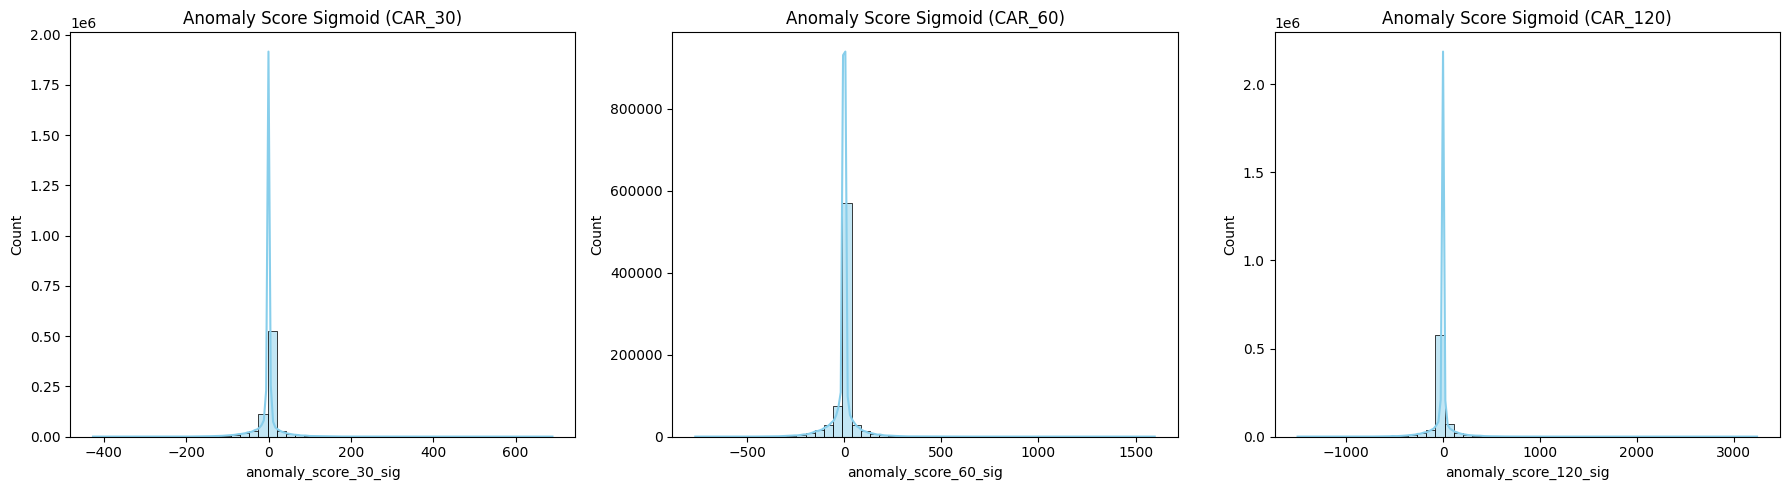

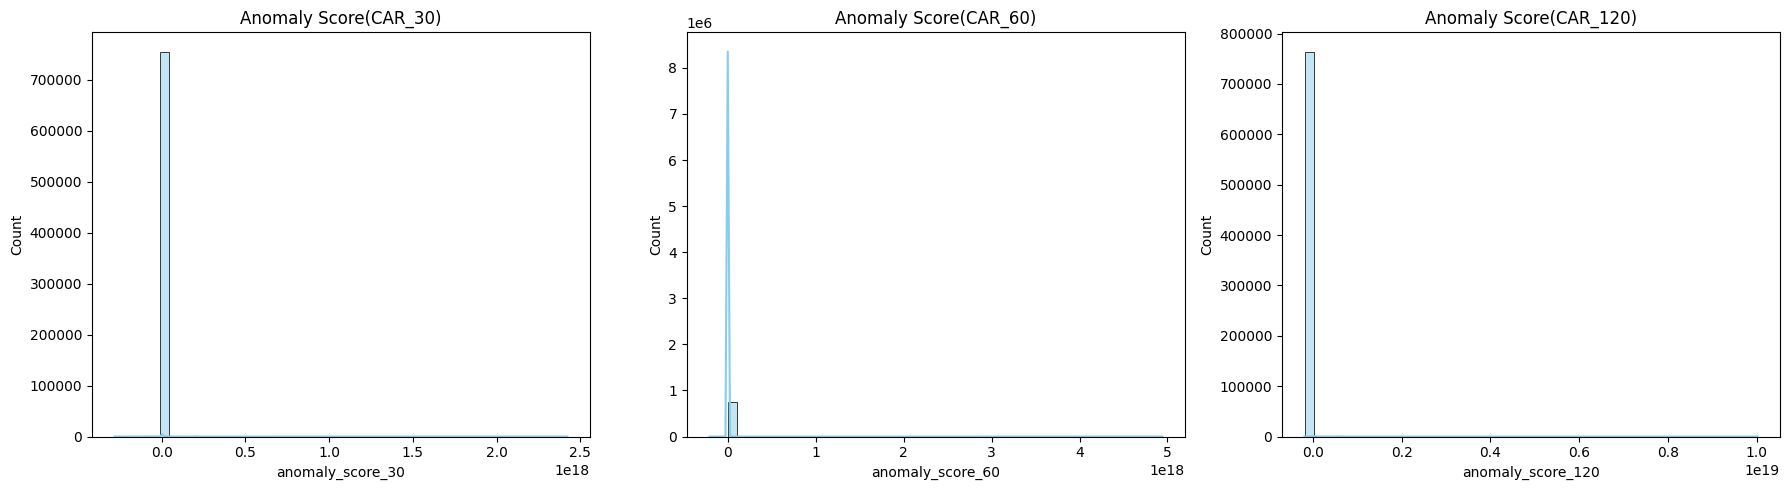

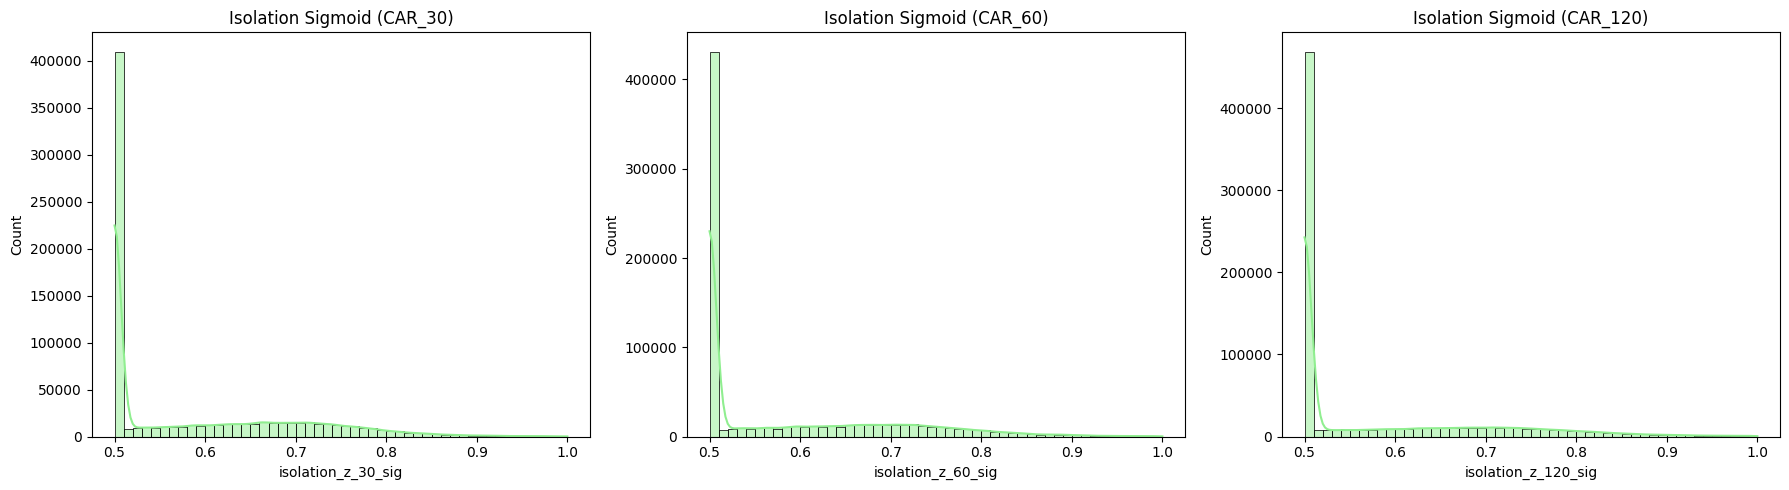

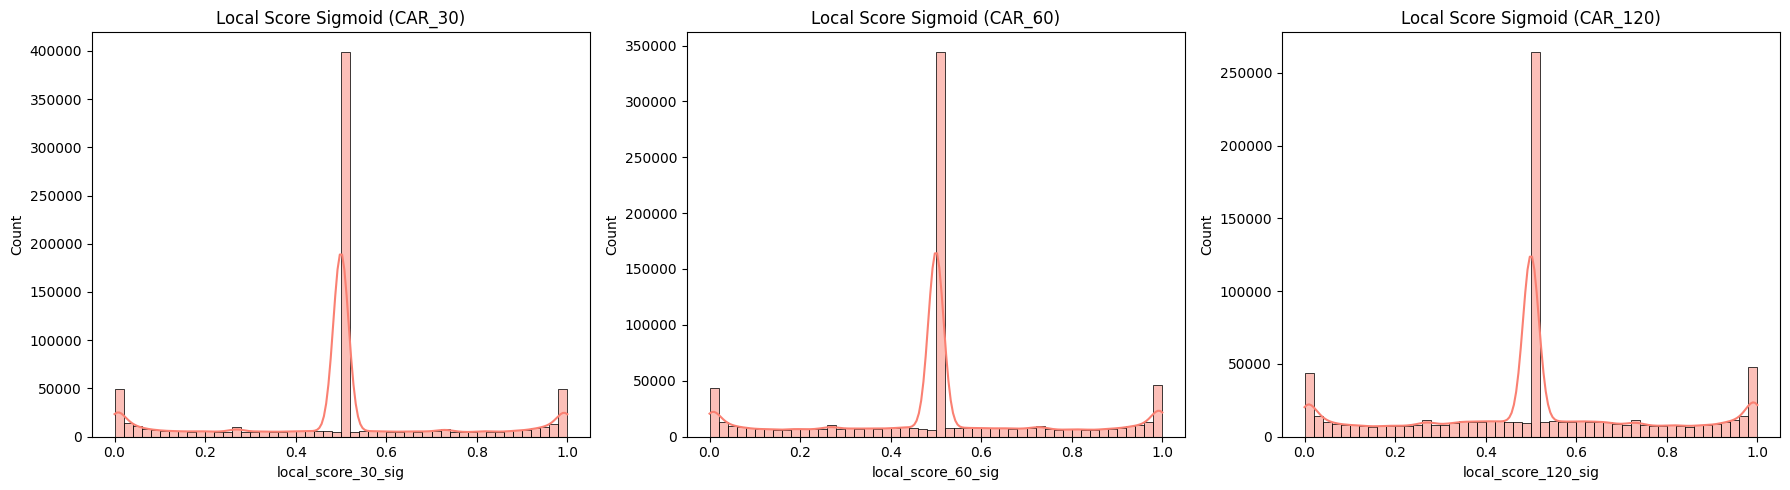

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the CAR windows we are interested in.
windows = [30, 60, 120]

# --- Plot the distribution of anomaly_score_sig for each CAR window ---
fig, axs = plt.subplots(1, len(windows), figsize=(18, 5))
for i, w in enumerate(windows):
    col_name = f"anomaly_score_{w}_sig"
    data = df_result[col_name].dropna()
    sns.histplot(data, bins=50, kde=True, ax=axs[i], color='skyblue')
    axs[i].set_title(f"Anomaly Score Sigmoid (CAR_{w})")
    axs[i].set_xlabel(col_name)
plt.tight_layout()
plt.show()

# --- Plot the distribution of anomaly_score for each CAR window ---
fig, axs = plt.subplots(1, len(windows), figsize=(18, 5))
for i, w in enumerate(windows):
    col_name = f"anomaly_score_{w}"
    data = df_result[col_name].dropna()
    sns.histplot(data, bins=50, kde=True, ax=axs[i], color='skyblue')
    axs[i].set_title(f"Anomaly Score(CAR_{w})")
    axs[i].set_xlabel(col_name)
plt.tight_layout()
plt.show()


# --- Plot the distribution of isolation_z_sig for each CAR window ---
fig, axs = plt.subplots(1, len(windows), figsize=(18, 5))
for i, w in enumerate(windows):
    col_name = f"isolation_z_{w}_sig"
    data = df_result[col_name].dropna()
    sns.histplot(data, bins=50, kde=True, ax=axs[i], color='lightgreen')
    axs[i].set_title(f"Isolation Sigmoid (CAR_{w})")
    axs[i].set_xlabel(col_name)
plt.tight_layout()
plt.show()

# --- Plot the distribution of local_score_sig for each CAR window ---
fig, axs = plt.subplots(1, len(windows), figsize=(18, 5))
for i, w in enumerate(windows):
    col_name = f"local_score_{w}_sig"
    data = df_result[col_name].dropna()
    sns.histplot(data, bins=50, kde=True, ax=axs[i], color='salmon')
    axs[i].set_title(f"Local Score Sigmoid (CAR_{w})")
    axs[i].set_xlabel(col_name)
plt.tight_layout()
plt.show()


## EDA and Validation - its ok if theres error below


### Basic EDA of output values
The first EDA carried out 


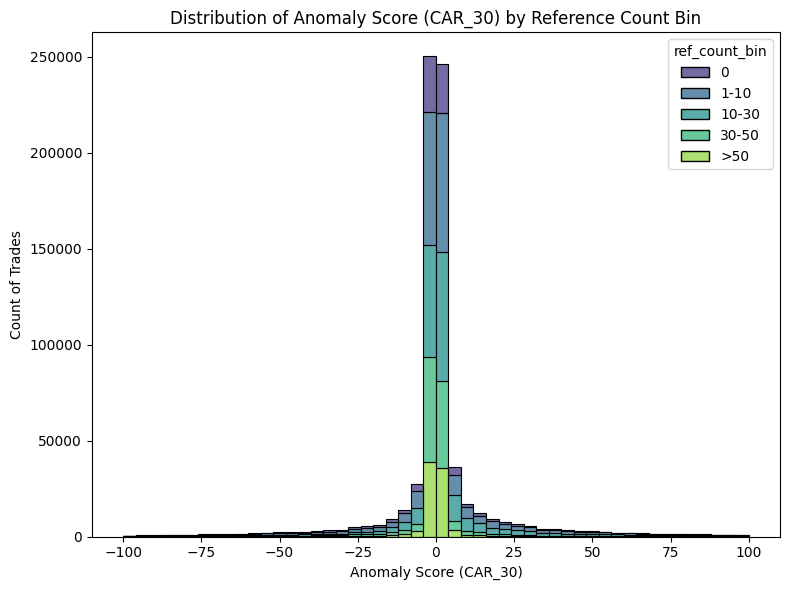

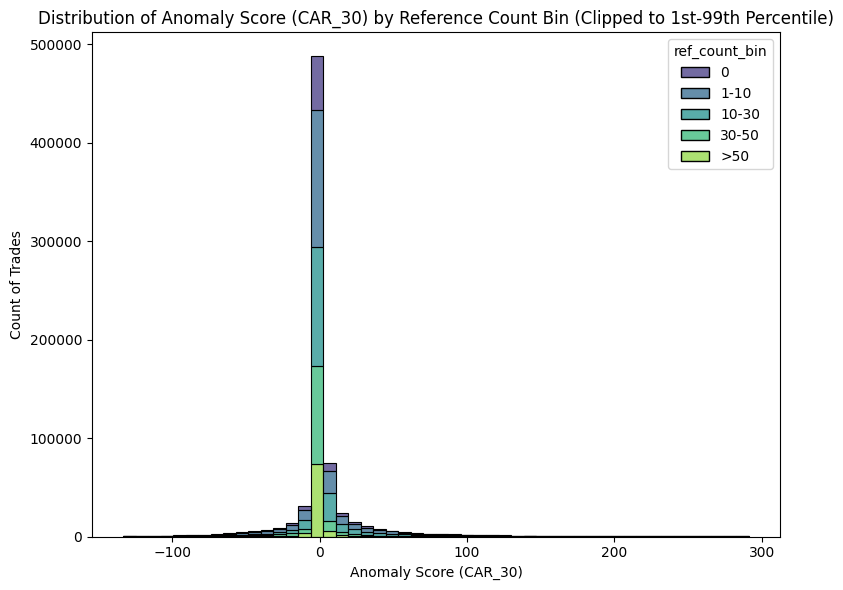

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a "ref_count_bin" column based on n_local_30.
# Bins: 0, 1-10, 10-30, 30-50, >50.
df_result['ref_count_bin'] = pd.cut(
    df_result['n_local_30'],
    bins=[0, 1, 10, 30, 50, np.inf],
    labels=["0", "1-10", "10-30", "30-50", ">50"],
    include_lowest=True
)

# Option 1: Specify bins and binrange manually
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_result, 
    x="anomaly_score_30", 
    hue="ref_count_bin",
    multiple="stack",
    bins=50,                # Use a fixed number of bins
    binrange=(-100, 100),   # Limit the x-axis range; adjust as needed
    palette="viridis",
    legend=True
)
plt.title("Distribution of Anomaly Score (CAR_30) by Reference Count Bin")
plt.xlabel("Anomaly Score (CAR_30)")
plt.ylabel("Count of Trades")
#plt.legend(title="Reference Count Bin", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Option 2: Clip the data to a reasonable range using quantiles (1st to 99th percentile)
q_low = df_result["anomaly_score_30"].quantile(0.01)
q_high = df_result["anomaly_score_30"].quantile(0.99)
plt.figure(figsize=(8,6))
sns.histplot(
    data=df_result, 
    x="anomaly_score_30", 
    hue="ref_count_bin",
    multiple="stack",
    bins=50,
    binrange=(q_low, q_high),   # Use the 1st to 99th percentile as range
    palette="viridis",
    legend=True
)
plt.title("Distribution of Anomaly Score (CAR_30) by Reference Count Bin (Clipped to 1st-99th Percentile)")
plt.xlabel("Anomaly Score (CAR_30)")
plt.ylabel("Count of Trades")
#plt.legend(title="Reference Count Bin", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


---
---
---



# Old code here.

## What this means

Clearly there are a good number of transactions without much around them. 
However, this doesnt mean we cannot label them. We can label them, because a lack of activity also means something, right? 

If say I were to buy a stock, and the others in my company havent bought anything for whats basically a 6 month period, isnt that weird?

But theres also concerns about the companies without many people in the first place and which maybe have traditionally a low average transaction count or frequency.



## I'm wondering if there is something to be gleaned in the case that there is no references because during that period, literally nobody in the company is trading that stock. Perhaps they are too uncertain, but the trader is certain due to some knowledge?

What happens if we run the same visualizers as above, but we filter for companies with, on average, more than 12 trades a year in total, and more than 2 insiders.




## Composite Anomaly Score Calculation

Our goal is to flag suspicious insider trades by combining two dimensions:
1. **Abnormality of Returns** – How much the trade’s cumulative abnormal return (CAR) deviates from the local norm.
2. **Isolation of the Trade** – How unique the trade is, measured by the scarcity of similar transactions (i.e. few peers trading in the same window).

### 1. Filtering Criteria
Before computing scores, we filter the dataset to ensure that each company meets our minimum activity requirements:
- **Average Trades Per Year:** Only consider companies with an average of at least 30 trades per active year.
- **Minimum Insiders:** Only consider companies with at least 3 unique insiders.
Transactions from companies that do not meet these thresholds are dropped.

### 2. Score Components

#### A. CAR Component
- **Step 1:** For each trade, compute the **CAR Z-score** using the local distribution of CAR values (e.g., for a 30-day CAR window).
- **Step 2:** Multiply the CAR Z-score by the raw CAR value to obtain the *CAR Component*:
  $$
  \text{CAR Component} = \text{CAR Z-score} \times \text{CAR}
  $$
This captures both the deviation from the norm and the magnitude of the return.

#### B. Isolation Component
- **Step 1:** For each trade, compute an **Isolation Score** that reflects how many peer trades exist in the same window (e.g., the number of other trades by different insiders in the same company).
- **Step 2:** Normalize these isolation scores within the company (i.e., compute an *Isolation Z-score*).
- **Step 3:** Multiply the Isolation Z-score by the raw CAR value to obtain the *Isolation Component*:
  $$
  \text{Isolation Component} = \text{Isolation Z-score} \times \text{CAR}
  $$
This emphasizes trades that occur in thinly traded environments.

### 3. Decision Rule for Composite Score
- **If the local reference sample size is sufficient (≥ 30 trades):**
  - Use the **CAR Component** as the anomaly score.
- **If the local reference sample size is insufficient (< 30 trades):**
  - Use the **Isolation Component** as the anomaly score.

Thus, the final anomaly score for each trade is defined as:

$$
\text{Anomaly Score} =
\begin{cases}
\text{CAR Z-score} \times \text{CAR}, & \text{if local sample size} \geq 30 \\
\text{Isolation Z-score} \times \text{CAR}, & \text{if local sample size} < 30
\end{cases}
$$

*Note:* In cases where no peer trades are available (i.e., local sample size is 0), the trade is flagged as extremely anomalous or handled separately.

### 4. Rationale
- **Abnormal Returns:** A high CAR relative to peers is a signal of potentially abnormal insider trading.
- **Isolation:** If few or no other insiders execute similar trades during the same period, the behavior is even more suspicious.
- **Adaptive Metric:** By choosing between the CAR-based score and the Isolation-based score based on the available sample size, we avoid issues when the local reference distribution is weak (i.e., when few peer trades exist).

This composite score is intended to provide a continuous label that can be used in further analysis or as a target for machine learning models aimed at detecting anomalous insider trading.


## It's pretty clear that there is some kind of inverse relationship between buy and sell which cannot be ignored in guaging overall sentiment.
While some cases basically have no buy or sell, we can worry less about that as we can still look at when people chose to buy, and the resulting CAR.


## Local Deviation Scoring for Abnormal Returns

### Overview
The goal of this analysis is to generate a “local score” for each transaction’s cumulative abnormal return (CAR) by comparing it against a local reference distribution. This local distribution is built from the CAR values of other insider trades within the same company, but within a narrow time window around the trade date. The rationale is that a trade’s abnormal return should be evaluated relative to the market conditions and trading activity at the time—captured by similar transactions. 

### Methodology

1. **Local Reference Window**  
   For each transaction, we define a local time window within which we collect reference trades. The window’s size depends on the CAR horizon:  
   - **CAR_30_after:** The default window is 1 month before the transaction date and 0.5 months after. If insufficient reference trades are found, the window is progressively expanded (up to 1.5 months or even 5 months in each direction).
   - **CAR_60_after:** A default window of 1 month on both sides is used; if necessary, the window is expanded to 1.5 or 3 months.
   - **CAR_120_after:** The default is 2 months before and 1 month after (or 1.5 months each side), with further expansion if needed.

2. **Score Calculation**  
   - **Z-Score:** If the local window contains at least 30 reference trades, we compute the z-score as  
     $$
     z = \frac{CAR_{trade} - \mu_{local}}{\sigma_{local}}
     $$
   - **T-Score:** If the local window has between 10 and 29 trades, we compute a t-score (to account for small sample sizes) as  
     $$
     t = \frac{CAR_{trade} - \mu_{local}}{\sigma_{local} / \sqrt{n}}
     $$
   - If the local window yields fewer than 10 trades or if the variance is zero, the score remains as missing (NaN).

3. **Efficient Computation with Binary Search**  
   To speed up the lookup of transactions within the time window, the code uses Python’s `bisect_left` and `bisect_right` on the sorted transaction dates for each company.

### Extending the Approach to Both Buys and Sells

In our initial implementation, the local score calculation was applied to one subset of transactions (e.g., buy trades). However, to fully capture insider trading behavior and compare across trading directions, we will apply the same local scoring procedure to both buy‐side and sell‐side transactions. This allows us to answer questions such as:
- Do insider buys tend to have higher (more abnormal) CARs relative to their local peer distribution compared to sells?
- Are there cases where an insider’s buy occurs in a market where nearly everyone else is selling, thereby creating a more extreme deviation in CAR?

### Next Steps in the Analysis

1. **Compute Local Scores for All Transactions**  
   - Apply the local score computation function to the combined dataset (or separately to `df_buys` and `df_sells`).
2. **Compare Buy vs. Sell Behavior**  
   - Create summary statistics and visualizations (e.g., boxplots or scatterplots) comparing the local scores between buy and sell trades.
   - Investigate whether the differences in local scores correlate with differences in trading volume, timing, or subsequent price behavior.
3. **Further EDA**  
   - Explore the distribution of local scores within each company.
   - Validate the approach by comparing transactions flagged as “abnormal” (i.e., high absolute local scores) with known instances of suspicious trading from empirical studies or expert opinions.

### Conclusion

By computing local z-scores (or t-scores when sample sizes are small) for both buy and sell trades, we create a standardized measure of how much a trade’s CAR deviates from its immediate peer group. This method can potentially serve as a proxy label for detecting trades that are unusual relative to the local trading environment. In subsequent analyses, we can examine whether these abnormal scores are predictive of further market movements or correlate with regulatory actions, thus providing insights into the information content of insider trades.
